# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



### Submission 1.0: Code baseline for all the exercises
In this section I will put all the code baseline that is in common for each exercise, in order to avoid code repetition. There will be libraries importing, **weight and biases** set up, *BasicModel*, *Training Manager* classes, and other useful methods such as *init_weights*.


[Link to weight and biases results](https://wandb.ai/mohamed-jebali/lab%201%20-%20dla?workspace=user-mohamed-jebali)

#### 1.0.0: Importing libraries

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torch.optim as optim
from torch.optim import SGD
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
from torch.optim.lr_scheduler import MultiStepLR

#### 1.0.1: Configuring Weight and Biases

Configuring weight and biases (wandb) for experiments tracking as in their official tutorial. Wandb will be used for monitoring the training runs, the gradients of the model and its parameters evolution.

In [ ]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
np.random.seed(hash("setting sandom seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 -1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Install library .wandb using pi
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb

wandb.login()

True

####1.0.2: Basic Model, Trainer Manager, Init Weights

Before proceding with solving the excercises I would like to implement 2 classes that will be reused in future, to avoid code replication.
The first one is **Basic Model**, which instantiate the princiapal methods of a model class while the second one is the **Trainer Manager** which will control the *trainining*, *validation* and *testing* procedures and a method for initializating the weights: **init_weigths**.

**Basic Model**

In [ ]:
class BasicModel(nn.Module):
    """
    Base class for neural network models.
    """

    def __init__(self):
        super(BasicModel, self).__init__()
        # Common model initialization code

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        raise NotImplementedError("Forward method must be implemented by subclasses")

    def count_parameters(self):
        """
        Count the total number of trainable parameters in the model.

        Returns:
            int: Total number of trainable parameters.
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def summary(self):
        """
        Print a summary of the model, including the architecture and the total number of trainable parameters.
        """
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print("Model Summary")
        print("-" * 50)
        print(self)
        print(f"Total Trainable Parameters: {params}")
        print("-" * 50)


**Trainer Manager**

This trainer manager class contains the **weight and biases** configuration

In [ ]:
class TrainerManager:
    """
    Trainer class for training and evaluating a neural network model.
    """

    def __init__(self, device='cpu'):
        """
        Initialize the Trainer object.

        Args:
            device: device where the model and the data are loaded; 'cpu' default choice.
        """

        self.device = device


        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self, model, train_loader, val_loader, criterion, optimizer, num_epochs, gradient_flow = False, scheduler = None, run_config = None):
        """
        Train the model for the specified number of epochs.

        Args:
            model (nn.Module): The neural network model to train.
            train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
            criterion (nn.Module): Loss function for training.
            optimizer (torch.optim.Optimizer): Optimizer for model parameter updates.
            num_epochs (int): Number of epochs to train the model.
        """


        model.to(self.device)

        # 1) Start a new run to track this script
        wandb.init(
            # Set the project where this run will be logged
            project = "lab 1 - dla",
            # Track the hyperparameters and run metada
            config = run_config
        )

        # 2) Copy your config
        config = wandb.config

        # 3) Watch the model for tracking the gradients and parameters
        wandb.watch(model, log='all', log_graph=True)

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for batch, (X, y) in enumerate(train_loader):
                X, y = X.to(self.device), y.to(self.device)


                # Debugging
                # y = torch.unsqueeze(y, dim=0)  # Add a batch dimension

                #print("Input shape:", X.shape)
                #print("Target shape:", y.shape)


                # Forward pass
                y_hat = model(X)
                loss = criterion(y_hat, y)

                # Backward pass and optimizer
                optimizer.zero_grad()
                loss.backward()

                # Flag to decide if saving the gradients flow values

                if gradient_flow:
                  plot_grad_flow(model.named_parameters())

                optimizer.step()

                # Track training statistics
                running_loss += loss.item() * X.size(0)
                _, predicted = torch.max(y_hat.data, 1)
                total_predictions += y.size(0)
                correct_predictions += (predicted == y).sum().item()

            # Calculate average statistics for the epoch
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct_predictions / total_predictions

            # Store training statistics
            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_accuracy)

            # 4) Train metrics for WandB

            train_metrics = {
                "train/train_acc":epoch_accuracy,
                "train/train_loss":epoch_loss,
                'train/epoch':epoch
            }

            # Print epoch statistics
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

            # Check if there is a scheduler and run it
            if scheduler is not None:
              scheduler.step()

            # Perform validation
            val_loss, val_acc = self._validate(model, val_loader)

            # 5) Val metrics for WandB

            val_metrics = {
                "val/val_accuracy": val_acc,
                "val/val_loss": val_loss
            }

            # 6) Log train and validation metrics to wandb

            wandb.log({**train_metrics, **val_metrics})

        # 7) Save the model
        # model.to_onnx()
        # wandb.save(run_config['architecture'] + '.onnx')

        # "model.h5" is saved in wandb.run.dir & will be uploaded at the end of training
        # model.save(os.path.join(wandb.run.dir, run_config['architecture'] + '.h5'))
        # wandb.save('model.pth')


        # Save a model file manually from the current directory:
        # wandb.save('model.h5')


        # Save all files that currently exist containing the substring "ckpt":
        # wandb.save('../logs/*ckpt*')


        # Save any files starting with "checkpoint" as they're written to:
        # wandb.save(os.path.join(wandb.run.dir, "checkpoint*"))


        # 8) Mark the run as finished
        wandb.finish()

    def _validate(self, model, val_loader):
        """
        Perform validation on the model using the validation dataset.

        Args:
            - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        """

        model.to(self.device)
        model.eval()  # Set the model in evaluation mode
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.to(self.device), y.to(self.device)

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, y)

                # Track validation statistics
                val_loss += loss.item() * y.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += y.size(0)
                val_correct_predictions += (predicted == y).sum().item()

        # Calculate average statistics for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct_predictions / val_total_predictions

        # Store validation statistics
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)


        # Print validation statistics
        print(f"Validation Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")

        return val_loss, val_accuracy


    def test(self, model, test_loader):
        """
        Evaluate the model on the testing dataset and print the test accuracy.


        Args:
            - test_loader (torch.utils.data.DataLoader): DataLoader for the testing dataset.
        """

        model.to(self.device)
        model.eval()  # Set the model in evaluation mode
        test_correct_predictions = 0
        test_total_predictions = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total_predictions += labels.size(0)
                test_correct_predictions += (predicted == labels).sum().item()

        # Calculate test accuracy
        test_accuracy = test_correct_predictions / test_total_predictions

        # Print test accuracy
        print(f"Test Accuracy: {test_accuracy:.4f}")
        return test_accuracy

    def plot_curves(self):
        """
        Plot the training and validation curves.
        """
        epochs = len(self.train_losses)
        x = range(1, epochs + 1)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(x, self.train_losses, label="Training Loss")
        plt.plot(x, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(x, self.train_accuracies, label="Training Accuracy")
        plt.plot(x, self.val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


    def reset_training_history(self):
        """
        This function is called to reset training history
        when you want to apply the trainer to a different model
        """

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

**Init Weights**

In [ ]:
def init_weights(module):
    """
    Initializes the weights of a neural network module.

    Args:
        module (torch.nn.Module): The module whose weights are to be initialized.

    Returns:
        None.
    """
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        if module.weight is not None:
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        if module.weight is not None:
            nn.init.constant_(module.weight, 1)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)


#### 1.0.3: Analyzing gradient flow

This script taken from [this source](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/18) is helpful to check the gradient flow in the network and to look for anomalies. \\
UPDATE: For monitoring the gradients I will use the functionality of weight and biases instead of this function because it works better, but I will leave the code anyway for reference.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backward() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.grad is not None:
            if p.requires_grad and 'bias' not in n:
                layers.append(n)
                if p.grad.is_cuda:
                    grad = p.grad.cpu().abs()
                else:
                    grad = p.grad.abs()
                ave_grads.append(grad.mean())
                max_grads.append(grad.max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=0.02)  # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


#### 1.0.4: Display images function
Defining a function to display pictures to be used when we need to show them to verify the proper loading

In [ ]:
# Define a function to plot and display the images
def show_images(images):
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image, label = images[i]
        image = np.transpose(image.numpy(), (1, 2, 0))
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

In [ ]:
# This one rescales the image between 0 and 255 to avoid the WARNING message

def show_images(images):
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image, label = images[i]
        image = np.transpose(image.numpy(), (1, 2, 0))
        image = (image * 255).astype(np.uint8)  # Rescale to [0, 255]

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.

#### 1.1.1: Data preparation

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

100%|██████████| 9912422/9912422 [00:00<00:00, 126839132.12it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15191333.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35504527.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6189255.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Create data loaders for train, validation, and test sets
batch_size = 64
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

#### 1.1.2: Multi Layer Perceptron Class

This defines the multi layer perceptron class that inherits from the BasicModel class. It is a simple 2 layers deep fully connnected model as suggested by the exercise command.



In [ ]:
class MLPModel(BasicModel):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.apply(init_weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
input_size = 784  # Assuming input images of size 28x28
hidden_size = 128
num_classes = 10

model = MLPModel(input_size, hidden_size, num_classes)

In [ ]:
print(model)

#### 1.1.3: Hyperparameters setting

In [ ]:
epochs = 10
lr = 0.0001

#### 1.1.4: Training pipeline

Set up the run_config dict for the Weight and Biases experiment

In [ ]:
run_config = {
  "learning_rate": lr,
  "architecture": "MLP",
  "dataset": "MNIST",
  "epochs": epochs
}

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The device is: ', device)

The device is:  cuda


In [ ]:
# Define the model
mlp = MLPModel(input_size=784, hidden_size=128, num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=lr)

# Create the trainer object
trainer = TrainerManager(device)

# Train the model
trainer.reset_training_history()
trainer.train(mlp, train_loader, val_loader, criterion, optimizer, num_epochs=epochs, gradient_flow = True, run_config = run_config)

# Evaluate the model on the test set
test_accuracy = trainer.test(mlp, test_loader)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Check how the training has gone, especially to see if any underfitting or overfitting phenomena has occurred.

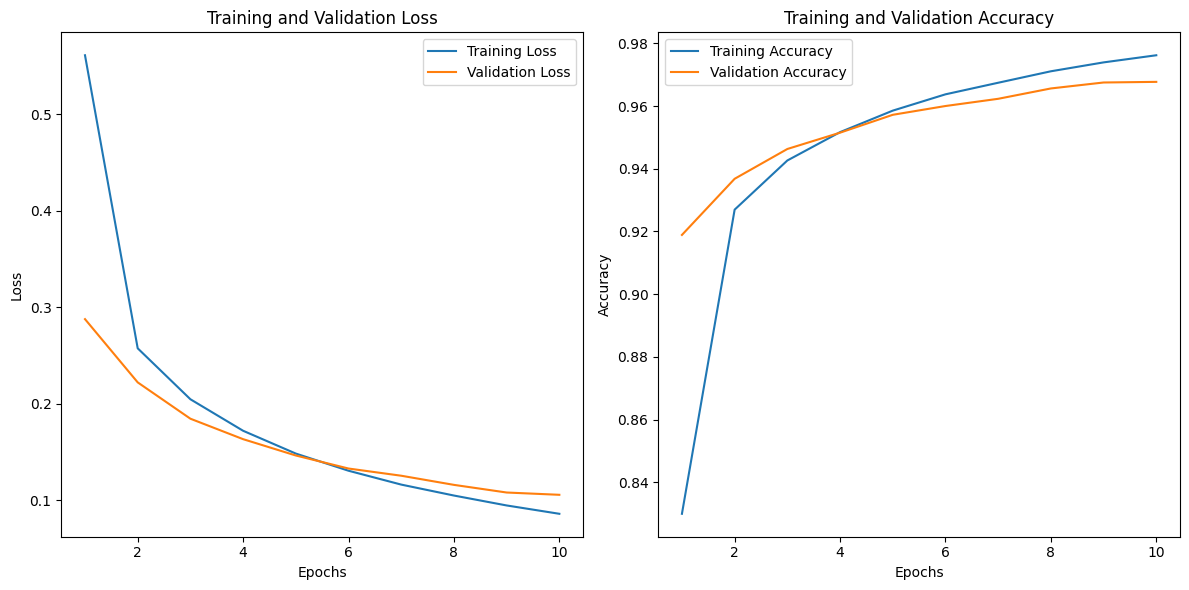

In [ ]:
trainer.plot_curves()

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).### Exercise 1.1: A baseline MLP

**NB**: As optional excercises of class 2, I wanted to try to quantify why ResNet works better and to do that I started from the hint in plotting the gradients. Since the gradients are visualized and plotted during the training, I used the function of **wandb** *watch* to track them and I did it here during the execution of this exercise. For this reason, there was no need to write any further code in section 2.1 and there I will just plot the results and give an interpretation of them.

#### 1.2.0: Data preparation

In this excerice I will use the CIFAR-10 dataset instead of the MNIST as suggested by the command.

The importing of the libraries, as well as the traininermanager and the other base classes will be the same of the previous exercise.

We are going to apply data augmentation to the training set as suggested in the original paper and the normalization. Since for normalizing data it is necessary to calculate the mean and standard value in advance, we are going to download the training set, calculate the mean and standard deviation and use the computed values for doing the proper transformation.


In [ ]:
# Donwload the CIFAR10 dataset
cifar10 = CIFAR10(root='./data', train=True, download=True)

# Calculate the mean and the std
mean = cifar10.data.mean(axis=(0, 1, 2)) / 255.0
std = cifar10.data.std(axis=(0, 1, 2)) / 255.0

print("Mean:", mean)
print("Std:", std)

100%|██████████| 170498071/170498071 [00:12<00:00, 13228300.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: [0.49139968 0.48215841 0.44653091]
Std: [0.24703223 0.24348513 0.26158784]


In [ ]:
# Define the computed mean and standard deviation
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

# Data augmentation transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Transformations for the test and validation sets
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the CIFAR-10 dataset
ds_train_cifar = CIFAR10(root='./data', train=True, download=False, transform=train_transform)
ds_test_cifar = CIFAR10(root='./data', train=False, download=False, transform=test_transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(ds_train_cifar))
val_size = len(ds_train_cifar) - train_size
ds_train_cifar, ds_val_cifar = torch.utils.data.random_split(ds_train_cifar, [train_size, val_size])

In [ ]:
# Create data loaders for train, validation, and test sets
batch_size = 128
train_loader = DataLoader(ds_train_cifar, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(ds_test_cifar, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(ds_val_cifar, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

Let's check that the dataset has been loaded properly by showing some images

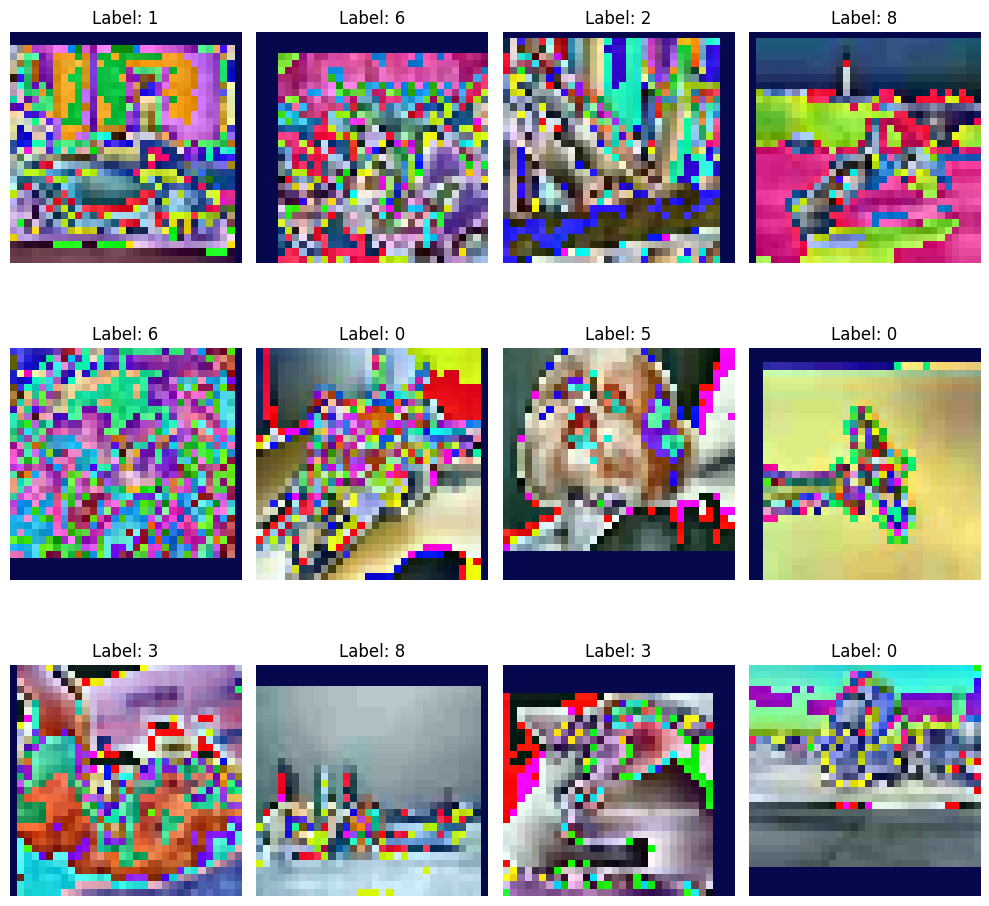

In [ ]:
# Select a few random images from the training set
num_images_to_display = 12
random_indices = torch.randint(0, len(ds_train_cifar), (num_images_to_display,))
random_images = [ds_train_cifar[i] for i in random_indices]

# Show the randomly selected images
show_images(random_images)

#### 1.2.2: VGG model



Here i propose an implementation of VGG [(link to paper)](https://arxiv.org/pdf/1409.1556.pdf%E3%80%82) as an architecture for deep CNN. I use this because is already validaded by literature, used as a comparison in the official paper of ResNet and the numnber of layers can be easily controllable for a fair comparison between the two architectures.

This is a general implementation and can be modulated by passing the right argument for *architecture*. Later on I trained and tested the following architecture:



*   VGG16
*   VGG19
*   VGG24

VGG24 is not an official architecture, but I wanted to try it just for the seek to go deeper and see what could happen in terms of accuracy of the model.



In [ ]:
class VGG(nn.Module):
    def __init__(self, in_channels, num_classes, architecture):
        super(VGG, self).__init__()

        self.features = self._make_layers(in_channels, architecture)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), # this outputs the logits for the cross entropy loss
        )

        self.apply(init_weights)


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, in_channels, architecture):
        layers = []
        for x in architecture:
            if x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True),
                ]
                in_channels = x
        return nn.Sequential(*layers)


This is an **example** of how the VGG class should be instantiated. I will leave it to make it clear how to properly instantiate the model.

In [ ]:
# Define the input channels, number of classes, and VGG architecture
in_channels = 3  # RGB images
num_classes = 10
vgg_architecture = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]

# Instantiate the VGG model
model = VGG(in_channels, num_classes, vgg_architecture)

# Generate some random input data
batch_size = 64
input_data = torch.randn(batch_size, in_channels, 224, 224)

# Forward pass
output = model(input_data)
print(output.shape)  # Shape: (batch_size, num_classes)


KeyboardInterrupt: ignored

In [ ]:
import gc
if model in locals() or model in globals():
  del model
gc.collect()

20

#### 1.2.2: ResNet model
This code implements a deep CNN class with residual blocks.
Due to sources constraint (I can only use google colab for training my neural networks) I opted to implement the 2 shallowest version of ResNet:



*   ResNet18
*   ResNet34

for this reason the implementation below is meant for the cited architectures and does not contain the *bottleneck* function for building deeper architecture. Neverthless, the architecture is scalable and can be easily upgraded for deeper networks.

As suggested in the paper [(link paper)](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), there are 2 kind of architecture that depends on the dataset used for training/testing:



*   Option A: Imagenet dataset
*   Option B; Cifar10 dataset

Due to the nature of the exercise, our default option is B.




In [ ]:
class ResidualBlock(BasicModel):
    """
    Residual block implementation for ResNet.
    """

    def __init__(self, in_channels, out_channels, stride=1, option='B'):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.residual = self._make_residual(in_channels, out_channels, stride, option)

    def _make_residual(self, in_channels, out_channels, stride, option):
        if option == 'A':
            residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        elif option == 'B':
            residual = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                residual.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False))
                residual.add_module('bn', nn.BatchNorm2d(out_channels))
        else:
            raise ValueError("Invalid option. Please choose 'A' or 'B'.")

        return residual

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        residual = self.residual(residual)

        x += residual
        x = self.relu(x)

        return x


In [ ]:
class ResNet(BasicModel):
    """

    ResNet implementation for image classication
    """

    def __init__(self, block, num_blocks, num_classes=10):
        """
        Initializes a ResNet model.

        Args:
            - block (nn.Module): type of residual block to use.
            - num_blocks (list): list of number of blocks for each stage.
            - num_classes (int, optional): number of output classes. Default is 10 for CIFAR-10 dataset
        """
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.apply(init_weights)


    def make_layer(self, block, out_channels, num_blocks, stride):
        """
        Crates a layer consisting of m
            - nn.Sequential: a sequence of layers of residual blocks.

        """

        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
          layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """

        Forward pass of the ResNet model

        Args:
            - x (torch.Tensor): Input tensor

        Returns:
            - torch.Tensor: Output tensor

        """

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.fc(x.view(x.size(0), -1))

        return x

**ResNet without BatchNorm**

To study the behave of ResNet gradients, I will try to remove batchnorm layers from the architecture.
This is just the same architecture as before without `batchnorm` layers.

In [ ]:
class ResidualBlockWBN(BasicModel):
    """
    Residual block implementation for ResNet without batchnorm layers
    """

    def __init__(self, in_channels, out_channels, stride=1, option='B'):
        super(ResidualBlockWBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        #self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        #self.bn2 = nn.BatchNorm2d(out_channels)
        self.residual = self._make_residual(in_channels, out_channels, stride, option)

    def _make_residual(self, in_channels, out_channels, stride, option):
        if option == 'A':
            residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                #nn.BatchNorm2d(out_channels)
            )
        elif option == 'B':
            residual = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                residual.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False))
                #residual.add_module('bn', nn.BatchNorm2d(out_channels))
        else:
            raise ValueError("Invalid option. Please choose 'A' or 'B'.")

        return residual

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        #x = self.bn2(x)

        residual = self.residual(residual)

        x += residual
        x = self.relu(x)

        return x


In [ ]:
class ResNetWBN(BasicModel):
    """

    ResNet implementation for image classication without batchnorm layers
    """

    def __init__(self, block, num_blocks, num_classes=10):
        """
        Initializes a ResNet model.

        Args:
            - block (nn.Module): type of residual block to use.
            - num_blocks (list): list of number of blocks for each stage.
            - num_classes (int, optional): number of output classes. Default is 10 for CIFAR-10 dataset
        """
        super(ResNetWBN, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.apply(init_weights)


    def make_layer(self, block, out_channels, num_blocks, stride):
        """
        Crates a layer consisting of m
            - nn.Sequential: a sequence of layers of residual blocks.

        """

        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
          layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """

        Forward pass of the ResNet model

        Args:
            - x (torch.Tensor): Input tensor

        Returns:
            - torch.Tensor: Output tensor

        """

        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.fc(x.view(x.size(0), -1))

        return x

In the next cell we put a function that allows us to choose which ResNet implementation we prefer, in order to change deepness of the architecture

In [ ]:
def resnet(name, num_classes=10, pretrained=False):
    """
    Returns suitable ResNet model from its name.

    Args:
        - name (str): name of resnet architecture.
        - num_classes (int): number of target classes.
        - pretrained (bool): whether to use a pretrained model.

    Returns:
        - torch.nn.Module.
    """

    if name == 'resnet18':
        return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes)
    elif name == 'resnet34':
        return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)
    raise ValueError('Only resnet18, resnet34 are supported!')

Launching the code for generating `resnet` architectures without `batchnorm` layers.

In [ ]:
def resnet_wbn(name, num_classes=10, pretrained=False):
    """
    Returns suitable ResNet without batchnorm layers model from its name.

    Args:
        - name (str): name of resnet architecture.
        - num_classes (int): number of target classes.
        - pretrained (bool): whether to use a pretrained model.

    Returns:
        - torch.nn.Module.
    """

    if name == 'resnet18':
        return ResNet(ResidualBlockWBN, [2, 2, 2, 2], num_classes=num_classes)
    elif name == 'resnet34':
        return ResNet(ResidualBlockWBN, [3, 4, 6, 3], num_classes=num_classes)
    raise ValueError('Only resnet18, resnet34 are supported!')

#### 1.2.4: Defining the models

In this block we will simply define the models, wich are:



1.   VGG as deep CNN: VGG16, VGG19, VGG24
2.   ResNet: ResNet18, ResNet34

At the moment, with the resources at my disposal I am capable only to instatiate ResNet18/34 and as a consequence I am going to compare them with VGG16/19/24.



In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The device is: ', device)

The device is:  cuda


In [ ]:
in_channels = 3
num_classes = 10
input_size = 784  # Assuming input images of size 28x28

##### 1.2.4.1 VGG

I instatiate a VGG16 architectures, which has a total of 16 weighted layers

In [ ]:
# Define the VGG16 model
vgg16_architecture = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16 = VGG(in_channels, num_classes, vgg16_architecture)

I instantiate a VGG19 architecture, which has a total of 19 weighted layers

In [ ]:
# Define the VGG19 model
vgg19_architecture = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256 'M', 512, 512, 512, 512 'M', 512, 512, 512, 512 'M']
vgg19 = VGG(in_channels, num_classes, vgg19_architecture)

Let's try to go deeper adding a conv layer at each block and get the VGG24 architecture

In [ ]:
# Define the VGG24 model
vgg24_architecture = [64, 64, 64, 'M', 128, 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
vgg24 = VGG(in_channels, num_classes, vgg24_architecture)

##### 1.2.4.2 ResNet

We instantiate a ResNet18, which has a total of 18 weighted layers

In [ ]:
# Define the ResNet18 model
resnet_18 = resnet('resnet18', num_classes, pretrained=False)

We instantiate ResNet34, a deeper version of resnet

In [ ]:
# Define the ResNet34 model
resnet_34 = resnet('resnet34', num_classes, pretrained=False)

We instantiate ResNet18 without batchnorm layers

In [ ]:
# Define the ResNet18 model
resnet_18_wbn = resnet_wbn('resnet18', num_classes, pretrained=False)

##### 1.2.4.3 Model check (OPTIONAL)
In this block we perform the models check to examine the following attributes:



1.   Architecture
2.   Number of layers
3.   Number of parameters

This check is useful to evaluate the memory consumption of the model and to be sure that the models we are testing have the same depth.

In [ ]:
def num_layers(model):
  """
  This function takes in input a model and calculates its number of layers

  Args:
      - model (nn.Module): a model

  Return:
      - num (int): the number of layers
  """
  num = sum(1 for _ in model.modules()) - 1 # Substract 1 for the root module
  return num

Check the number of layers of the model

In [ ]:
vgg16_layers = num_layers(vgg16)
resnet_18_layers = num_layers(resnet_18)

print("Number of layers of the VGG16:", vgg_16_layers)
print("Number of layers of the ResNet18:", resnet_18_layers)


Check the models architecture with summary from torchsummary

In [ ]:
from torchsummary import summary

input_data = torch.randn(batch_size, input_size)

print('ARCHITECTURE OF VGG16')
summary(vgg16, input_data.shape[1:])

print('ARCHITECTURE OF RESNET18')
summary(resnet_18, input_data.shape[1:])

Each **Basic Model** class has a *summary* function that prints the summary of the models.

In [ ]:
print('SUMMARY OF VGG16')
vgg16.summary()


print('SUMMARY OF RESNET18')
resnet_18.summary()

#### 1.2.3: Hyperparameters setting
In this section we define the hyperparameters. Mostly of them are chosed following the experimental details of the reference papers, like for example the *weight decay*, *momentum* or *learning rate*.
In particular, we use the same setting as in experiments of [Deep Residual Learning for Image Recognition](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

Both the architectures have been trained with the same hyperameters except for the *learning_rate*: infact, after several runs, I noticed that VGG needs a smaller learning rate for starting the training and for this reason its starting learning rate is set to be equal to 0.001. This choiche was made based on empirical evidences and analyzing the gradients. Further discussion will be held in section 2.1.

The networks have been trained for different levels of epochs, starting from 20 until 70, but after empirical evidence of the training accuracy, the best choiche for a tradeoff between training time and accuracy is to set the number of epochs at 50.

In [ ]:
# Define the hyperparameters
learning_rate = 0.001 # for resnet put it bigger like 0.01 or 0.1
weight_decay = 0.001 # try one run with increased penalization
momentum = 0.9
num_epochs = 50

#### 1.2.4: Training pipeline

In this section is displayed the training pipeline for each network. I have done several runs with different settings, for this reason all the results are not displayed here. All the results can be found in (PUT THE LINK) weight and biases project page, and at the end of the section I will put a summary with all the useful results.

So, the objective of this section is to set the training pipeline ready to be used again for reproducing the results on your own, not to show the results.

Follow these steps:



1.   Instantiate the TrainerManager()
2.   Define the run_config for the wandb monitoring
3.   Define Criterion, Optimizer, Scheduler
4.   Start the training
5.   Test the network
6.   Plot the train/val curves

You can also check the **gradients** and the **parameters** following the wandb link that appears after launching the training.



##### 1.2.4.1: Trainer Manager

Define the **trainer manager** object

In [ ]:
global_trainer = TrainerManager(device)

##### 1.2.4.2: VGG training pipeline

**run_config**

Change in "architecture" the type of VGG instantiated

In [ ]:
run_config_vgg = {
  "learning_rate": learning_rate,
  "weight_decay": weight_decay,
  "momentum": momentum,
  "optimizer": "SGD",
  "architecture": "VGG16",
  "dataset": "CIFAR10",
  "epochs": num_epochs
}

**Criterion, Optimizer, Scheduler**

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set up the optimizer
vgg_16_optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Set up the learning rate scheduler
vgg_16_scheduler = MultiStepLR(vgg_16_optimizer, milestones=[int(0.5 * num_epochs), int(0.75 * num_epochs)], gamma=0.1)

**Launch training, test and plotting**

In [ ]:
# Train VGG16 model
global_trainer.train(vgg16,
                     train_loader,
                     val_loader,
                     criterion,
                     vgg_16_optimizer,
                     num_epochs,
                     gradient_flow = False,
                     scheduler = vgg_16_scheduler,
                     run_config = run_config_vgg
                     )
# Test the model
global_trainer.test(vgg16, test_loader)

# Plot train/val curves
global_trainer.plot()

##### 1.2.4.3: ResNet training pipeline

**run_config**

Defining the dictionary containing the **run_config** options

In [ ]:
run_config_resnet = {
  "learning_rate": learning_rate,
  "weight_decay": weight_decay,
  "momentum": momentum,
  "optimizer": "SGD",
  "architecture": "ResNet18 without batch norm",
  "dataset": "CIFAR10",
  "epochs": num_epochs
}

**Criterion**, **Optimizer**, **Scheduler**.






In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
resnet_18_optimizer = optim.SGD(resnet_18.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Set up the learning rate scheduler
resnet_18_scheduler = MultiStepLR(resnet_18_optimizer, milestones=[int(0.5 * num_epochs), int(0.75 * num_epochs)], gamma=0.1)

**Launch training, test and plotting**

In [ ]:
# Train ResNet model
global_trainer.reset_training_history()
global_trainer.train(resnet_18,
                     train_loader,
                     val_loader,
                     criterion,
                     resnet_18_optimizer,
                     num_epochs,
                     gradient_flow = False,
                     scheduler = resnet_18_scheduler,
                     run_config = run_config_resnet
                     )
global_trainer.test(resnet_18_wbn, test_loader)
global_trainer.plot_curves()

#### 1.2.5: Results

In this section I report the results (mostly graphical) obtained by the different and several runs. The plots have been generated by Weight and Biases, and more data and details about the experiment are available at the project link.

##### 1.2.5.1: All the models result

**Compare all the models**



1.   **Research Question:**
    How do different models, including both ResNet and VGG architectures, perform in terms of accuracy on the validation set?
2. **Obtained Results:**
    After conducting several runs and plotting the validation and training curves, we observed the following performance ranking (from highest to lowest validation accuracy):


    1.   ResNet34
    2.   ResNet18
    3.   VGG19
    4.   VGG16
    5.   VGG24

3. **Interpretation:**
    From the results of Experiment 1, it is evident that the ResNet models outperform the VGG models consistently across all depths. This suggests that the residual connections in ResNet are significantly aiding in the learning process and preventing accuracy degradation as the network gets deeper. Additionally, we notice that VGG24 performs the worst among all models, indicating that increasing the depth of the VGG network has led to accuracy degradation.





**Train Accuracy**

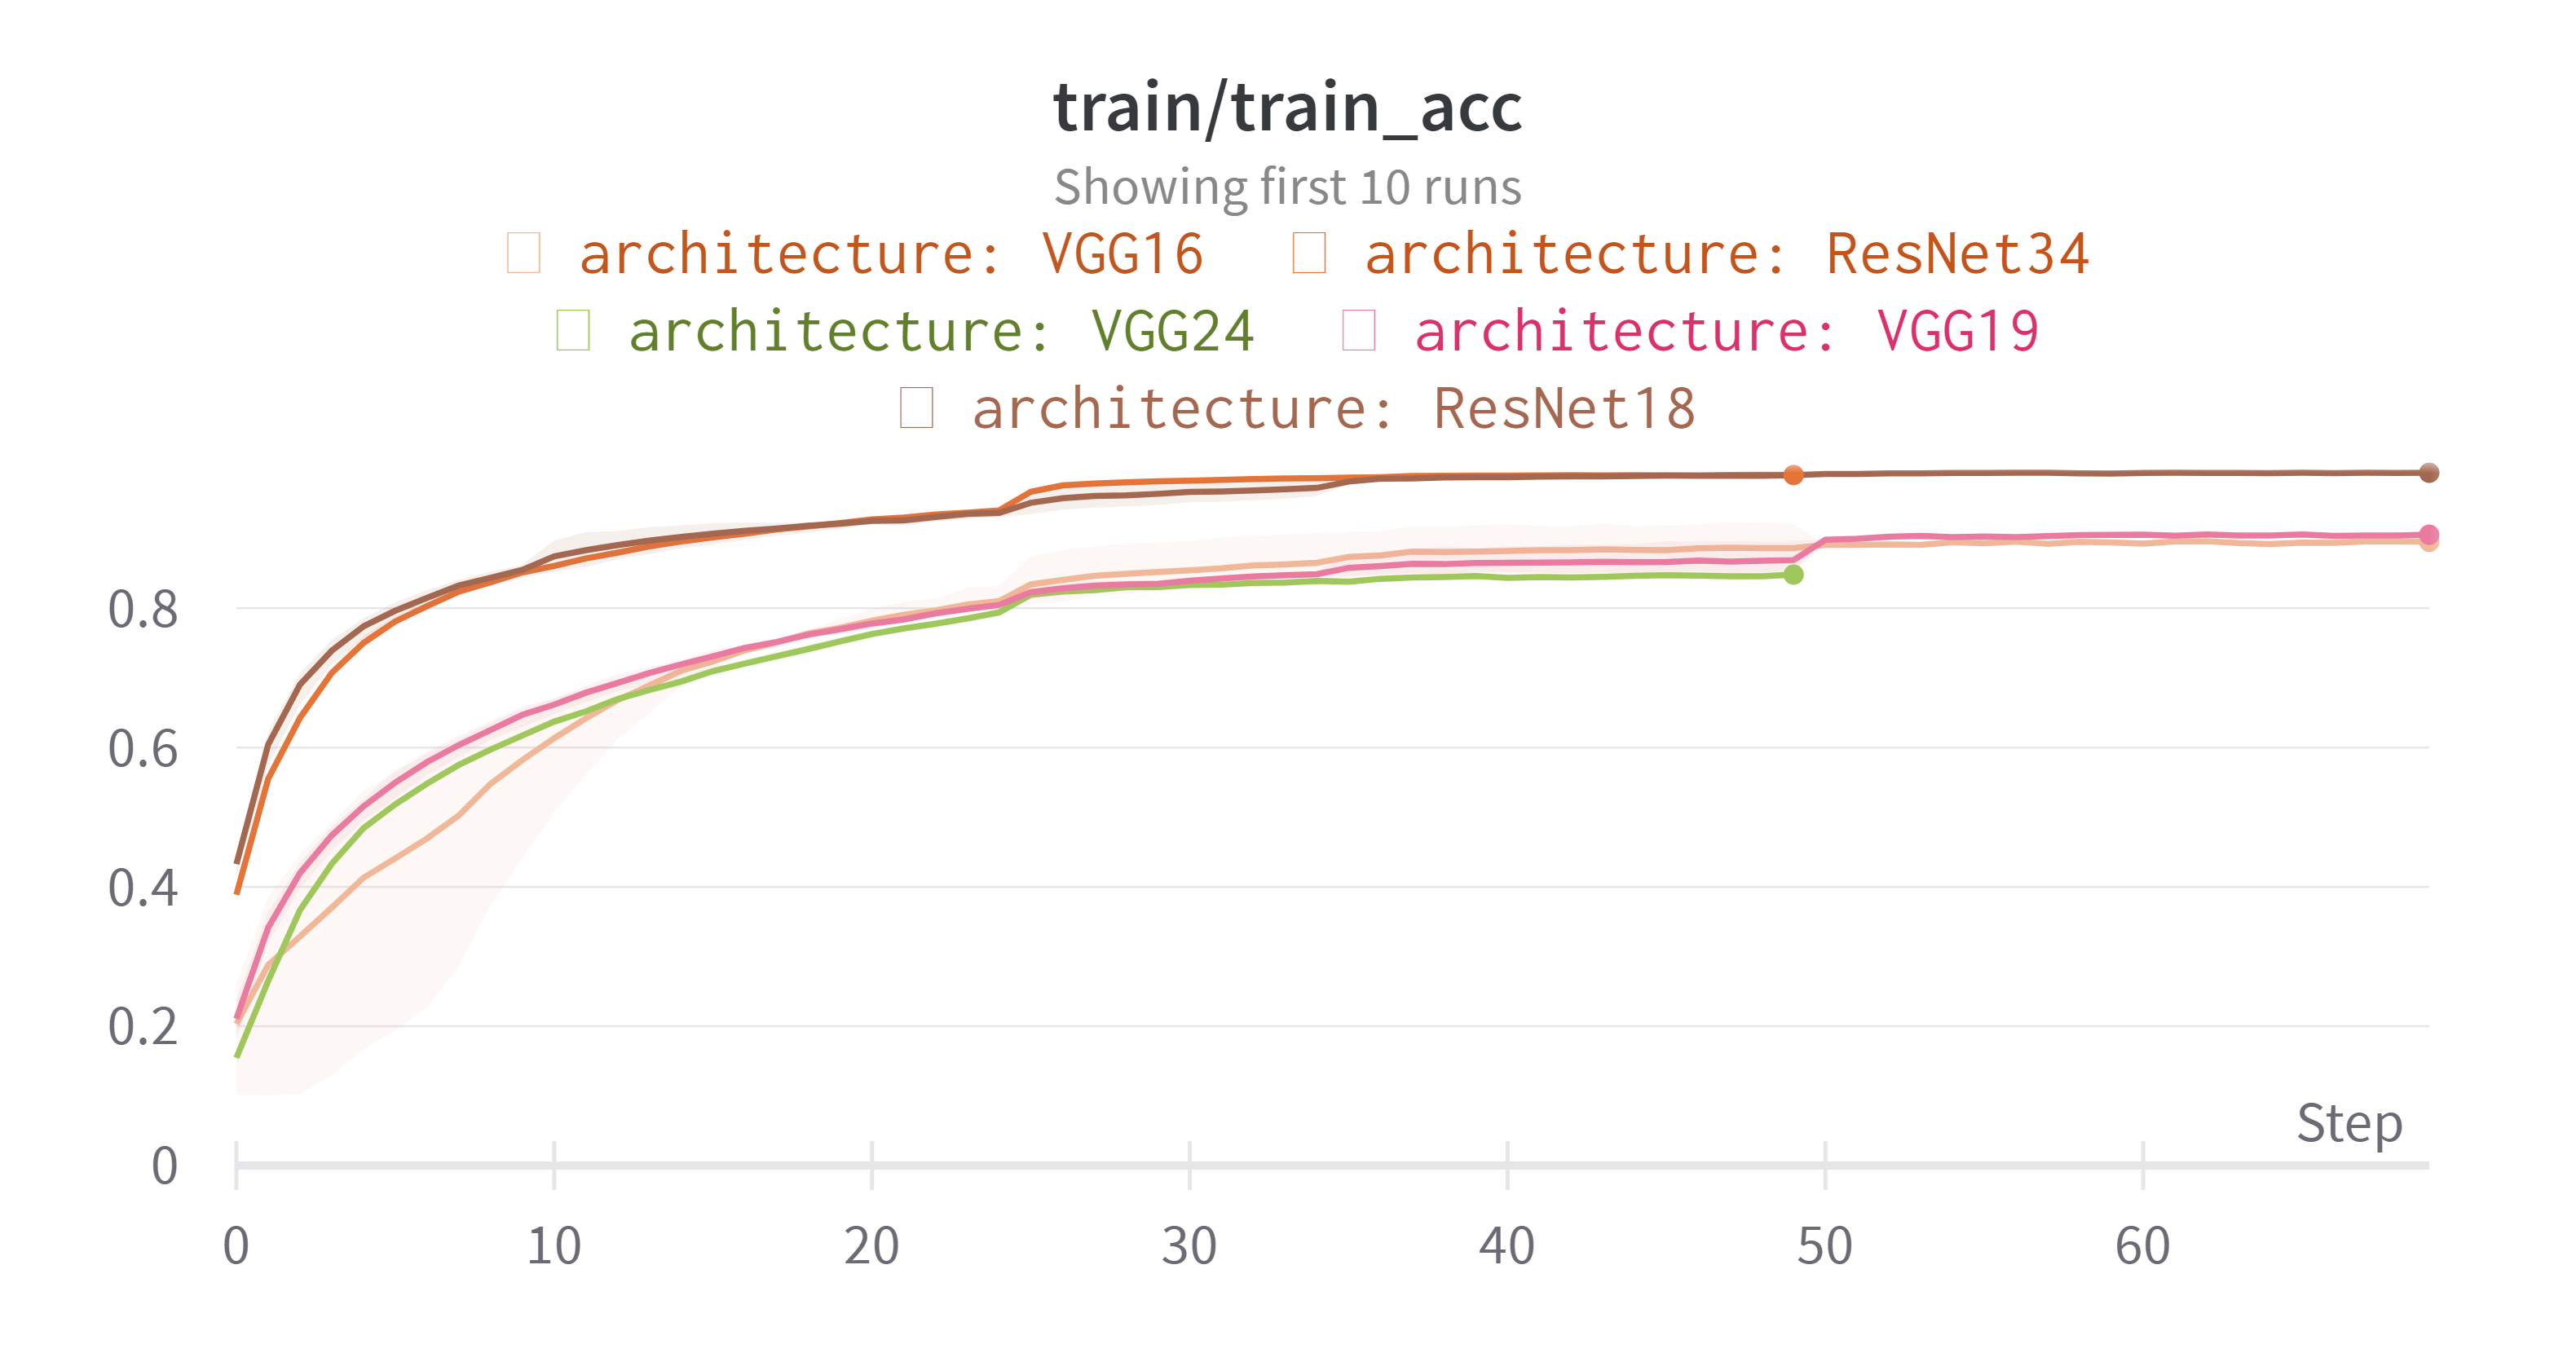

**Train loss**

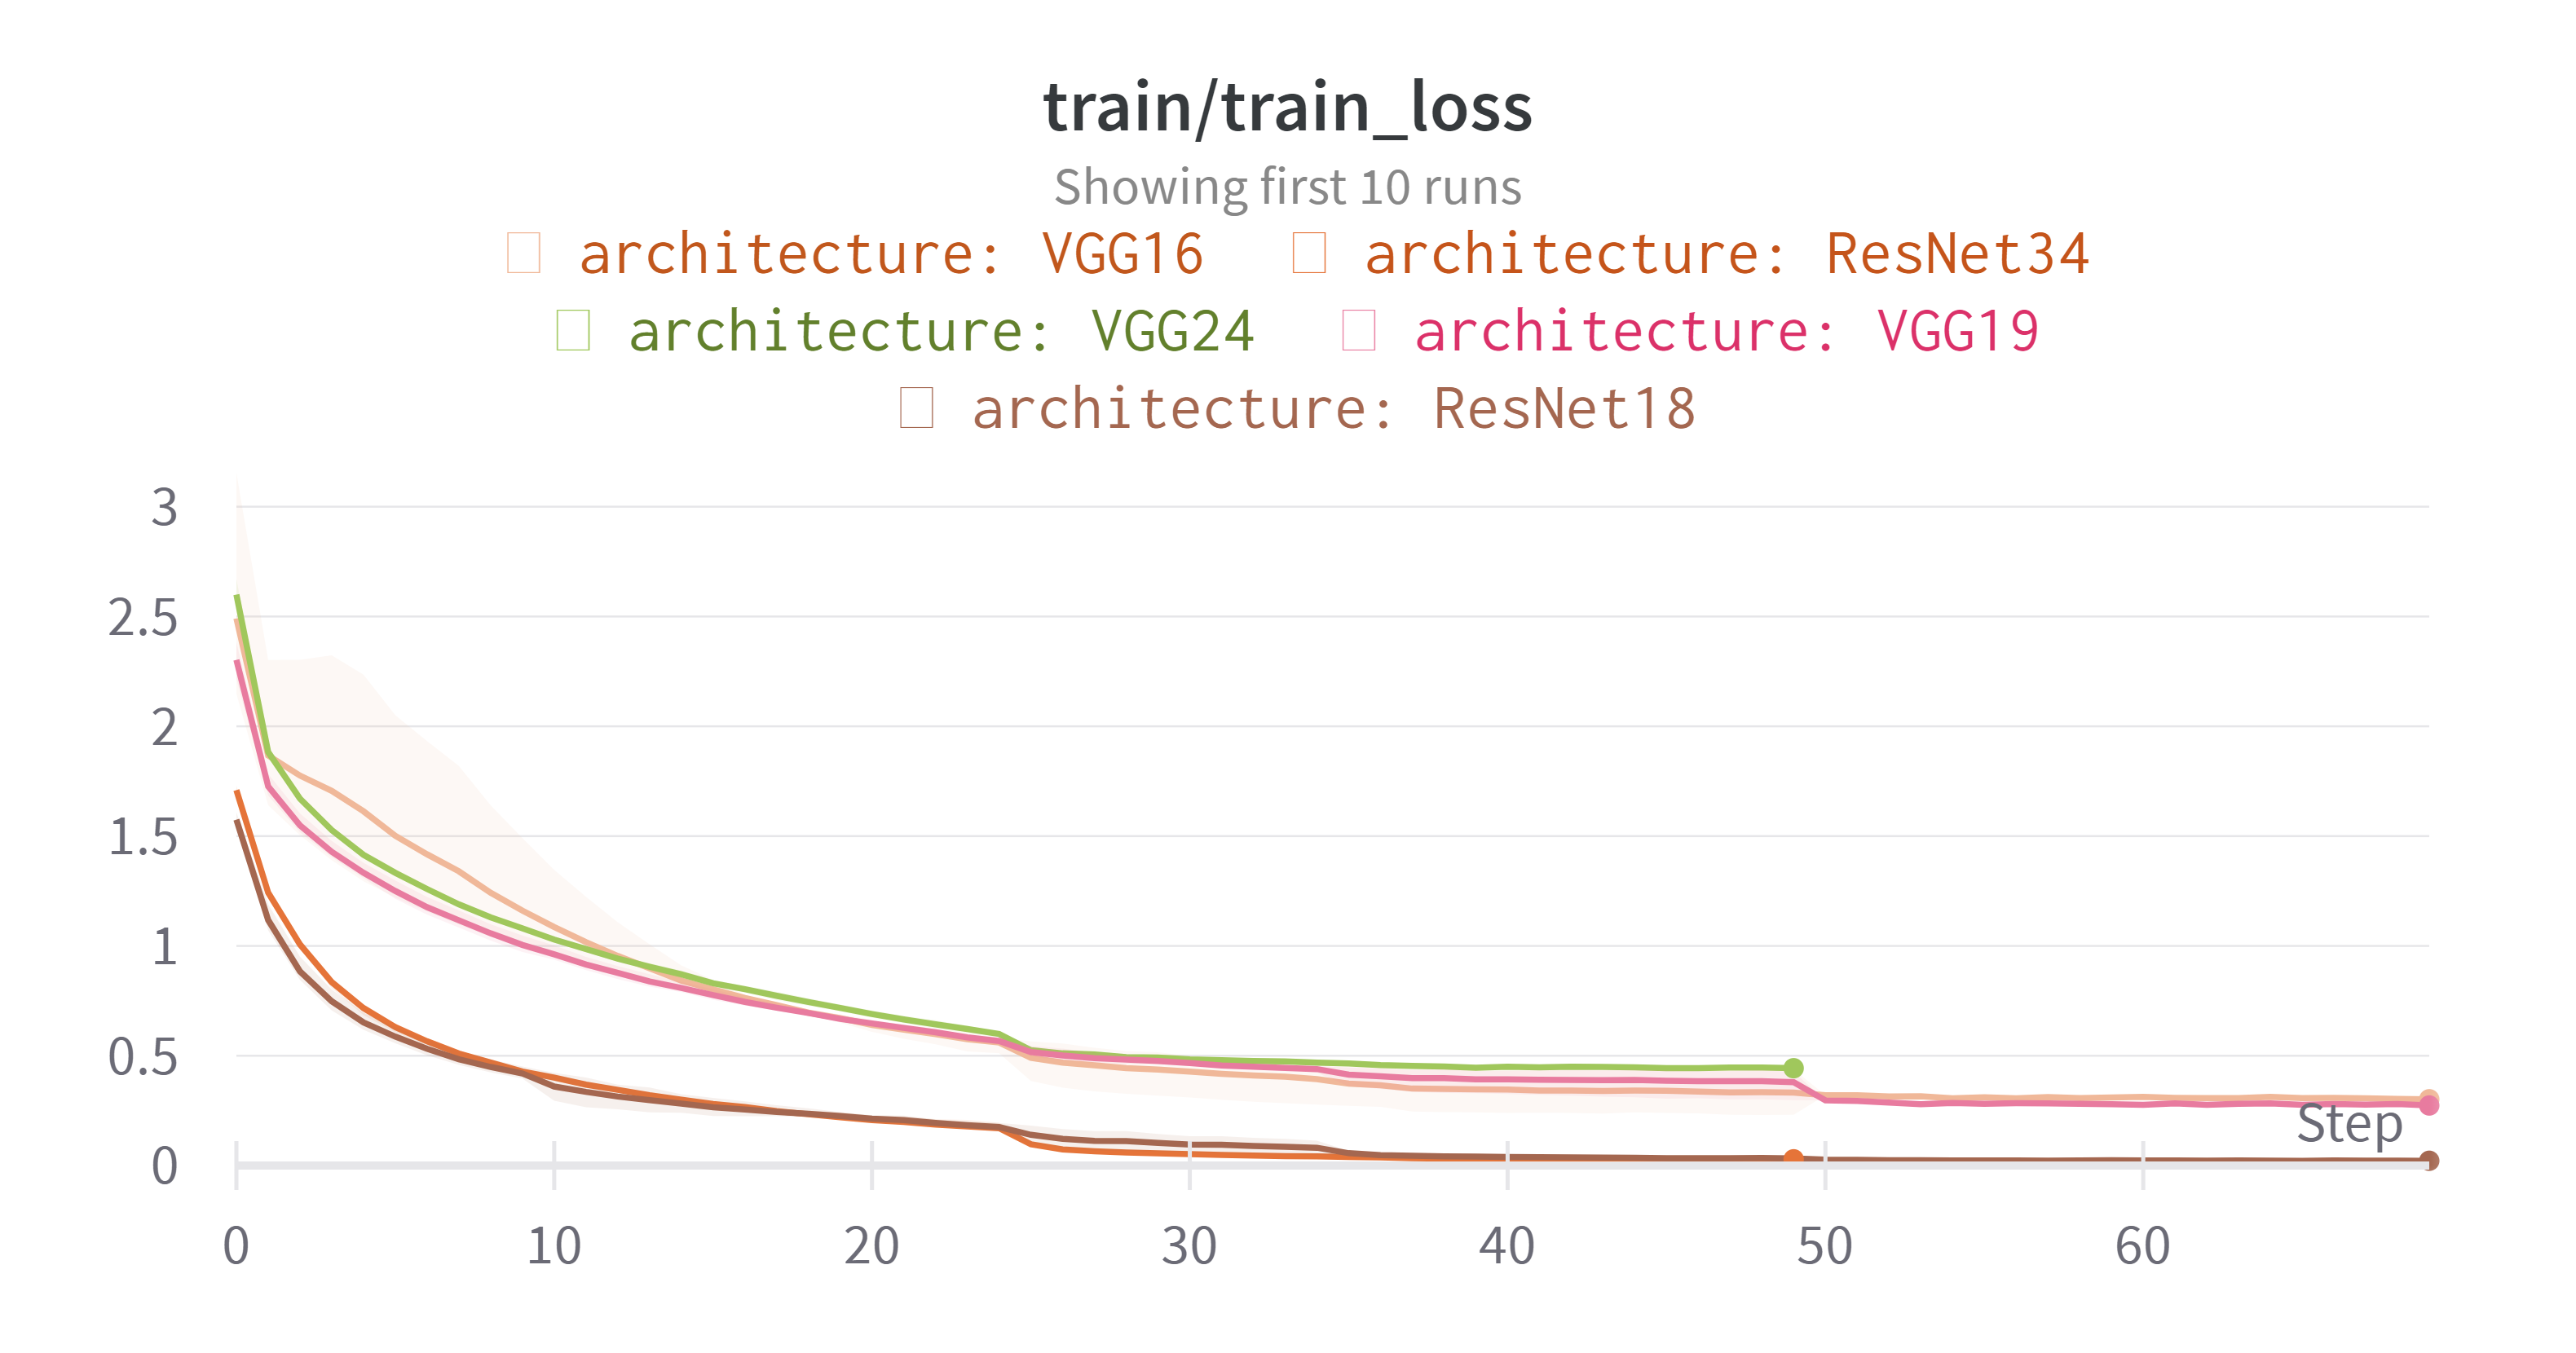

**Val Accuracy**

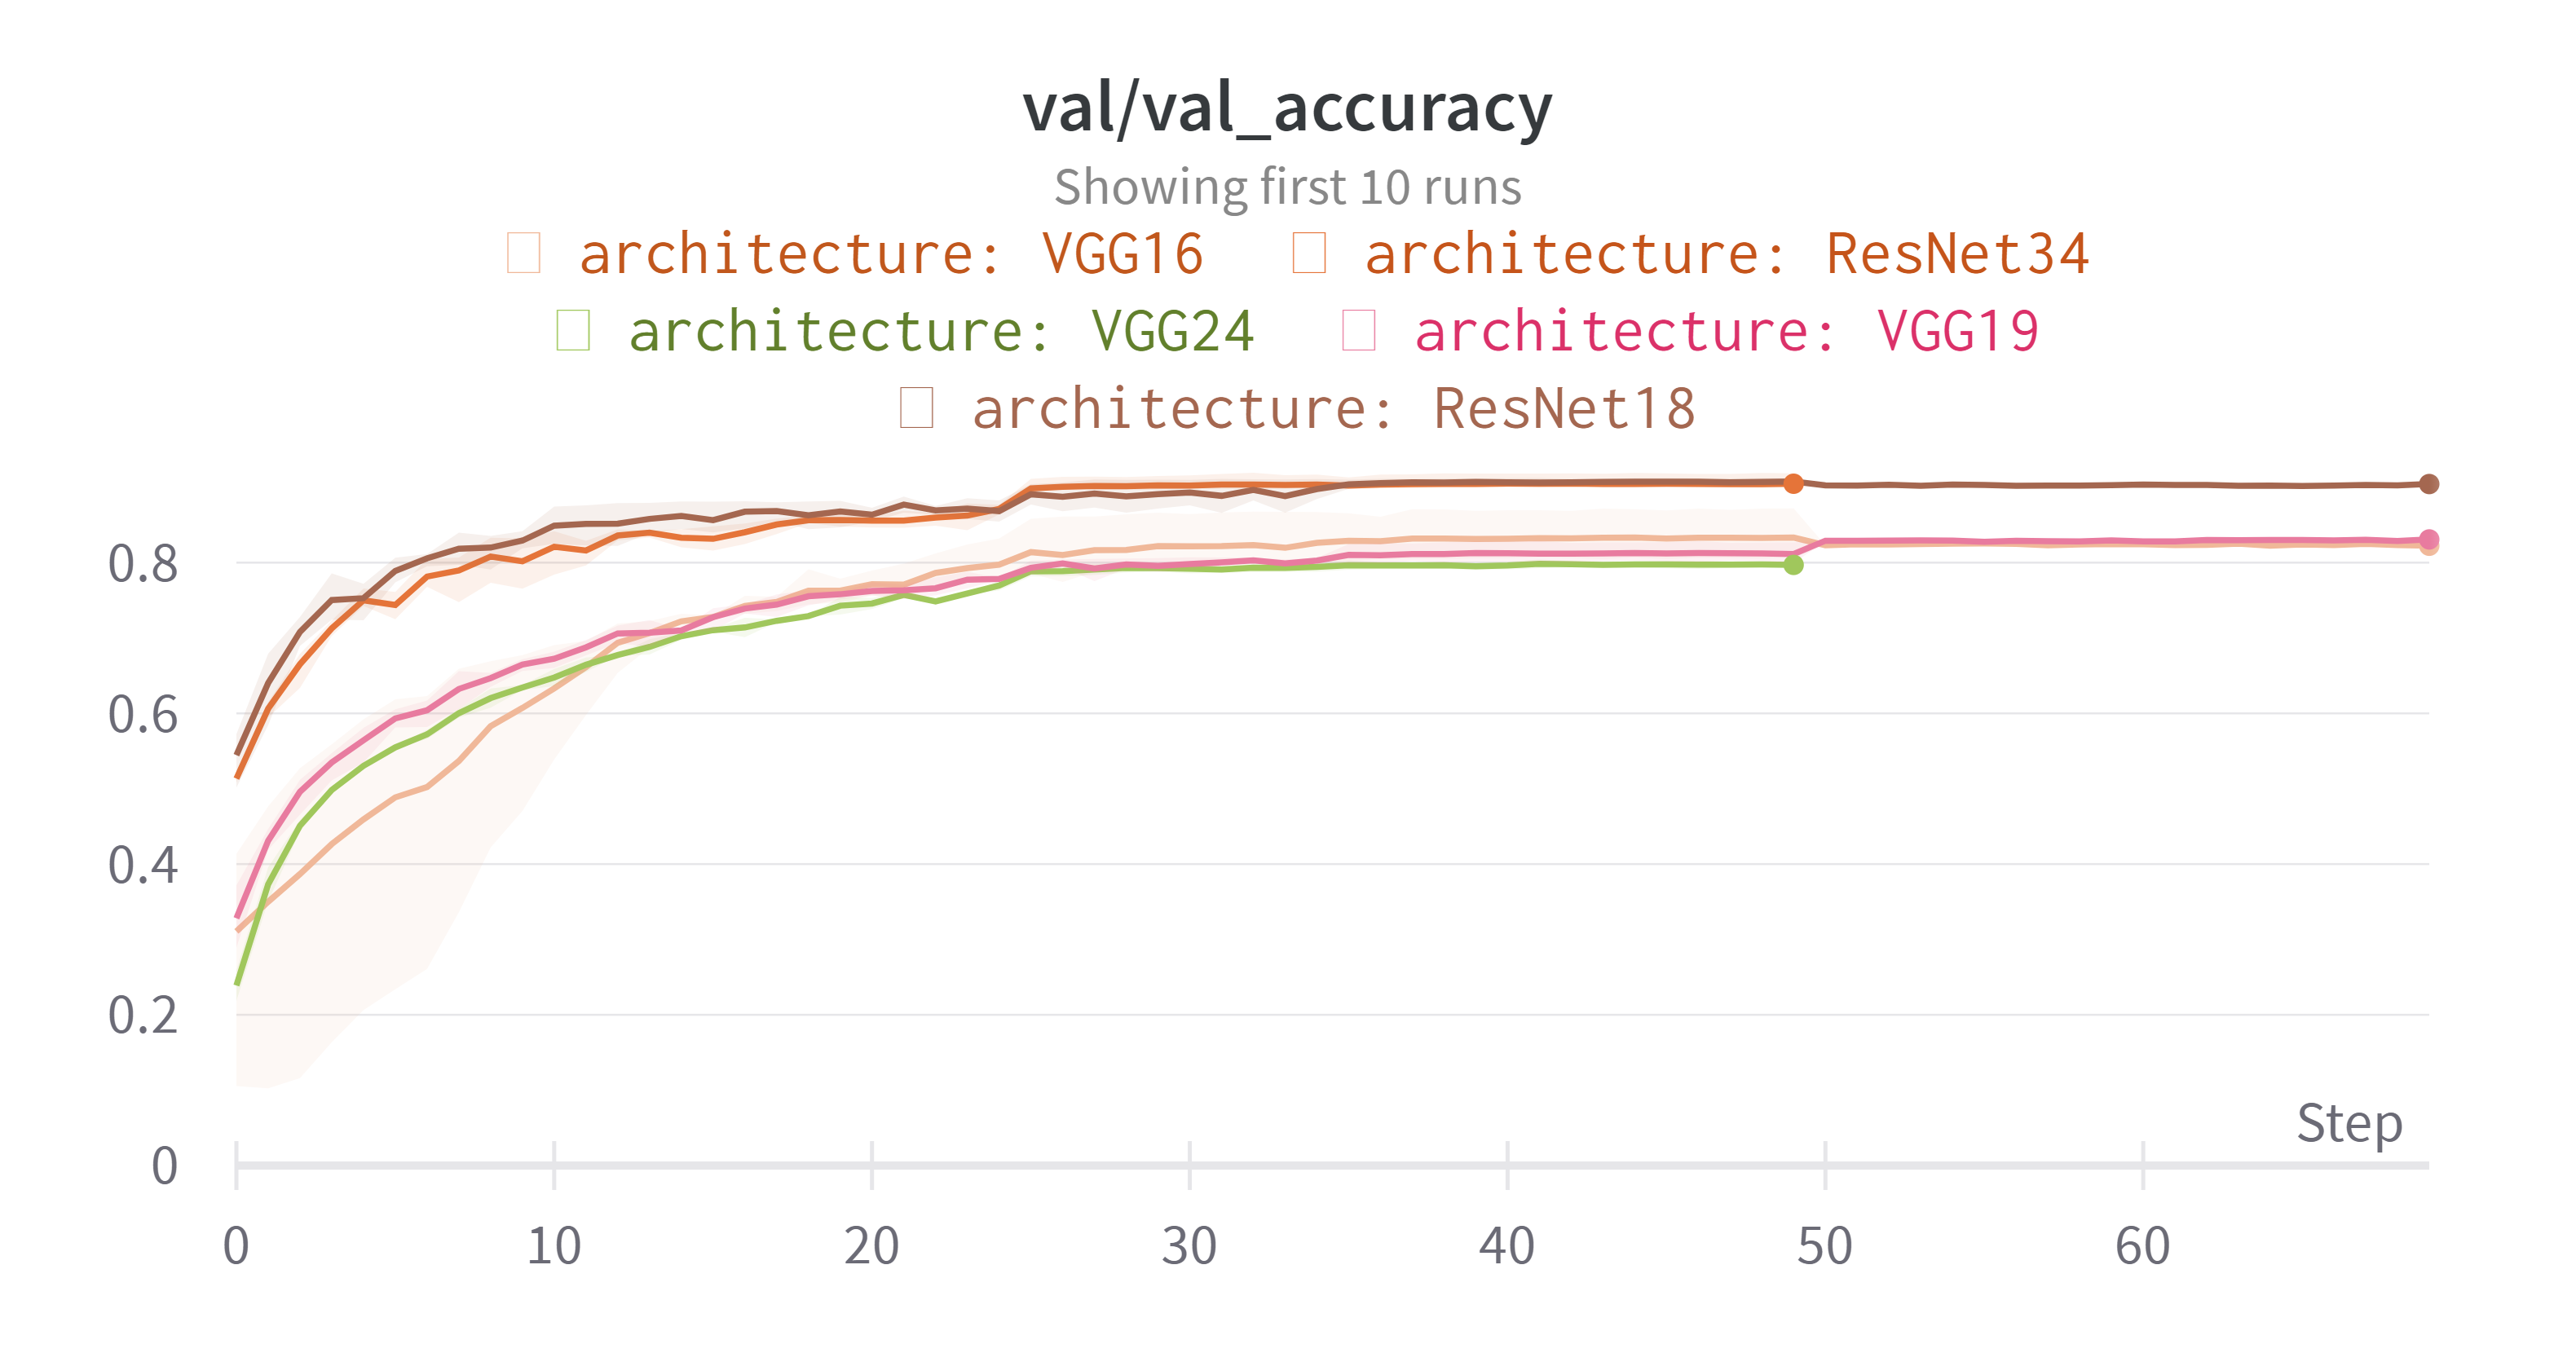

**Val Loss**

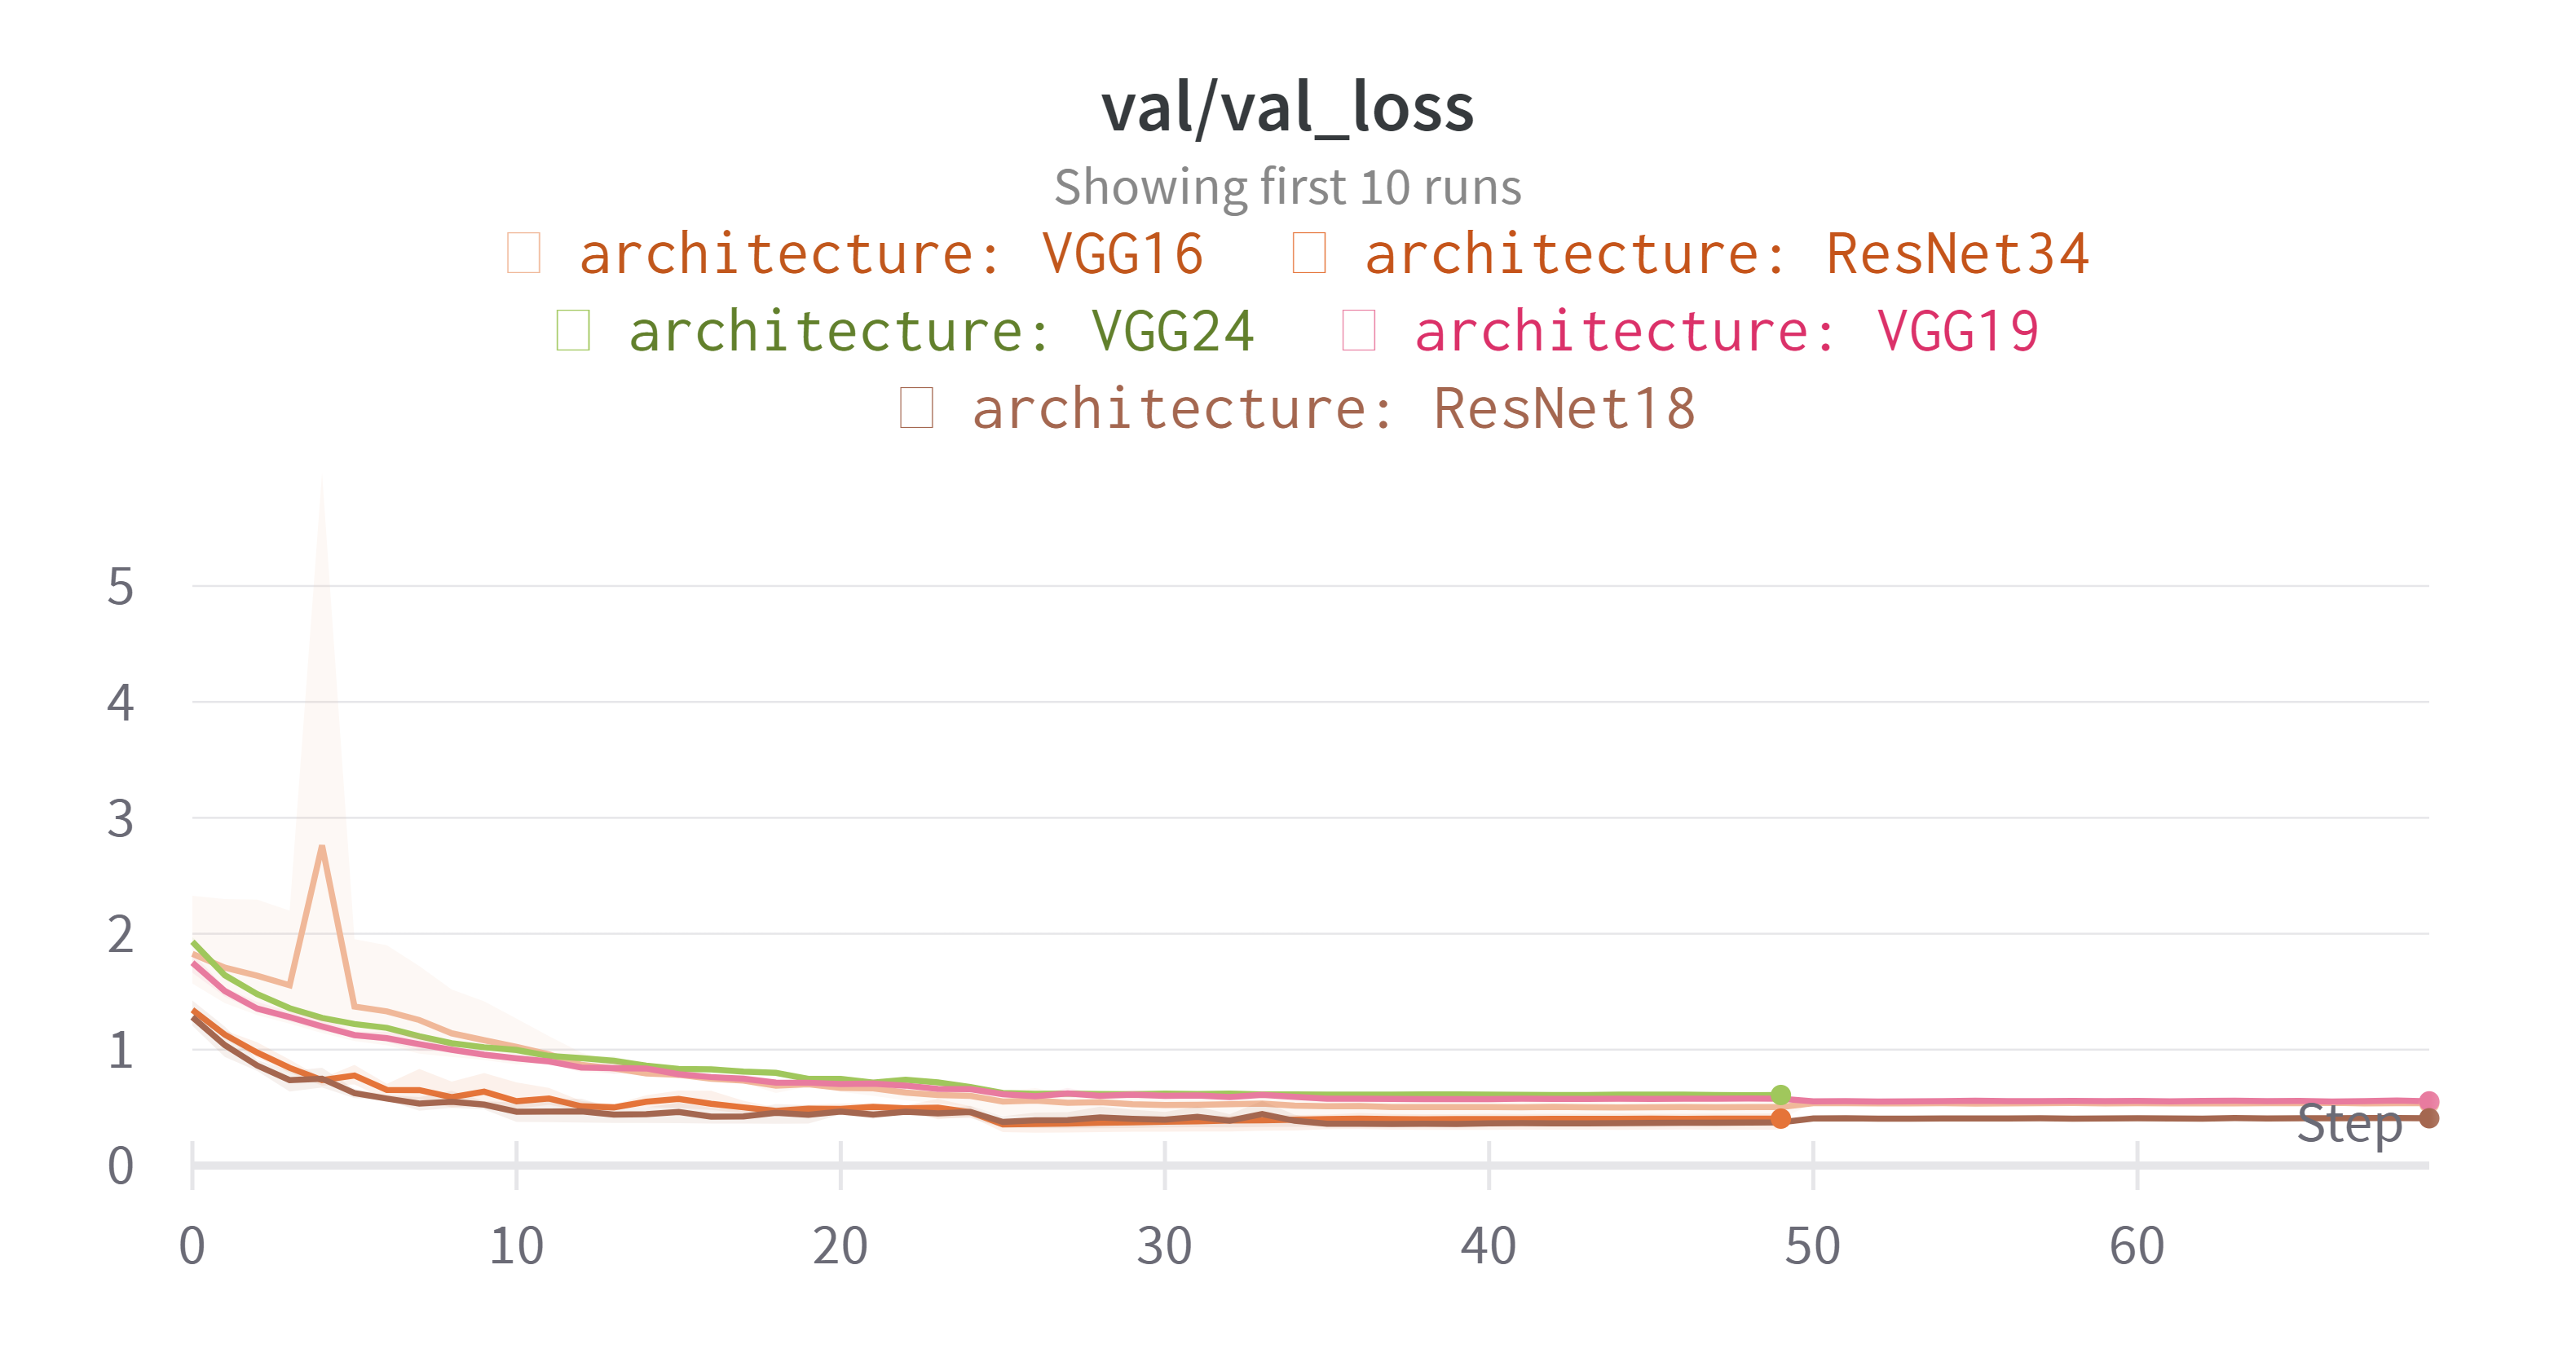

##### 1.2.5.2: VGG Results

**Compare ResNet**



1.   **Research Question:**
    How does the accuracy of VGG models change as we increase the depth (VGG16 vs. VGG19 vs. VGG24)?
2. **Obtained Results:**
    Upon analyzing the validation and training curves of VGG16, VGG19, and VGG24, we observed the following performance ranking:

    1.   VGG16
    2.   VGG19
    3.   VGG24

3. **Interpretation:**
    Experiment 3 indicates that, unlike ResNet, increasing the depth of the VGG models negatively impacts accuracy. The highest accuracy was achieved by the shallower VGG16 model, followed by VGG19 and VGG24. This degradation in performance as the model deepens is likely due to the vanishing gradient problem, which is more pronounced in VGG architectures, limiting the model's capacity to learn effectively from deeper layers.




**Train Accuracy**

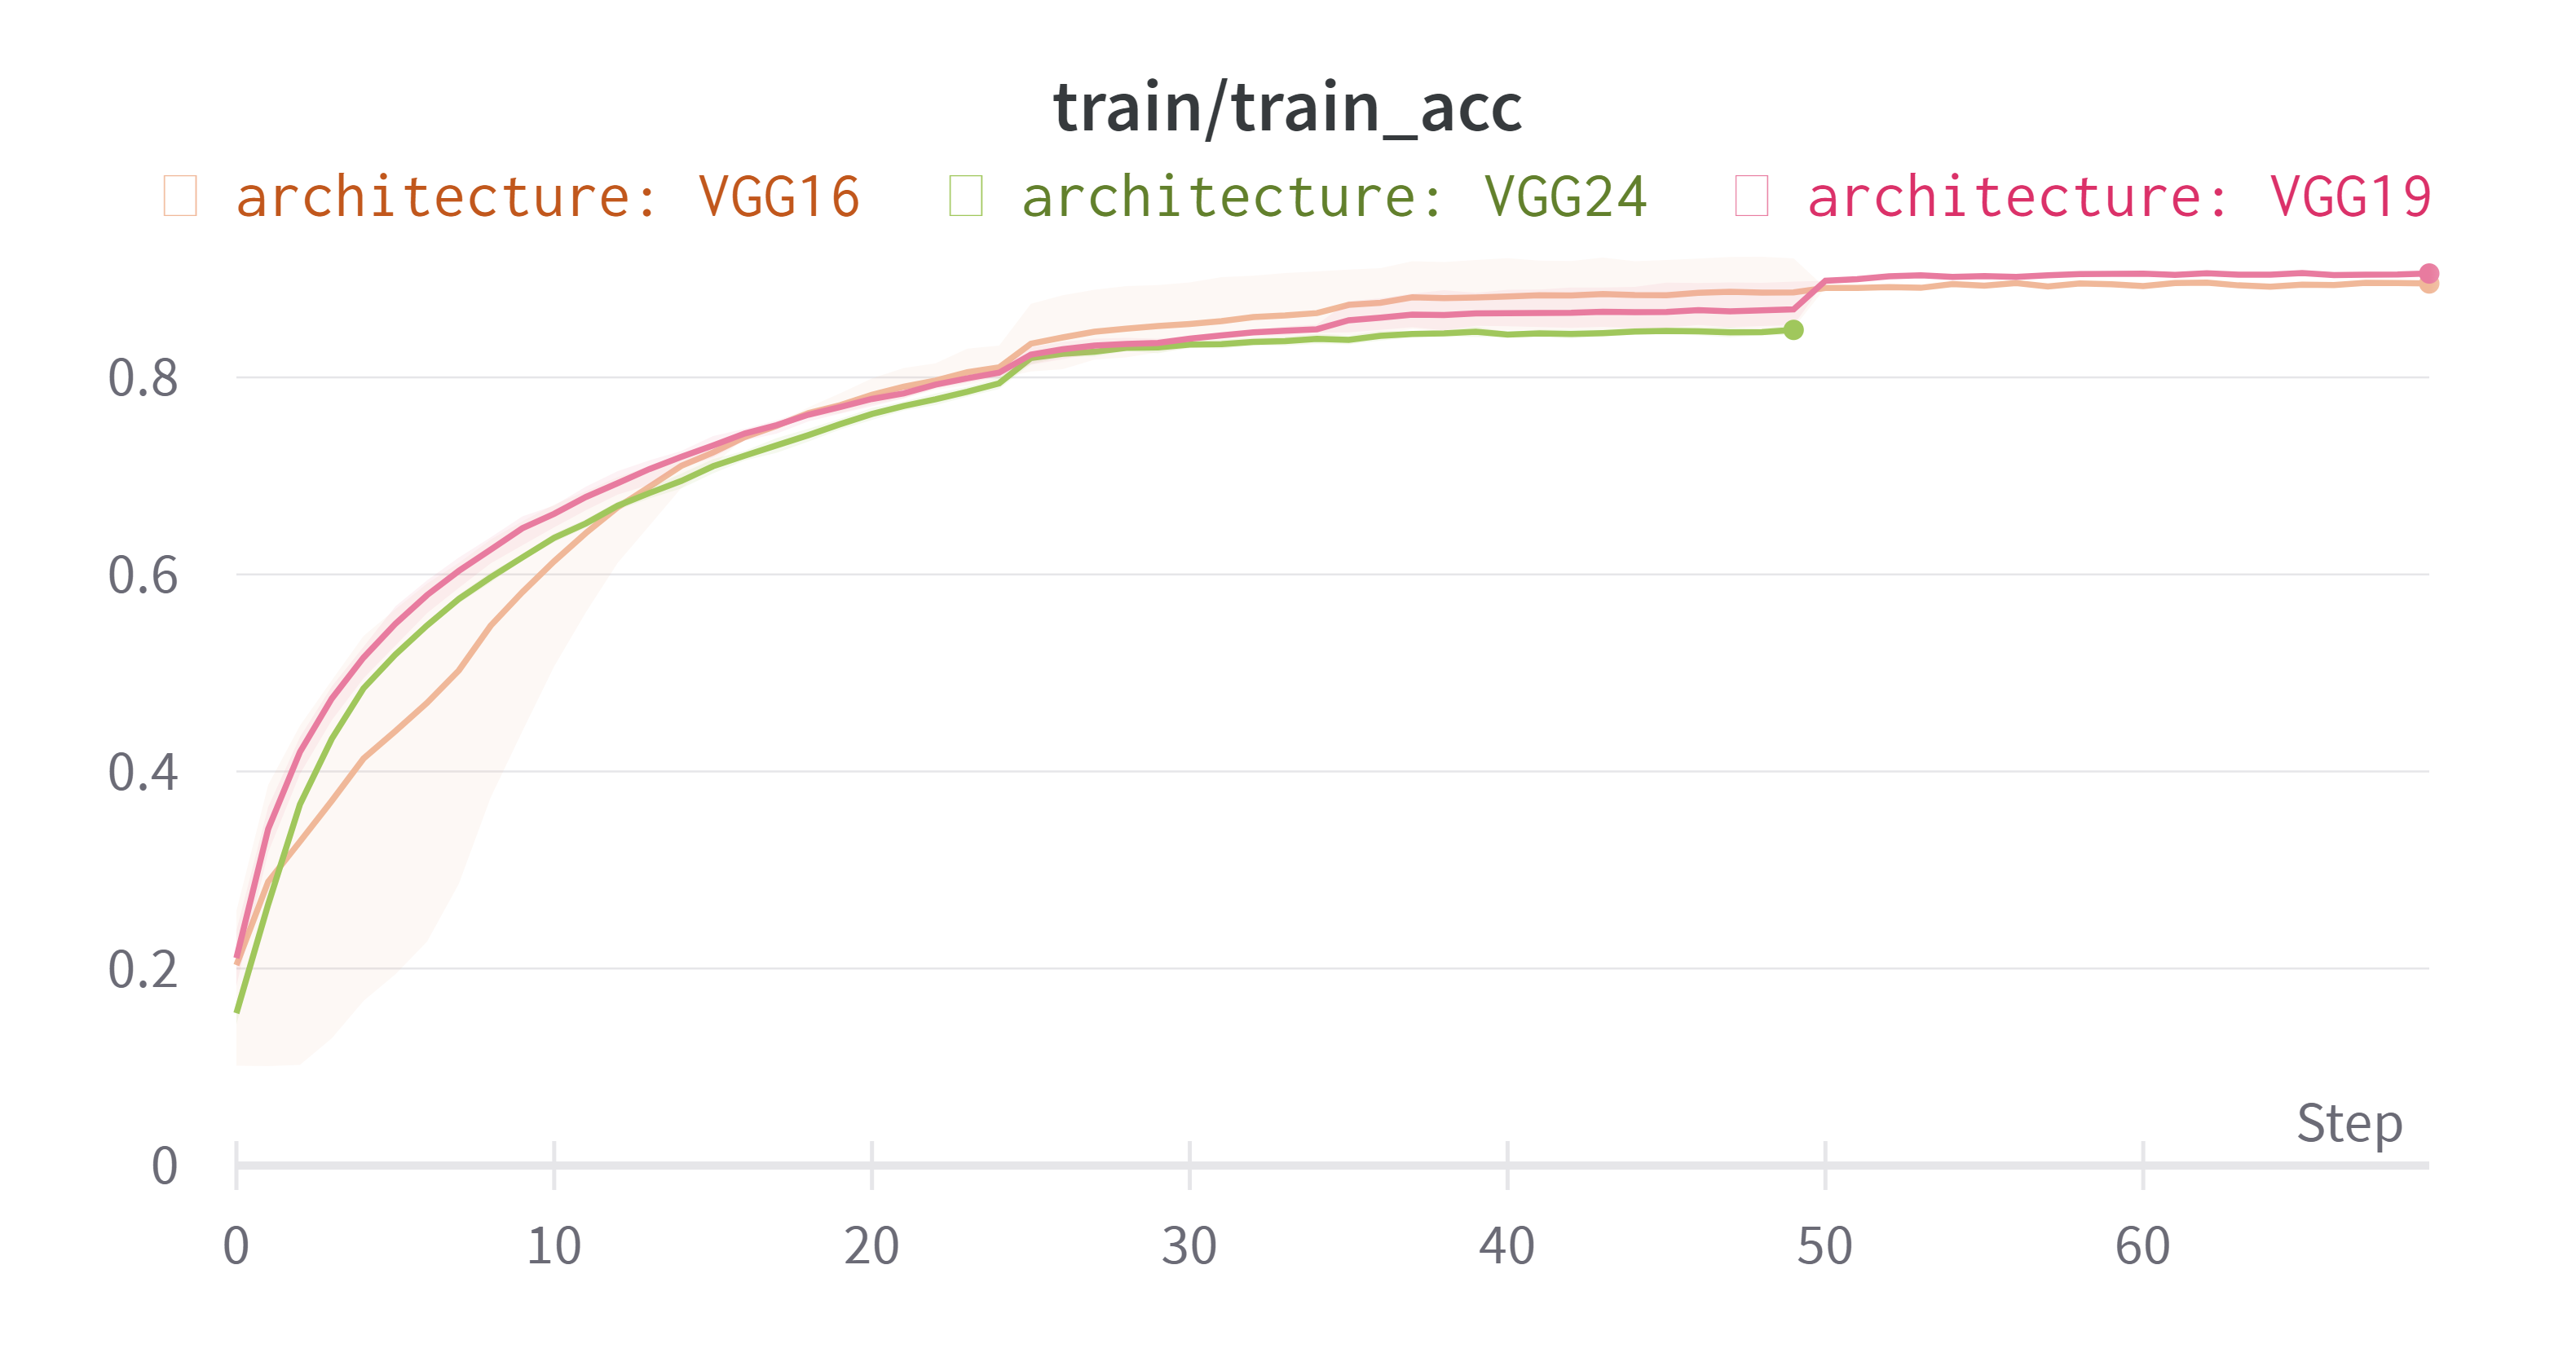

**Train Loss**

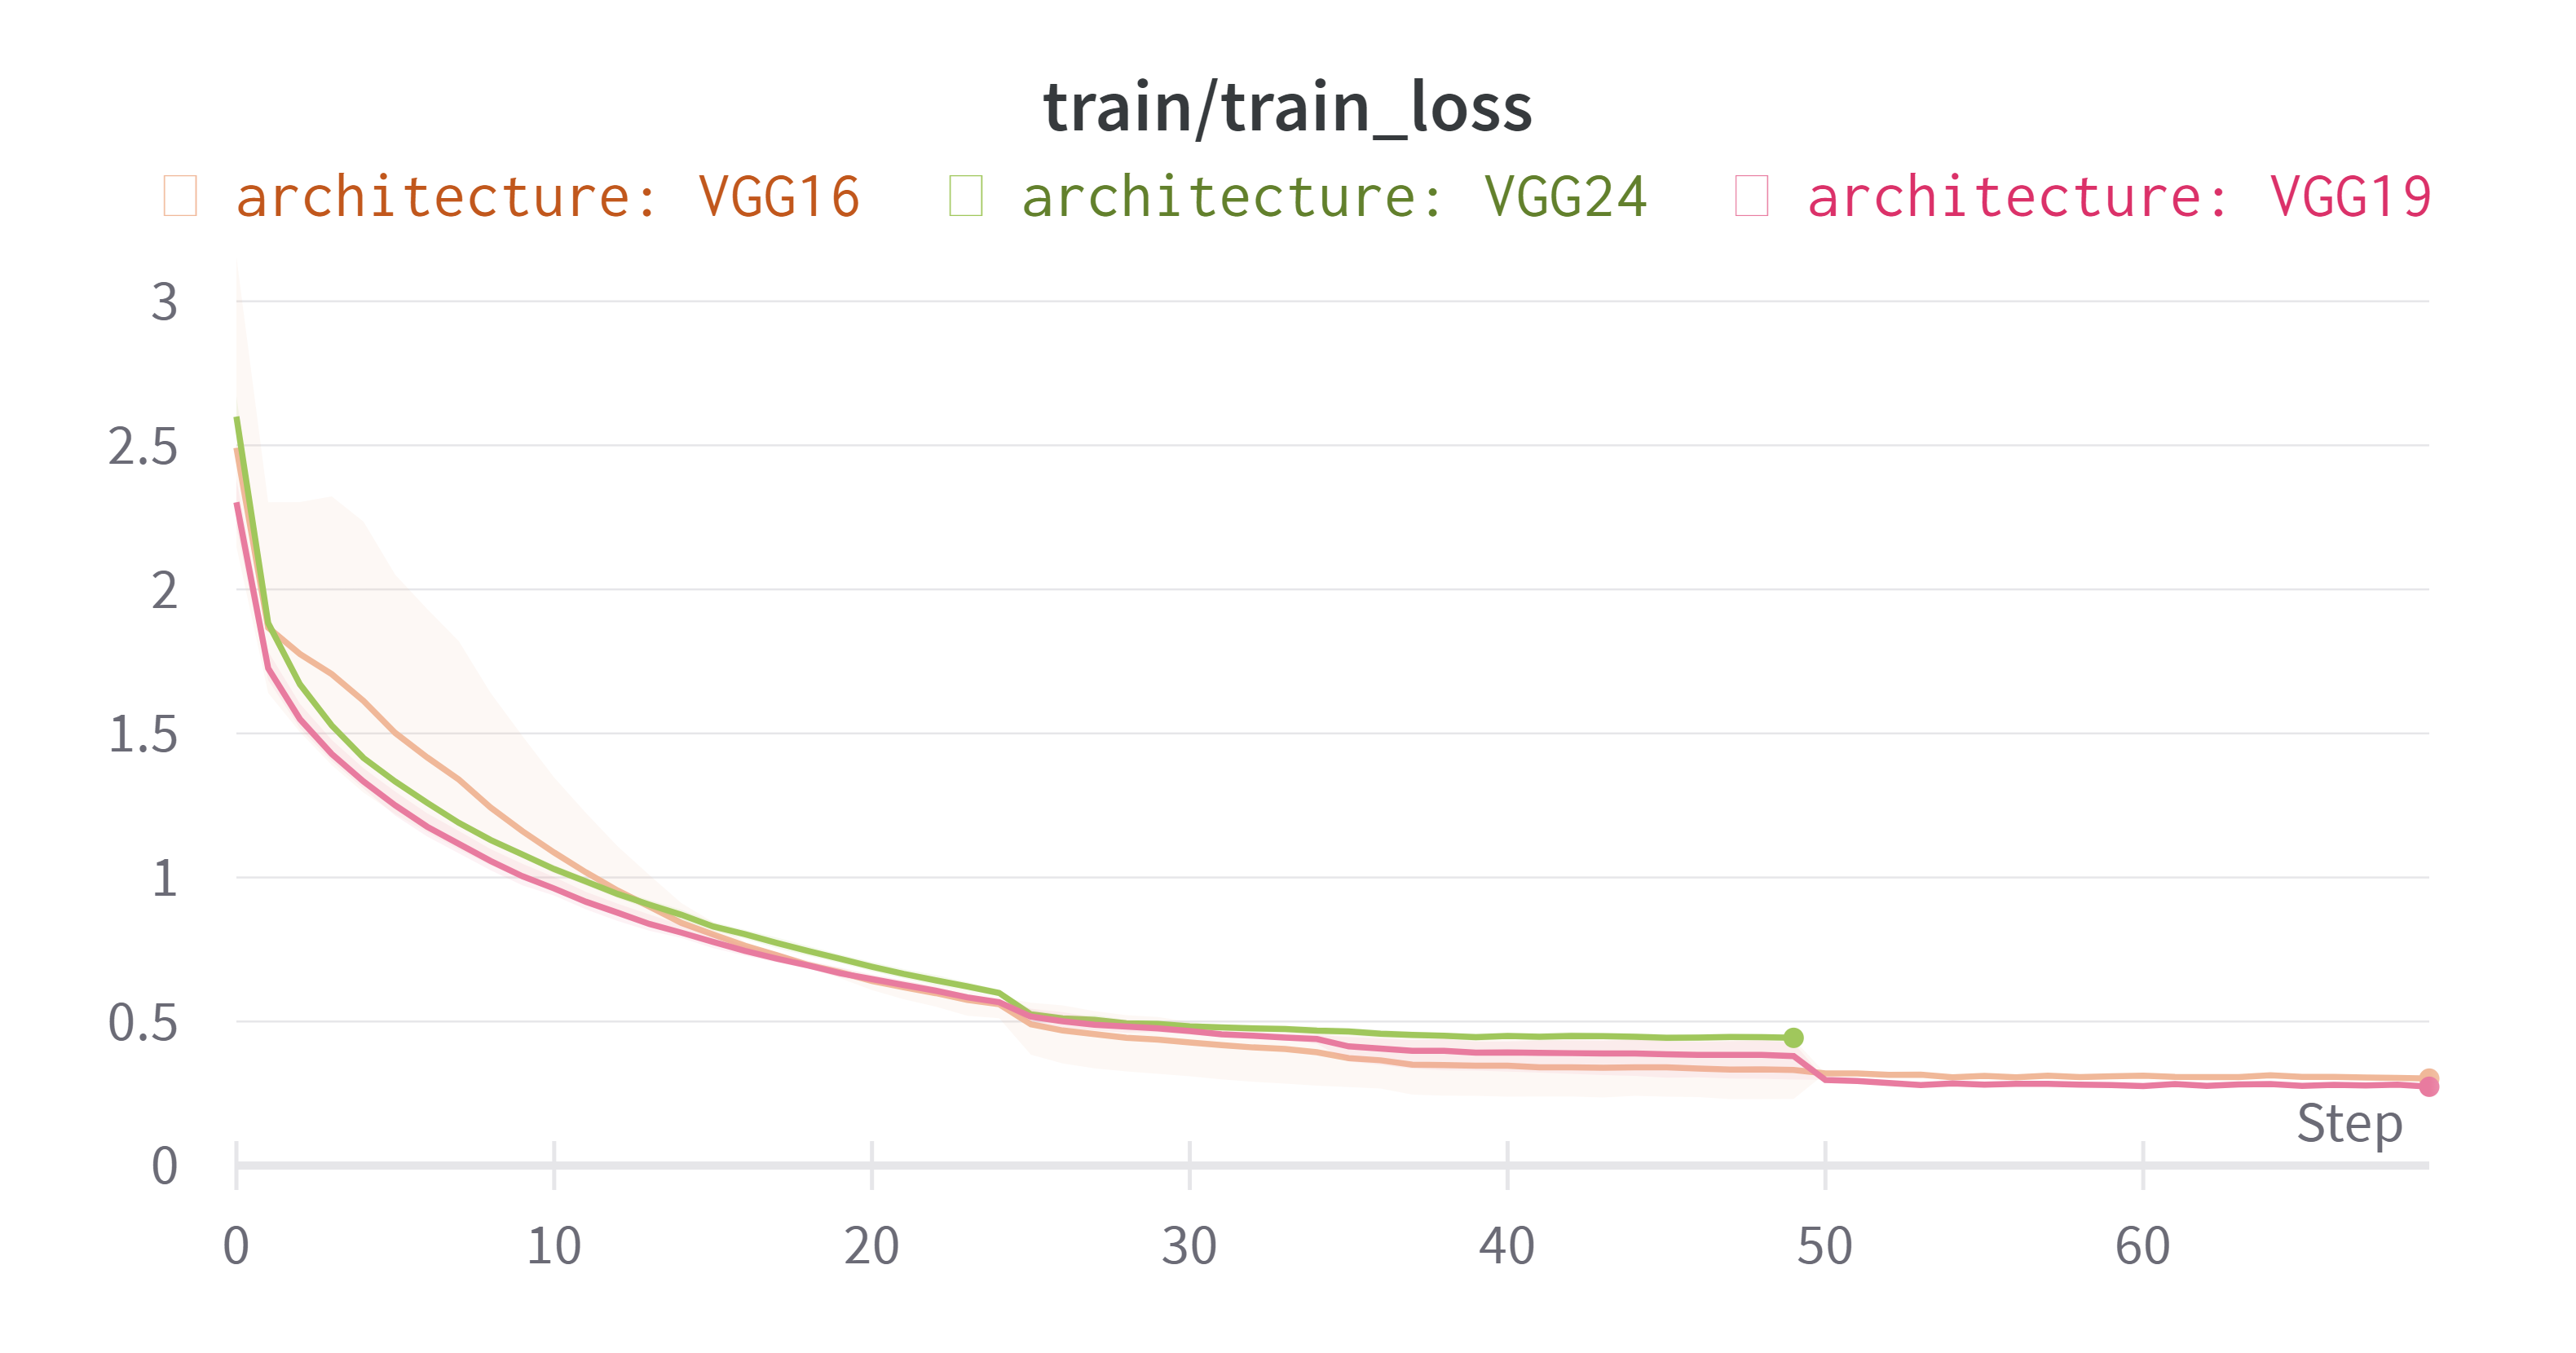

**Val Accuracy**

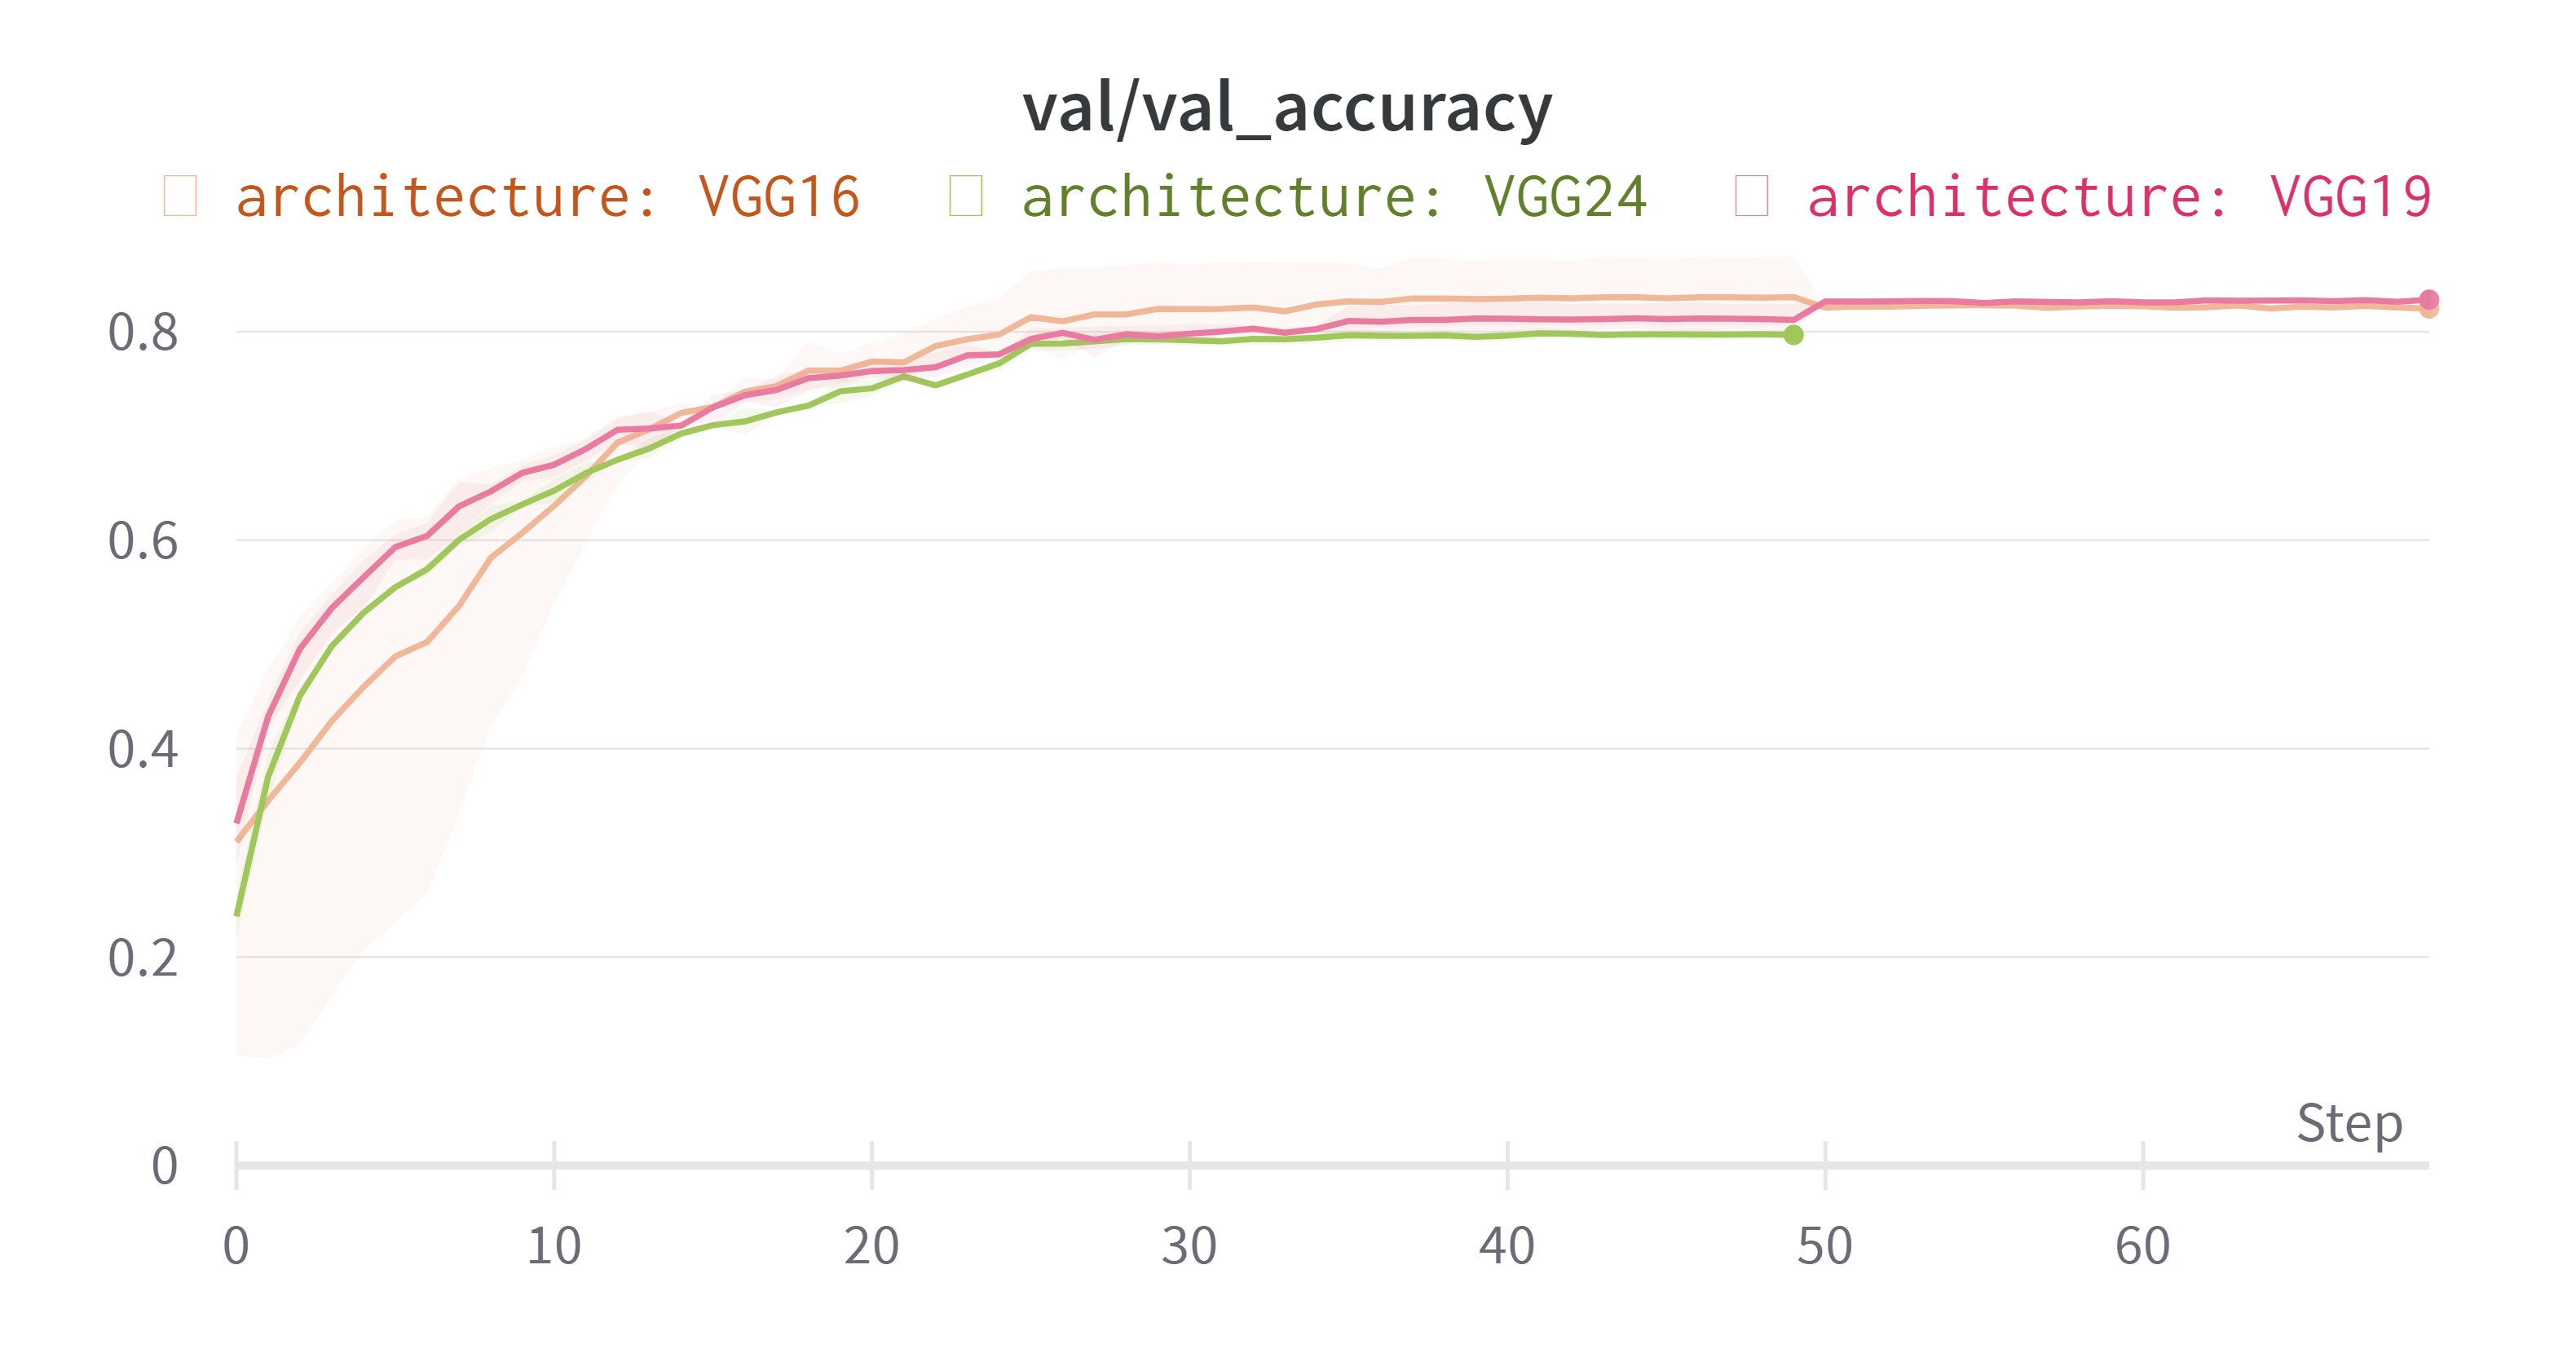

**Val Loss**

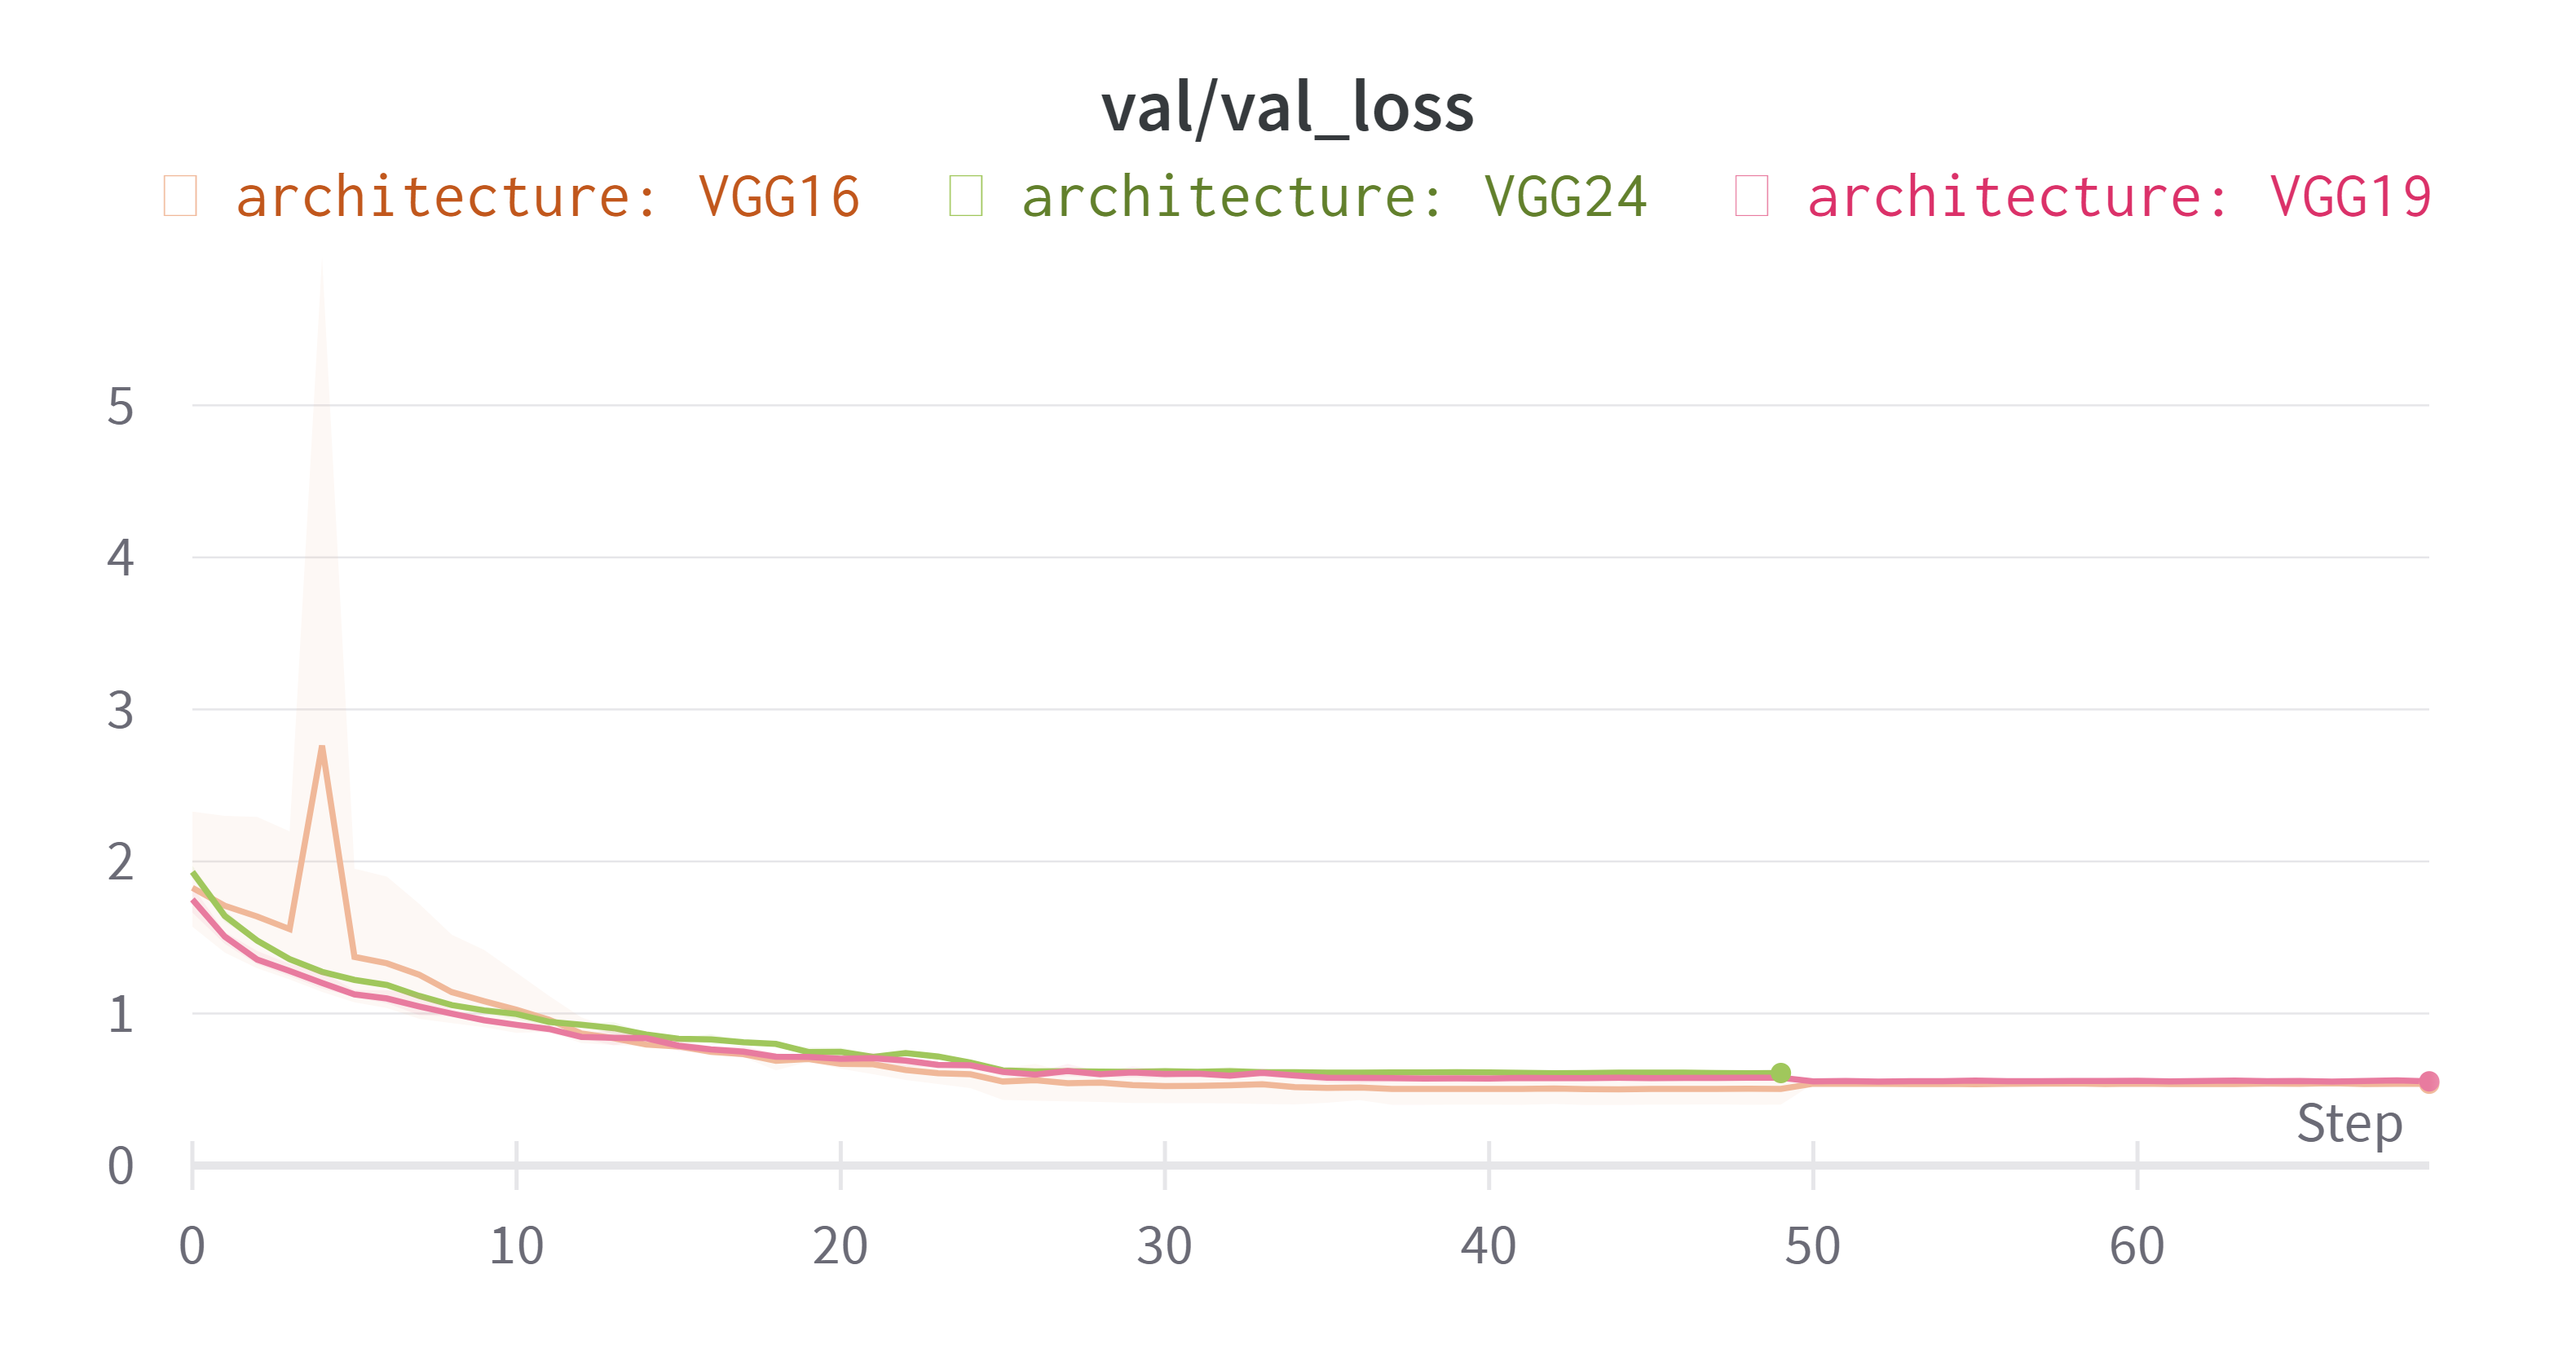

##### 1.2.5.3: ResNet Results

**Compare ResNet**



1.   **Research Question:**
    Does increasing the depth of the ResNet models (ResNet18 vs. ResNet34) have any significant impact on the accuracy?
2. **Obtained Results:**
    After comparing the validation and training curves of ResNet18 and ResNet34, we found that both models achieved high validation revealsaccuracy. The performance ranking is as follows:


    1.   ResNet34
    2.   ResNet18

3. **Interpretation:**
    Experiment 3 reveals that increasing the depth from ResNet18 to ResNet34 has indeed improved the model's performance. This finding aligns with the inherent advantage of residual connections in ResNet, allowing it to leverage deeper architectures effectively without suffering from accuracy degradation. The performance gain observed in ResNet34 demonstrates the importance of adding more layers to enhance the model's capacity to learn complex patterns.





**Train Accuracy**

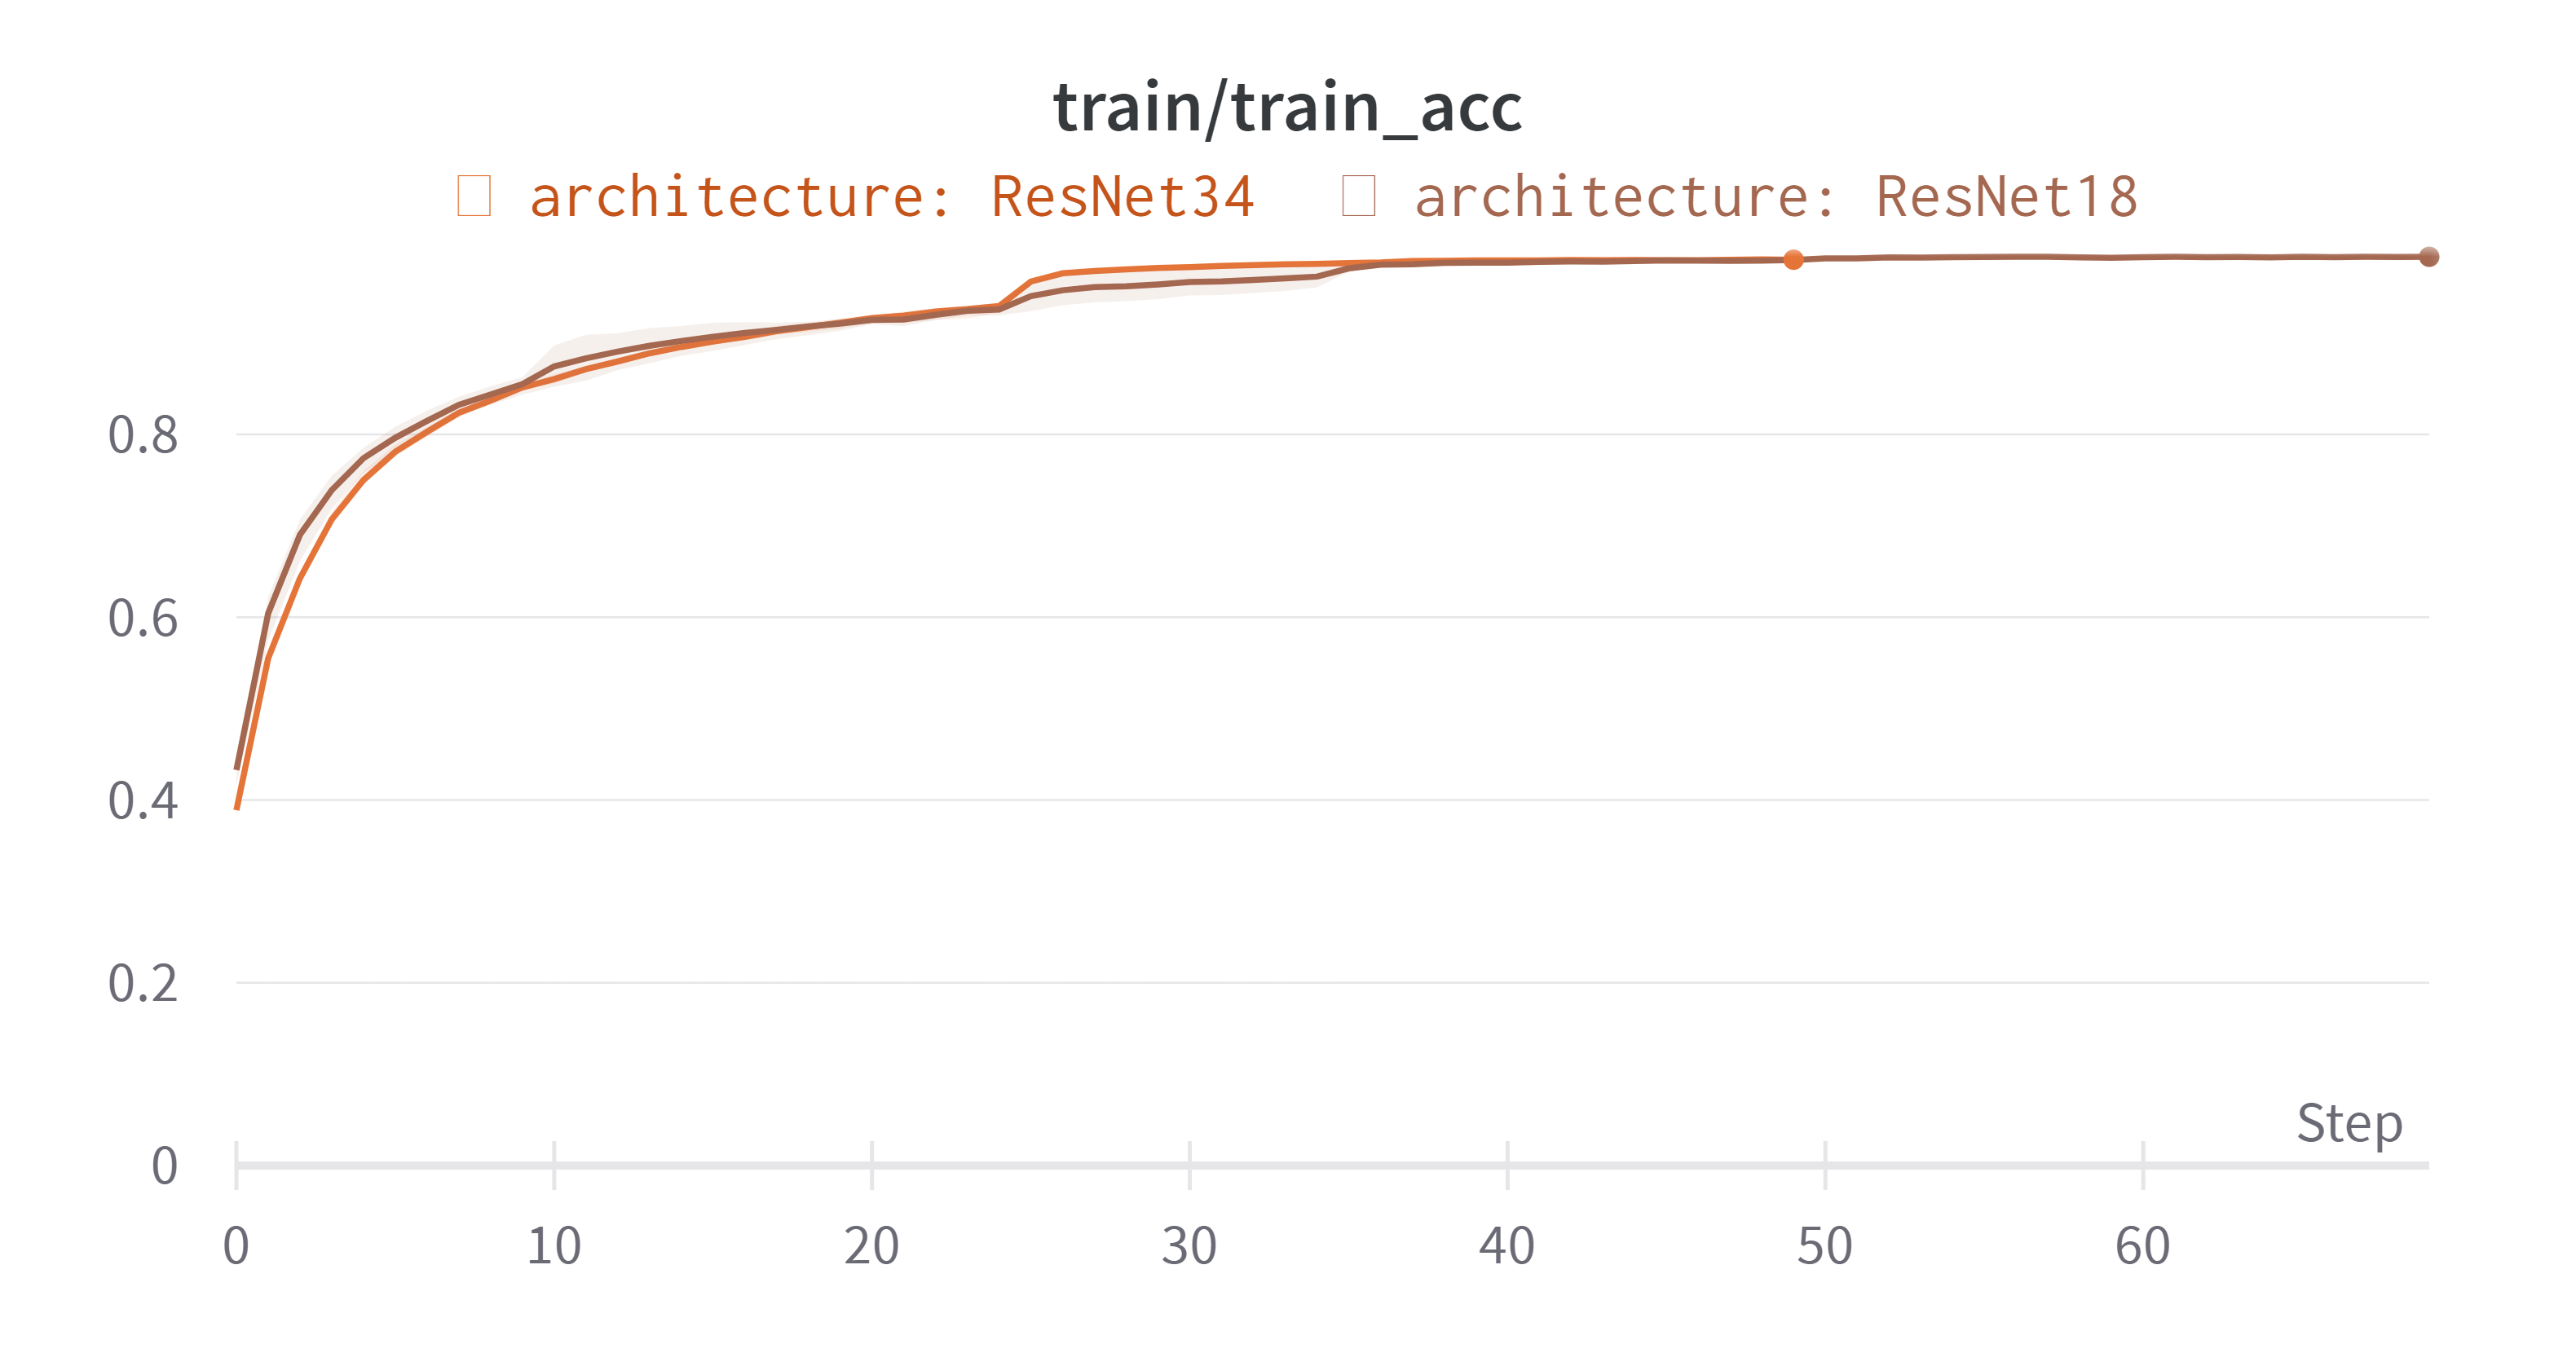

**Train Loss**

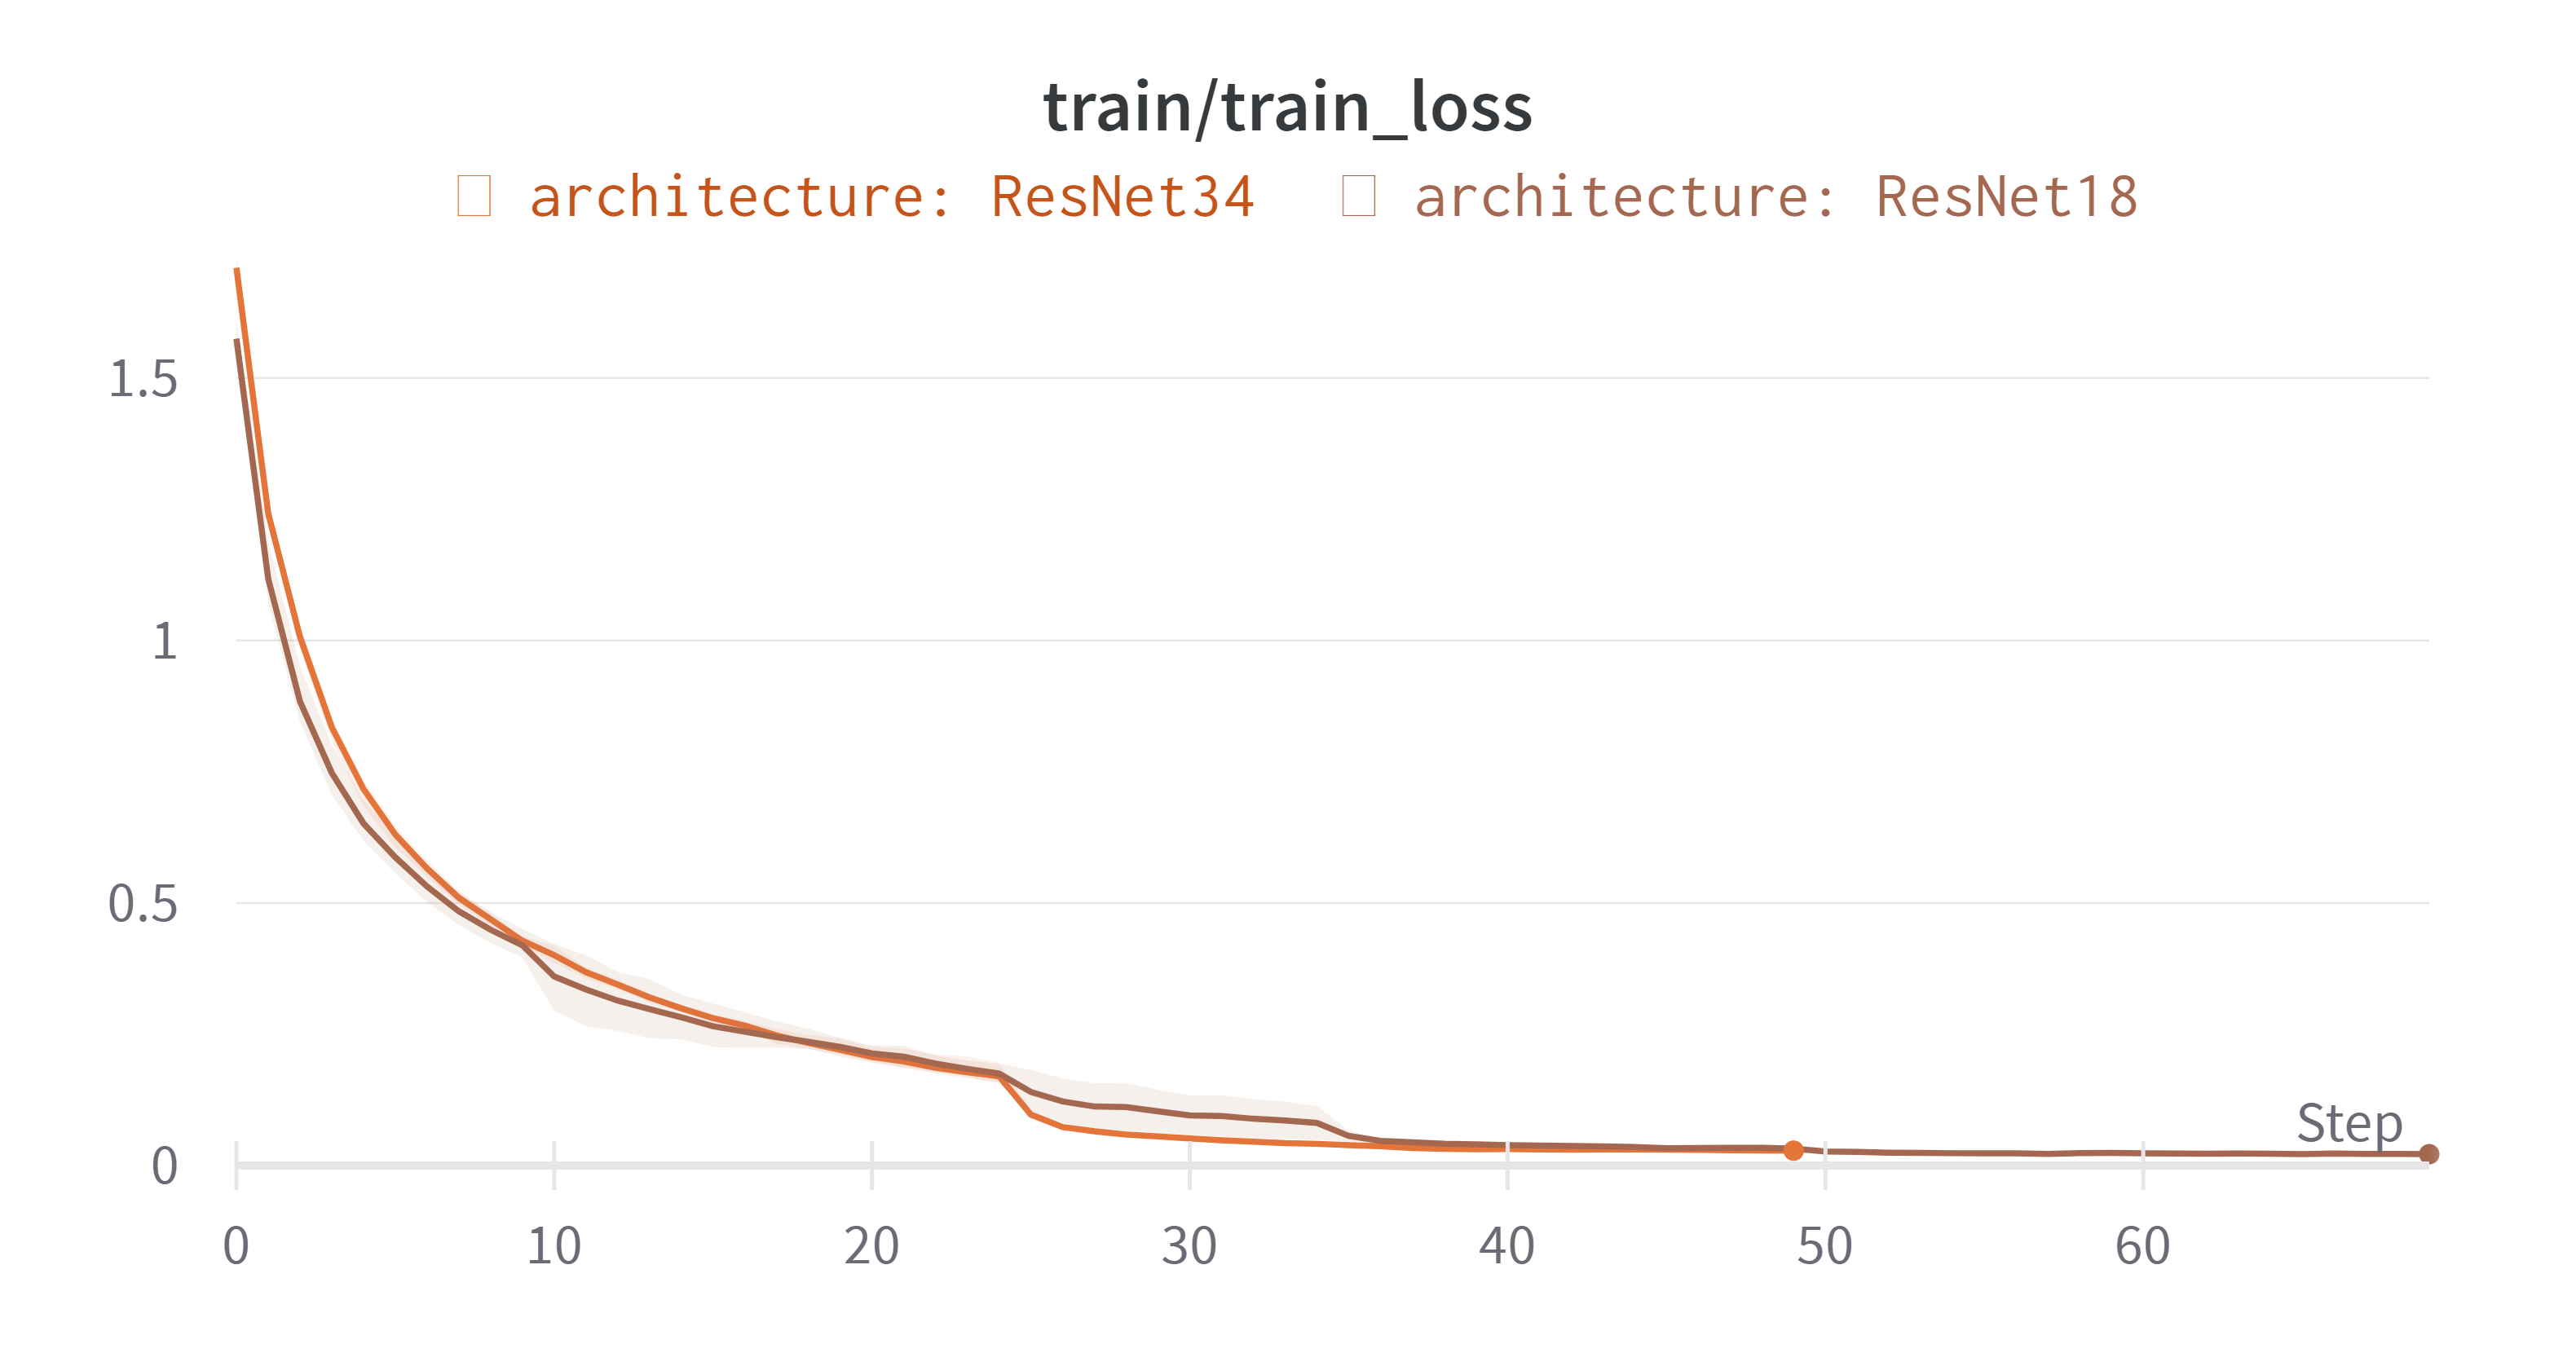

**Val Accuracy**

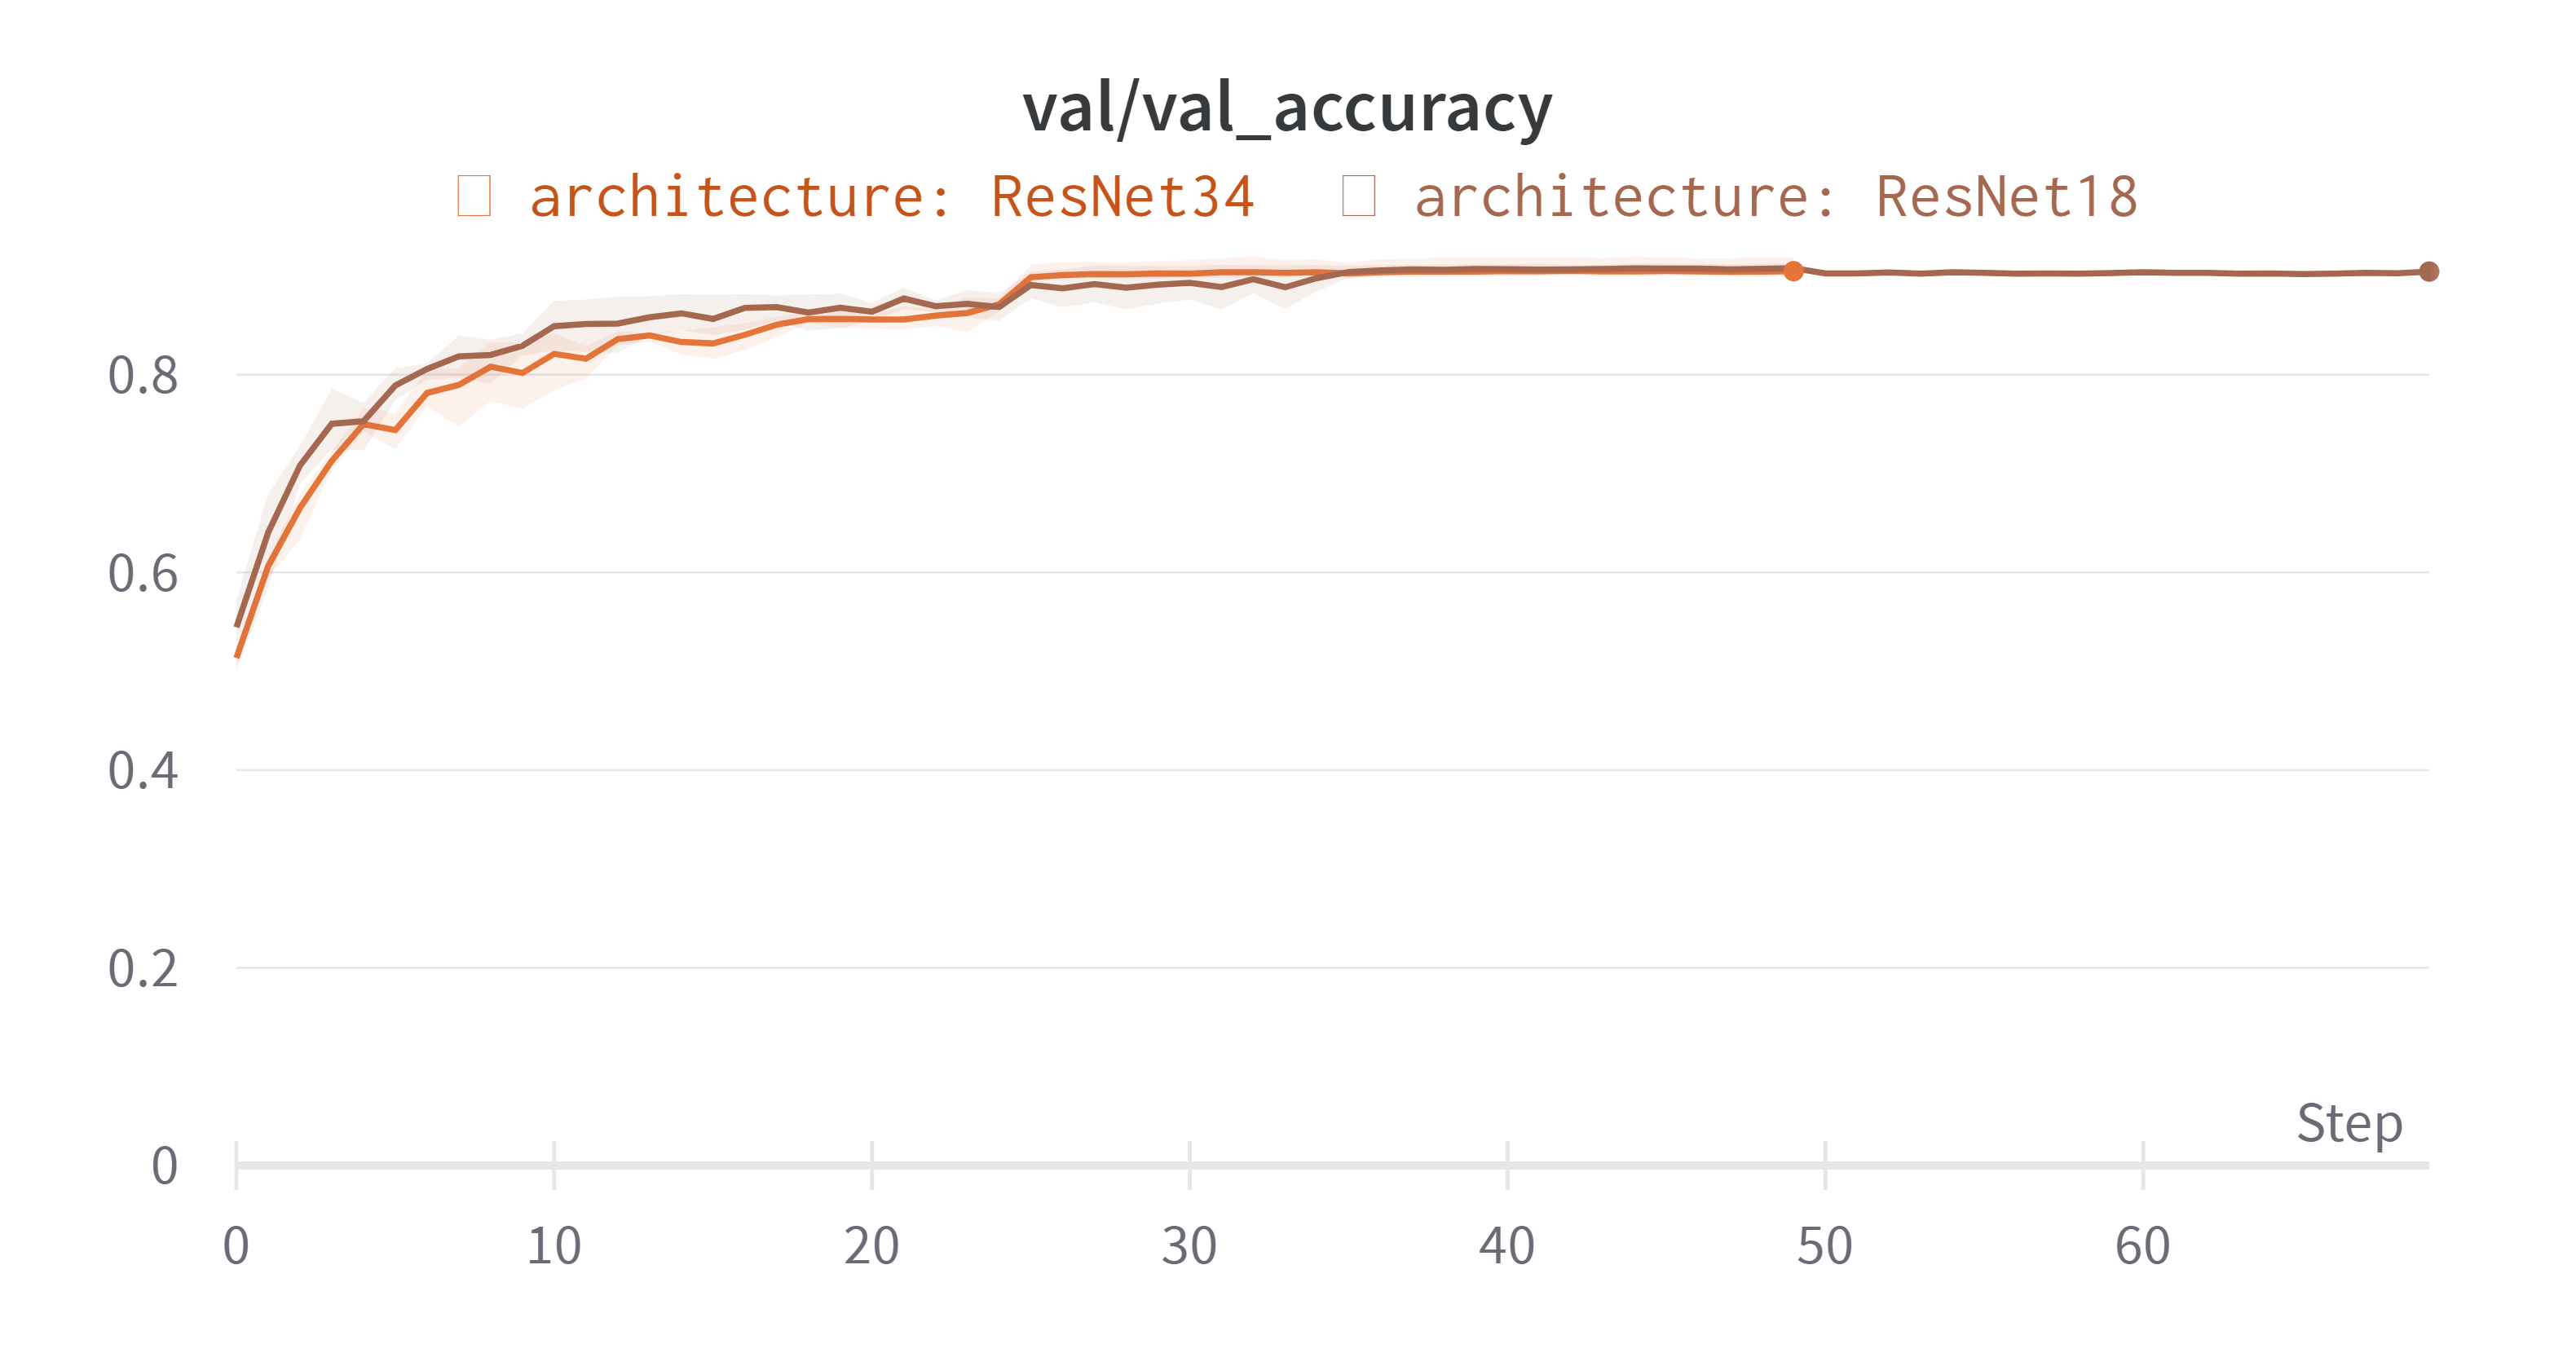

**Val Loss**

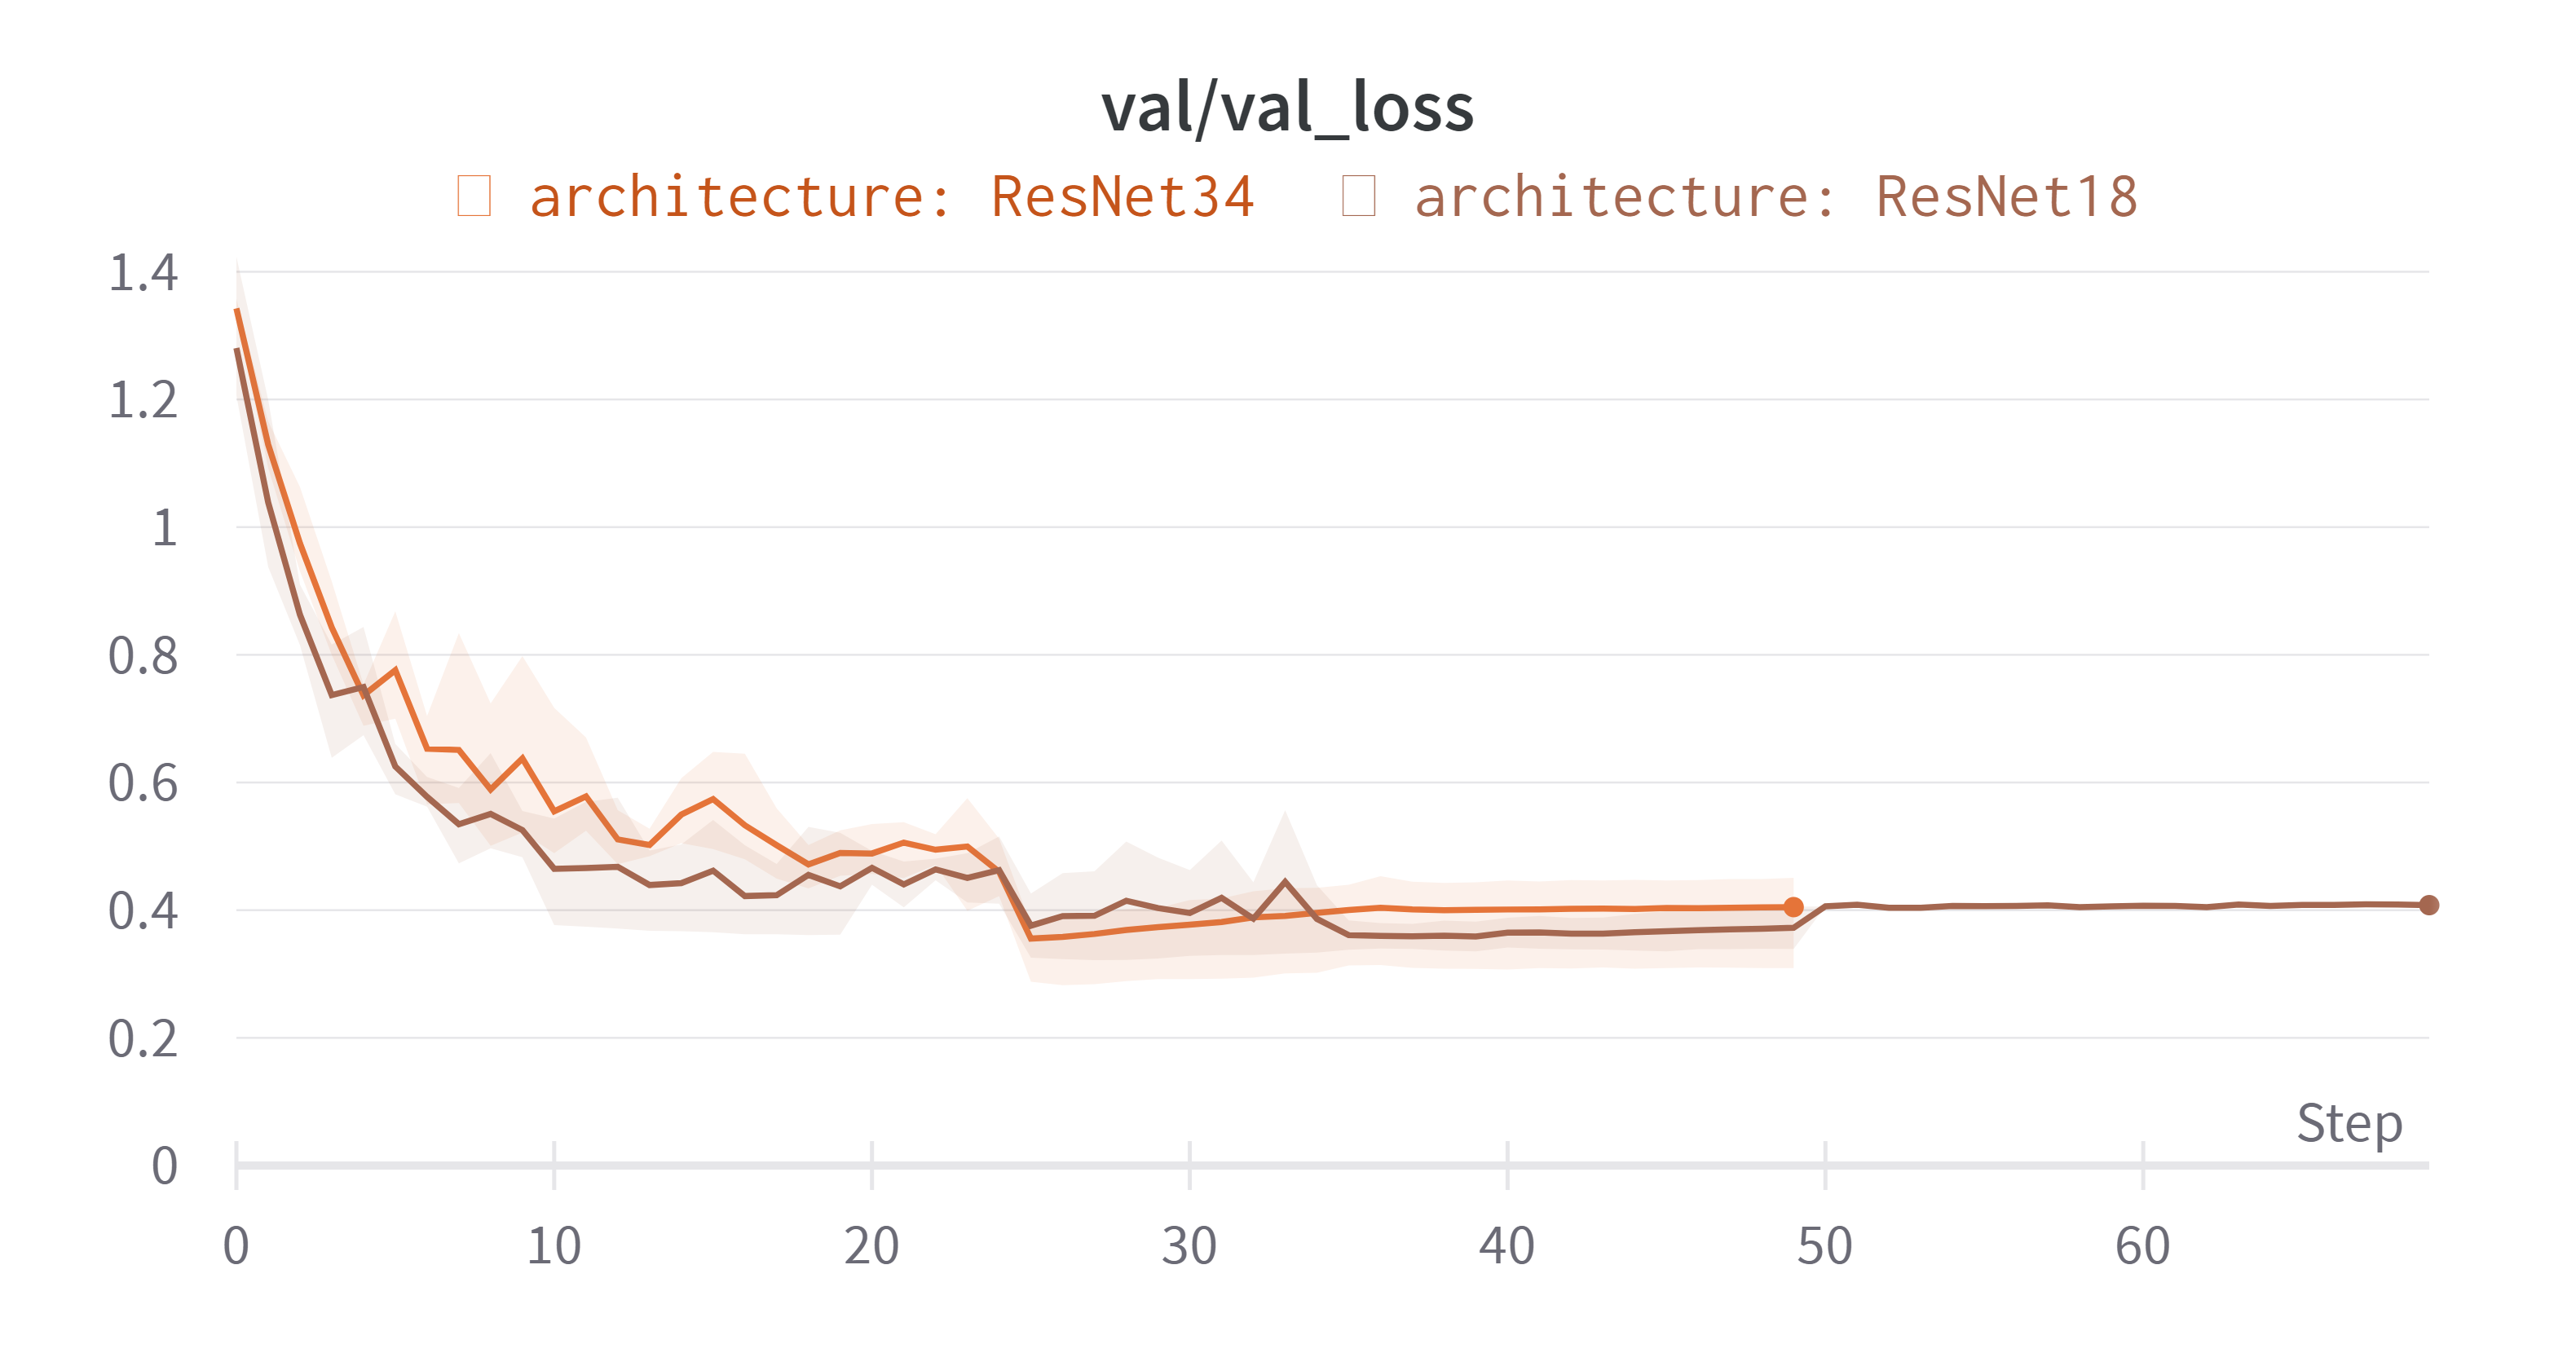

Overall, these experiments demonstrate the superiority of ResNet architectures over VGG in handling deep networks. ResNet's residual connections enable it to maintain or improve accuracy as depth increases, while VGG struggles to cope with the increased depth, leading to accuracy degradation.

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

**1) Research Question**

   Why does ResNet34 outperform VGG16 in terms of accuracy? How do the gradients and parameters behave in both architectures?

**2) Obtained Results**


1.   **Gradients in ResNet**:

 The gradients in ResNet34 are stable and consistent at different layers, even in the deep layers. They do not suffer from vanishing gradients, which is crucial for successful training in deep networks.

2.   **Gradients in VGG**:

 The gradients in VGG16, especially in deeper layers, tend to be less stable and can sometimes suffer from the vanishing gradient problem. This instability may hinder the learning process and result in slower convergence.

3.  **Parameters in ResNet**:

 The parameters in ResNet34 are relatively stable throughout different layers. The stability of parameters suggests that the model is learning effectively, and there are no significant issues with the optimization process.

4. **Parameters in VGG**:

 In VGG16, the parameters show more sparsity, and in certain layers, they tend to diverge. The sparsity indicates that certain connections may not be contributing effectively to the model's learning. The divergence in parameters suggests instability in optimization and may hinder the model's convergence.

**3) Interpretation**

1.  **Stable Gradients in ResNet**:

 The stable gradients in ResNet34 enable efficient backpropagation of errors through the network, allowing the model to effectively learn from the data, even in deeper layers. This stability is a key factor in the success of ResNet.

2. **Vanishing Gradients in VGG**:

 The less stable gradients in VGG16, especially in deeper layers, indicate a higher likelihood of vanishing gradients. This phenomenon makes it challenging for the model to learn meaningful representations in the deeper layers and leads to slower convergence.

3. **Parameter Stability in ResNet**:

 The stable parameters in ResNet34 suggest that the model is consistently learning from the data and converging towards the optimal solution. This stability is crucial for the model to make meaningful adjustments during training.

4. **Parameter Sparsity and Divergence in VGG**:

  The parameter sparsity in VGG16 implies that certain connections may not be effectively contributing to the learning process, limiting the model's capacity to capture complex patterns. The divergence in parameters indicates instability in the optimization process, which can hinder the model's ability to converge and generalize well.


  In summary, the superior performance of ResNet34 over VGG16 can be attributed to the stability of gradients and parameters in ResNet, allowing it to effectively handle deeper architectures without suffering from accuracy degradation. The vanishing gradients and parameter instability in VGG16 impede its ability to learn efficiently in deeper layers, leading to decreased accuracy.


### 2.1.1: Gradient Analysis

To obtain the previous results I first conducted an analysis of the gradients both for ResNet and for VGG.



**VGG**

The observation of gradients approaching zero and being very sparse in VGG is concerning and points to the presence of the vanishing gradient problem. When gradients become too small, they effectively diminish as they propagate backward through the layers during training. As a result, layers towards the beginning of the network may not receive sufficiently informative updates, hindering their ability to learn and adapt to the data. Consequently, this vanishing gradient issue can severely limit the capacity of VGG to capture complex features and may lead to decreased accuracy, particularly in deeper layers.

The presence of very sparse gradients further exacerbates the vanishing gradient problem in VGG. Sparse gradients suggest that certain connections within the network are rarely updated during training. This sparsity can prevent crucial information from being effectively propagated throughout the network, causing information loss and impeding the learning process. Sparse gradients can also result in longer convergence times, as the model may require more iterations to adapt its parameters properly.


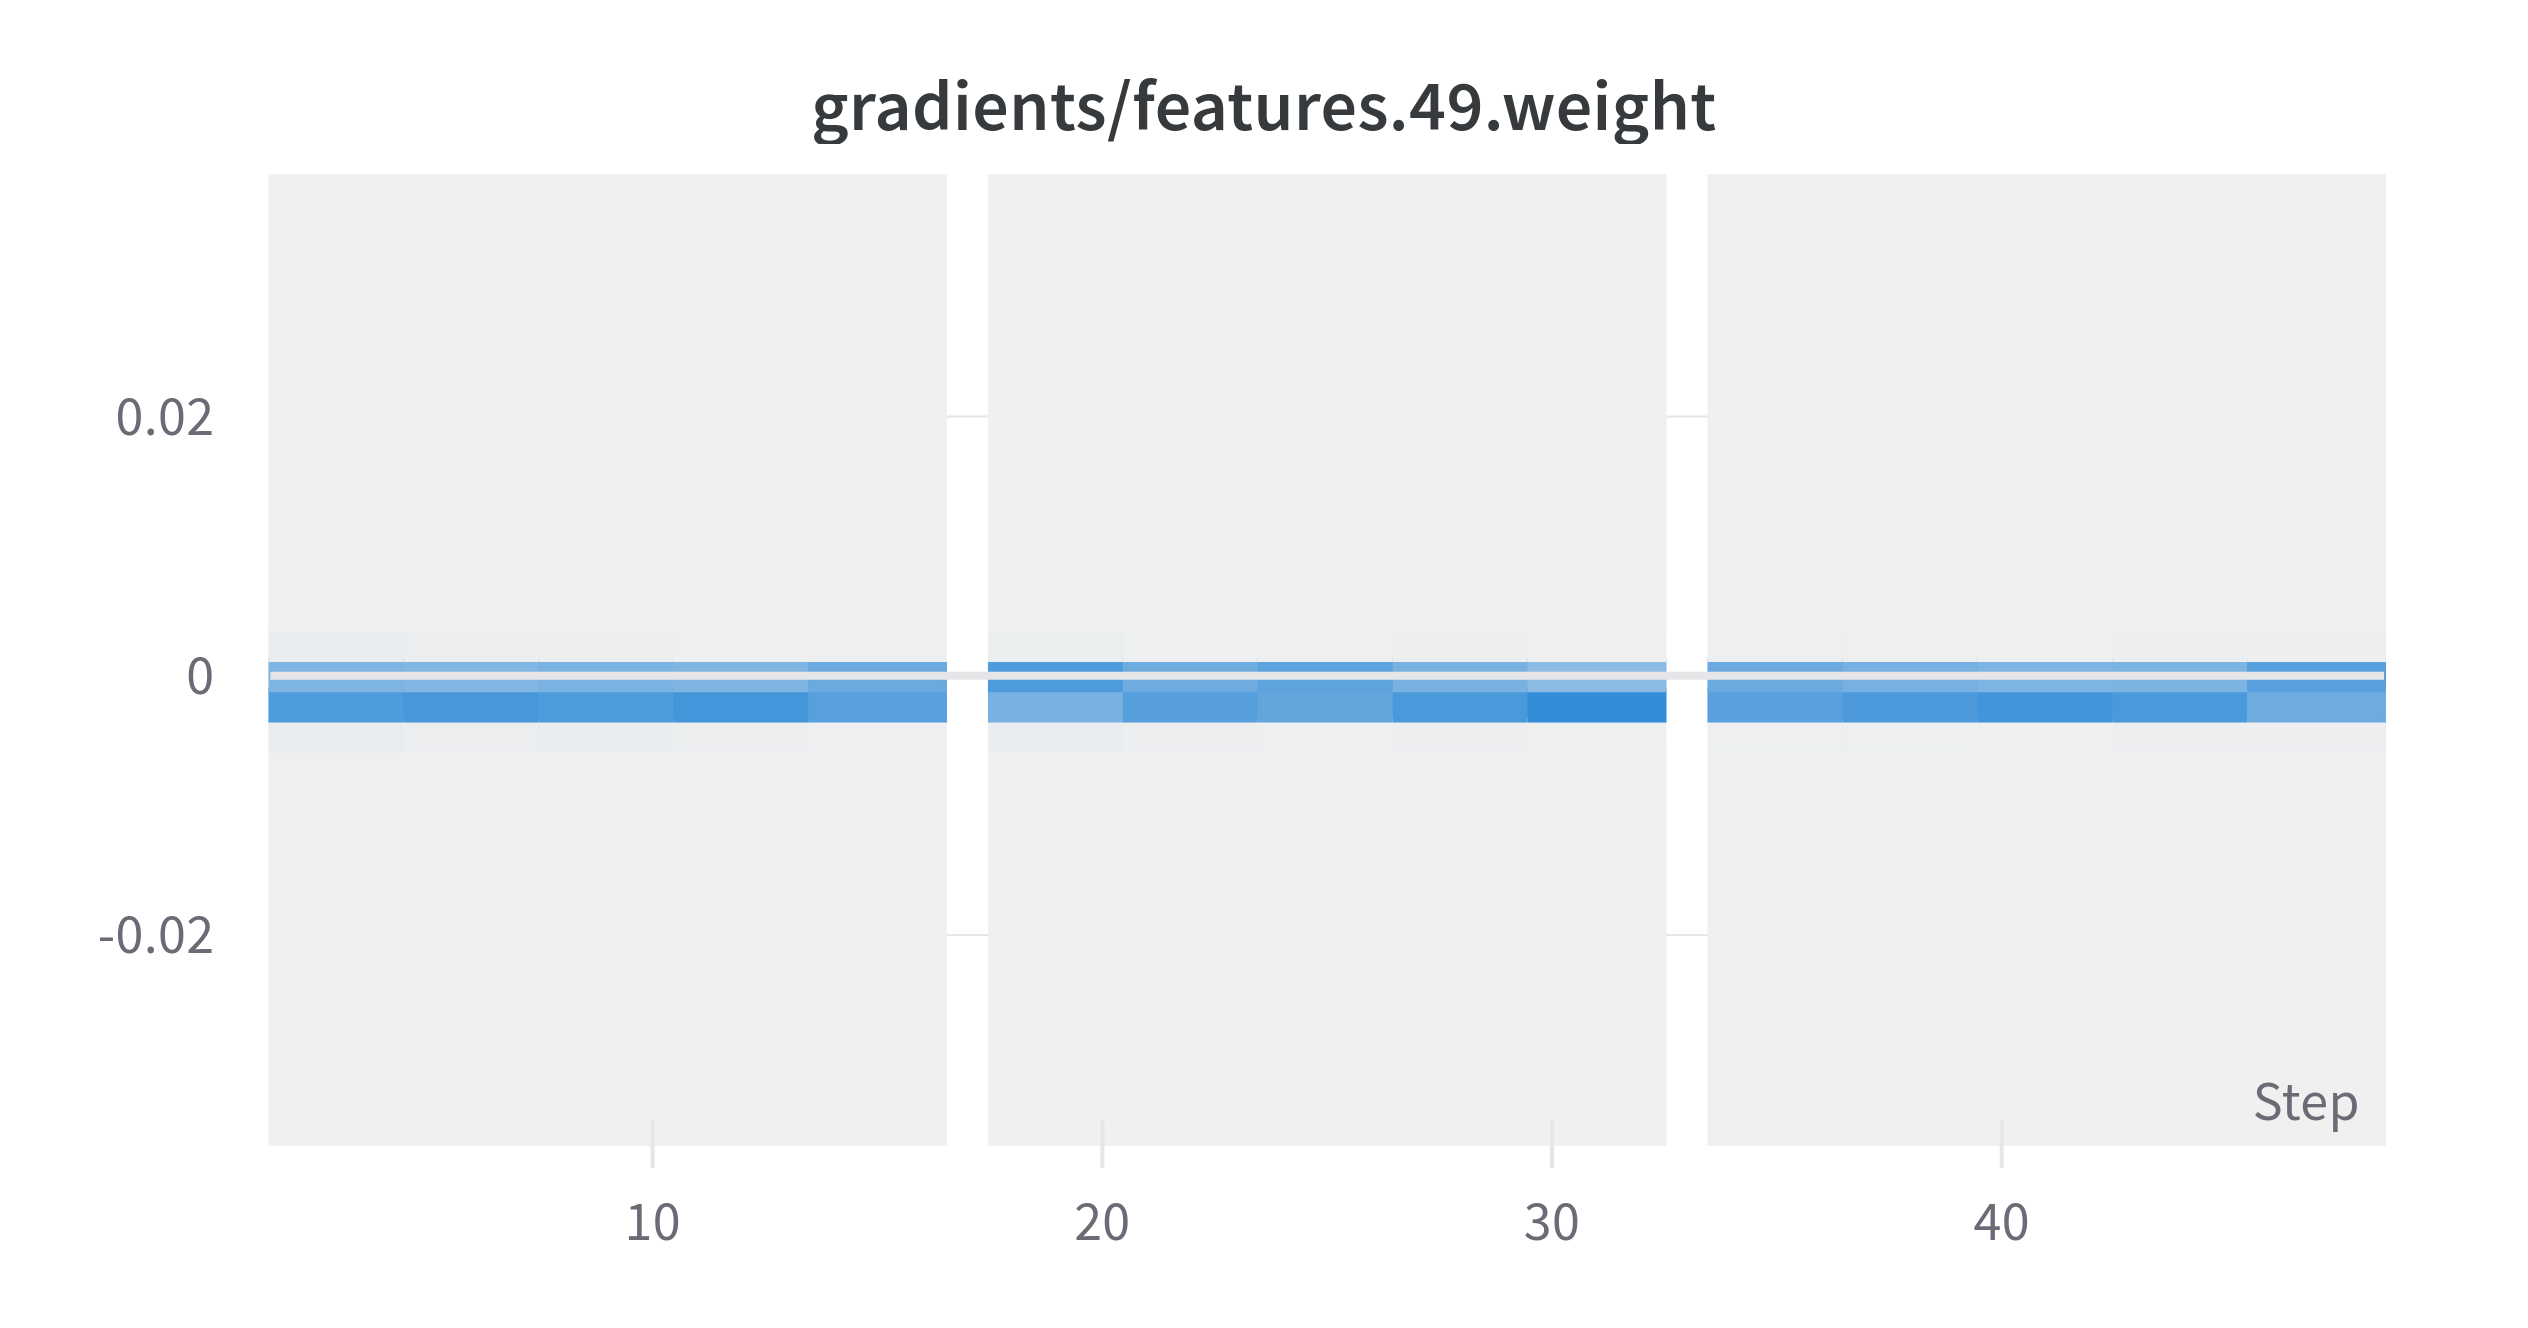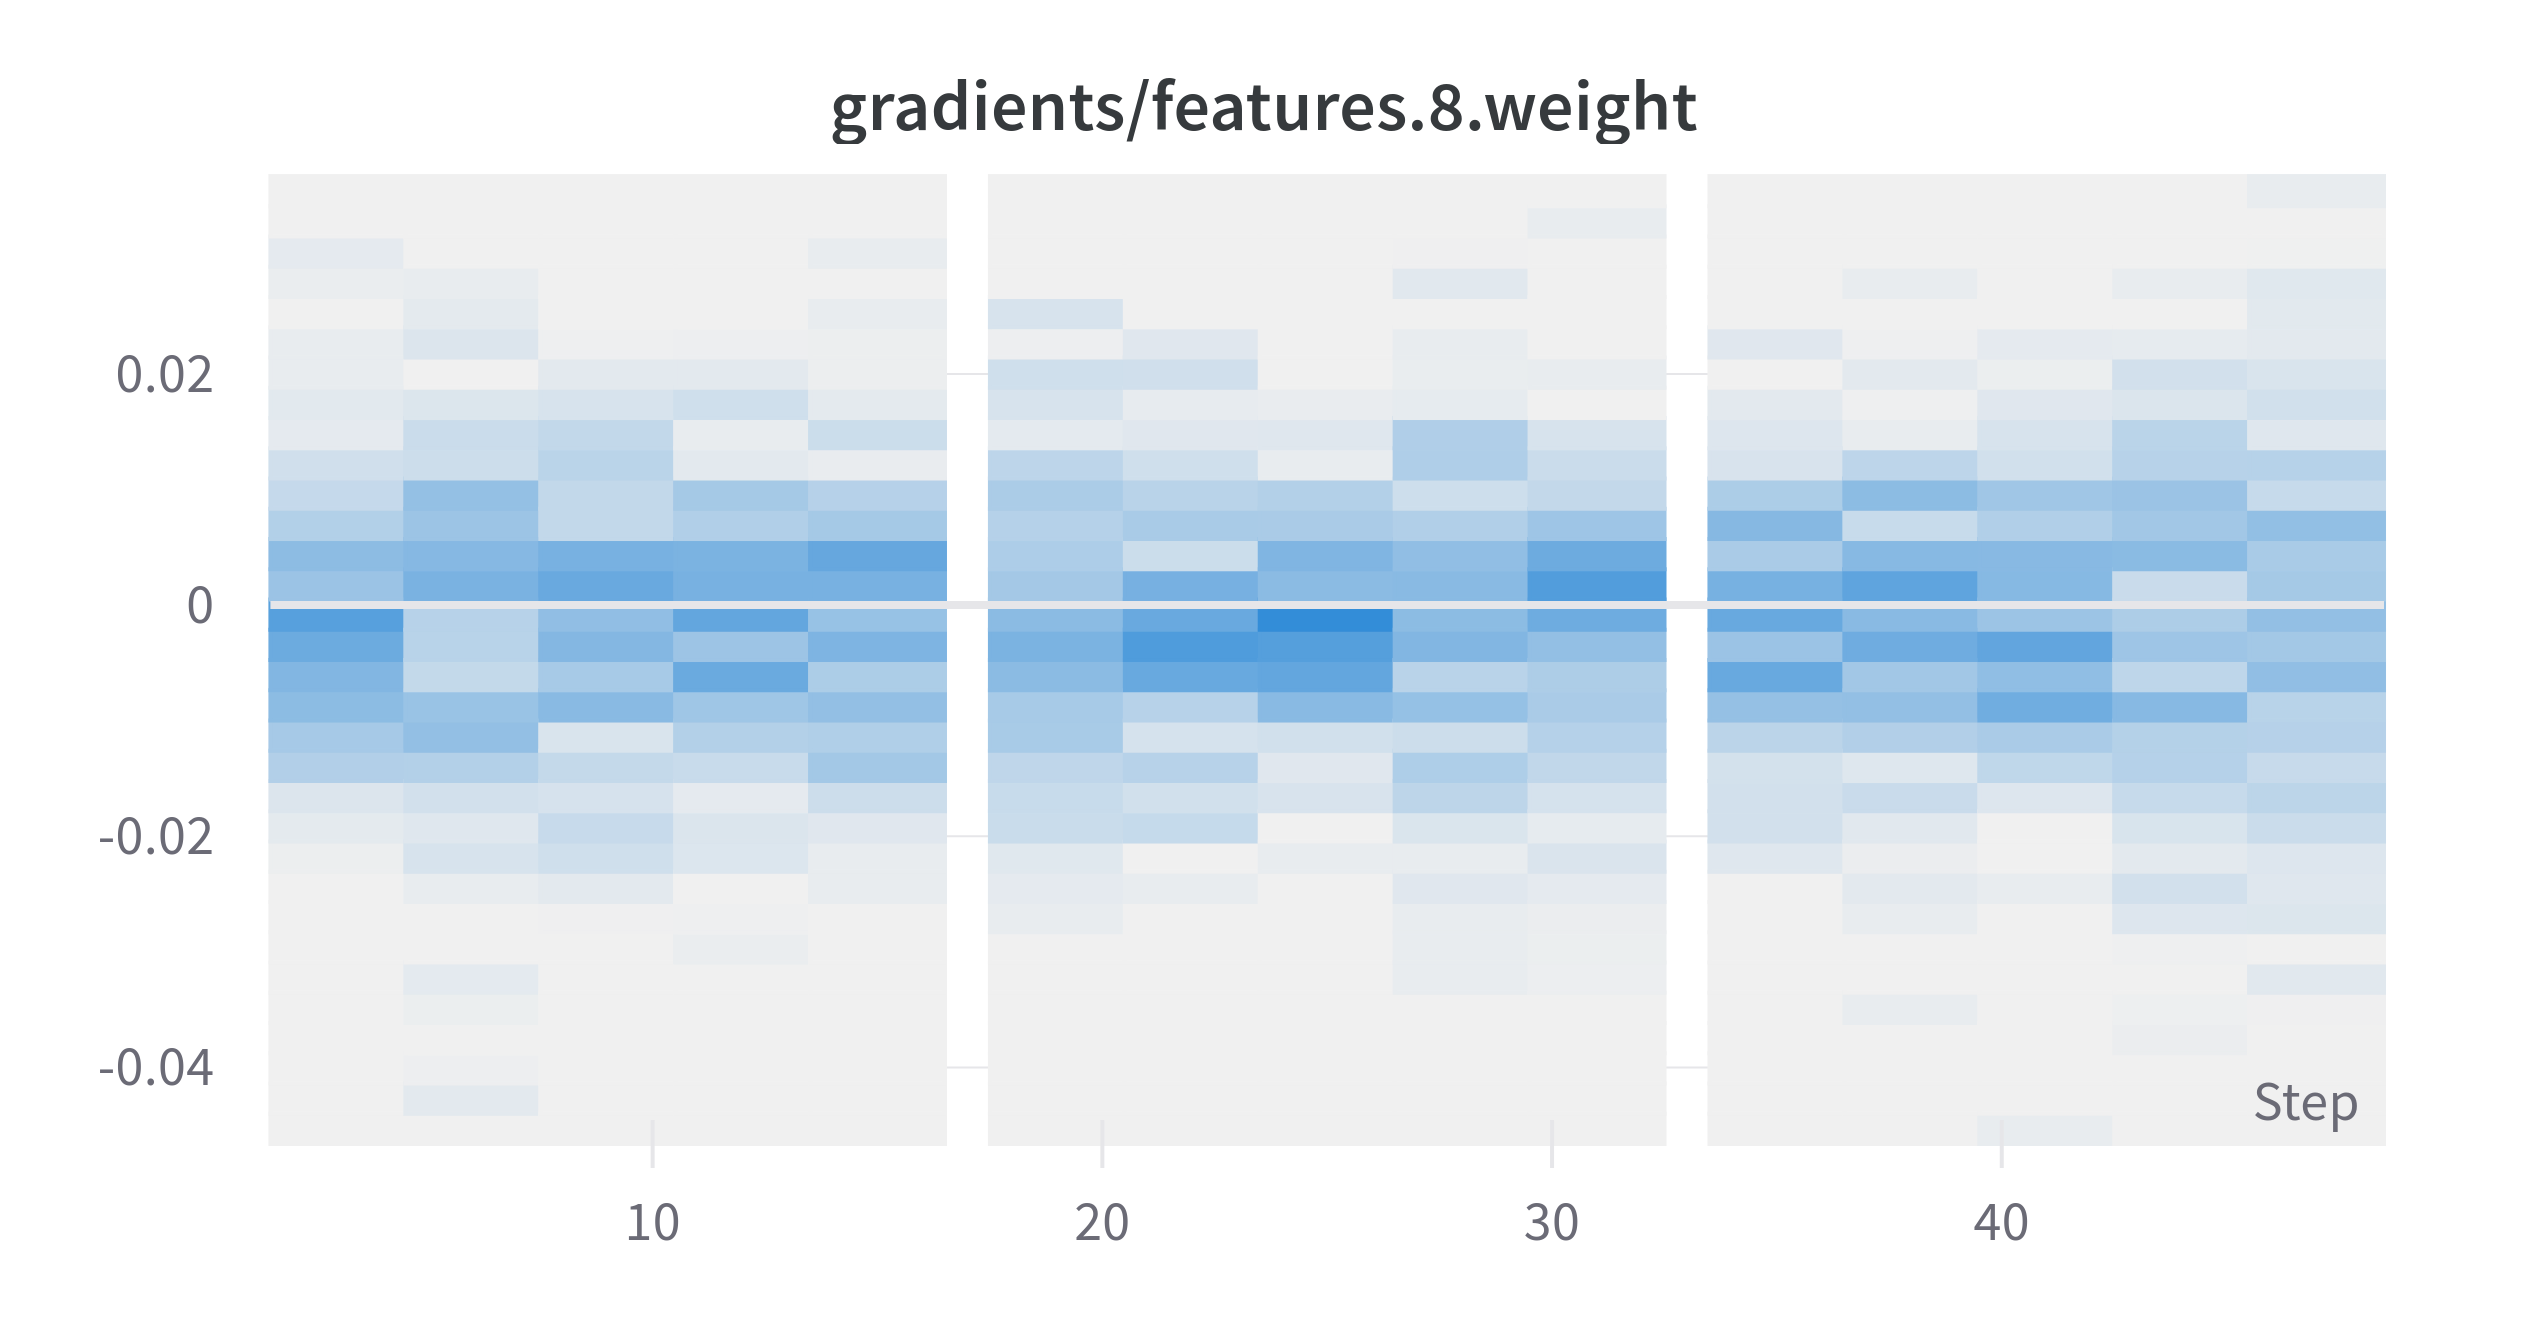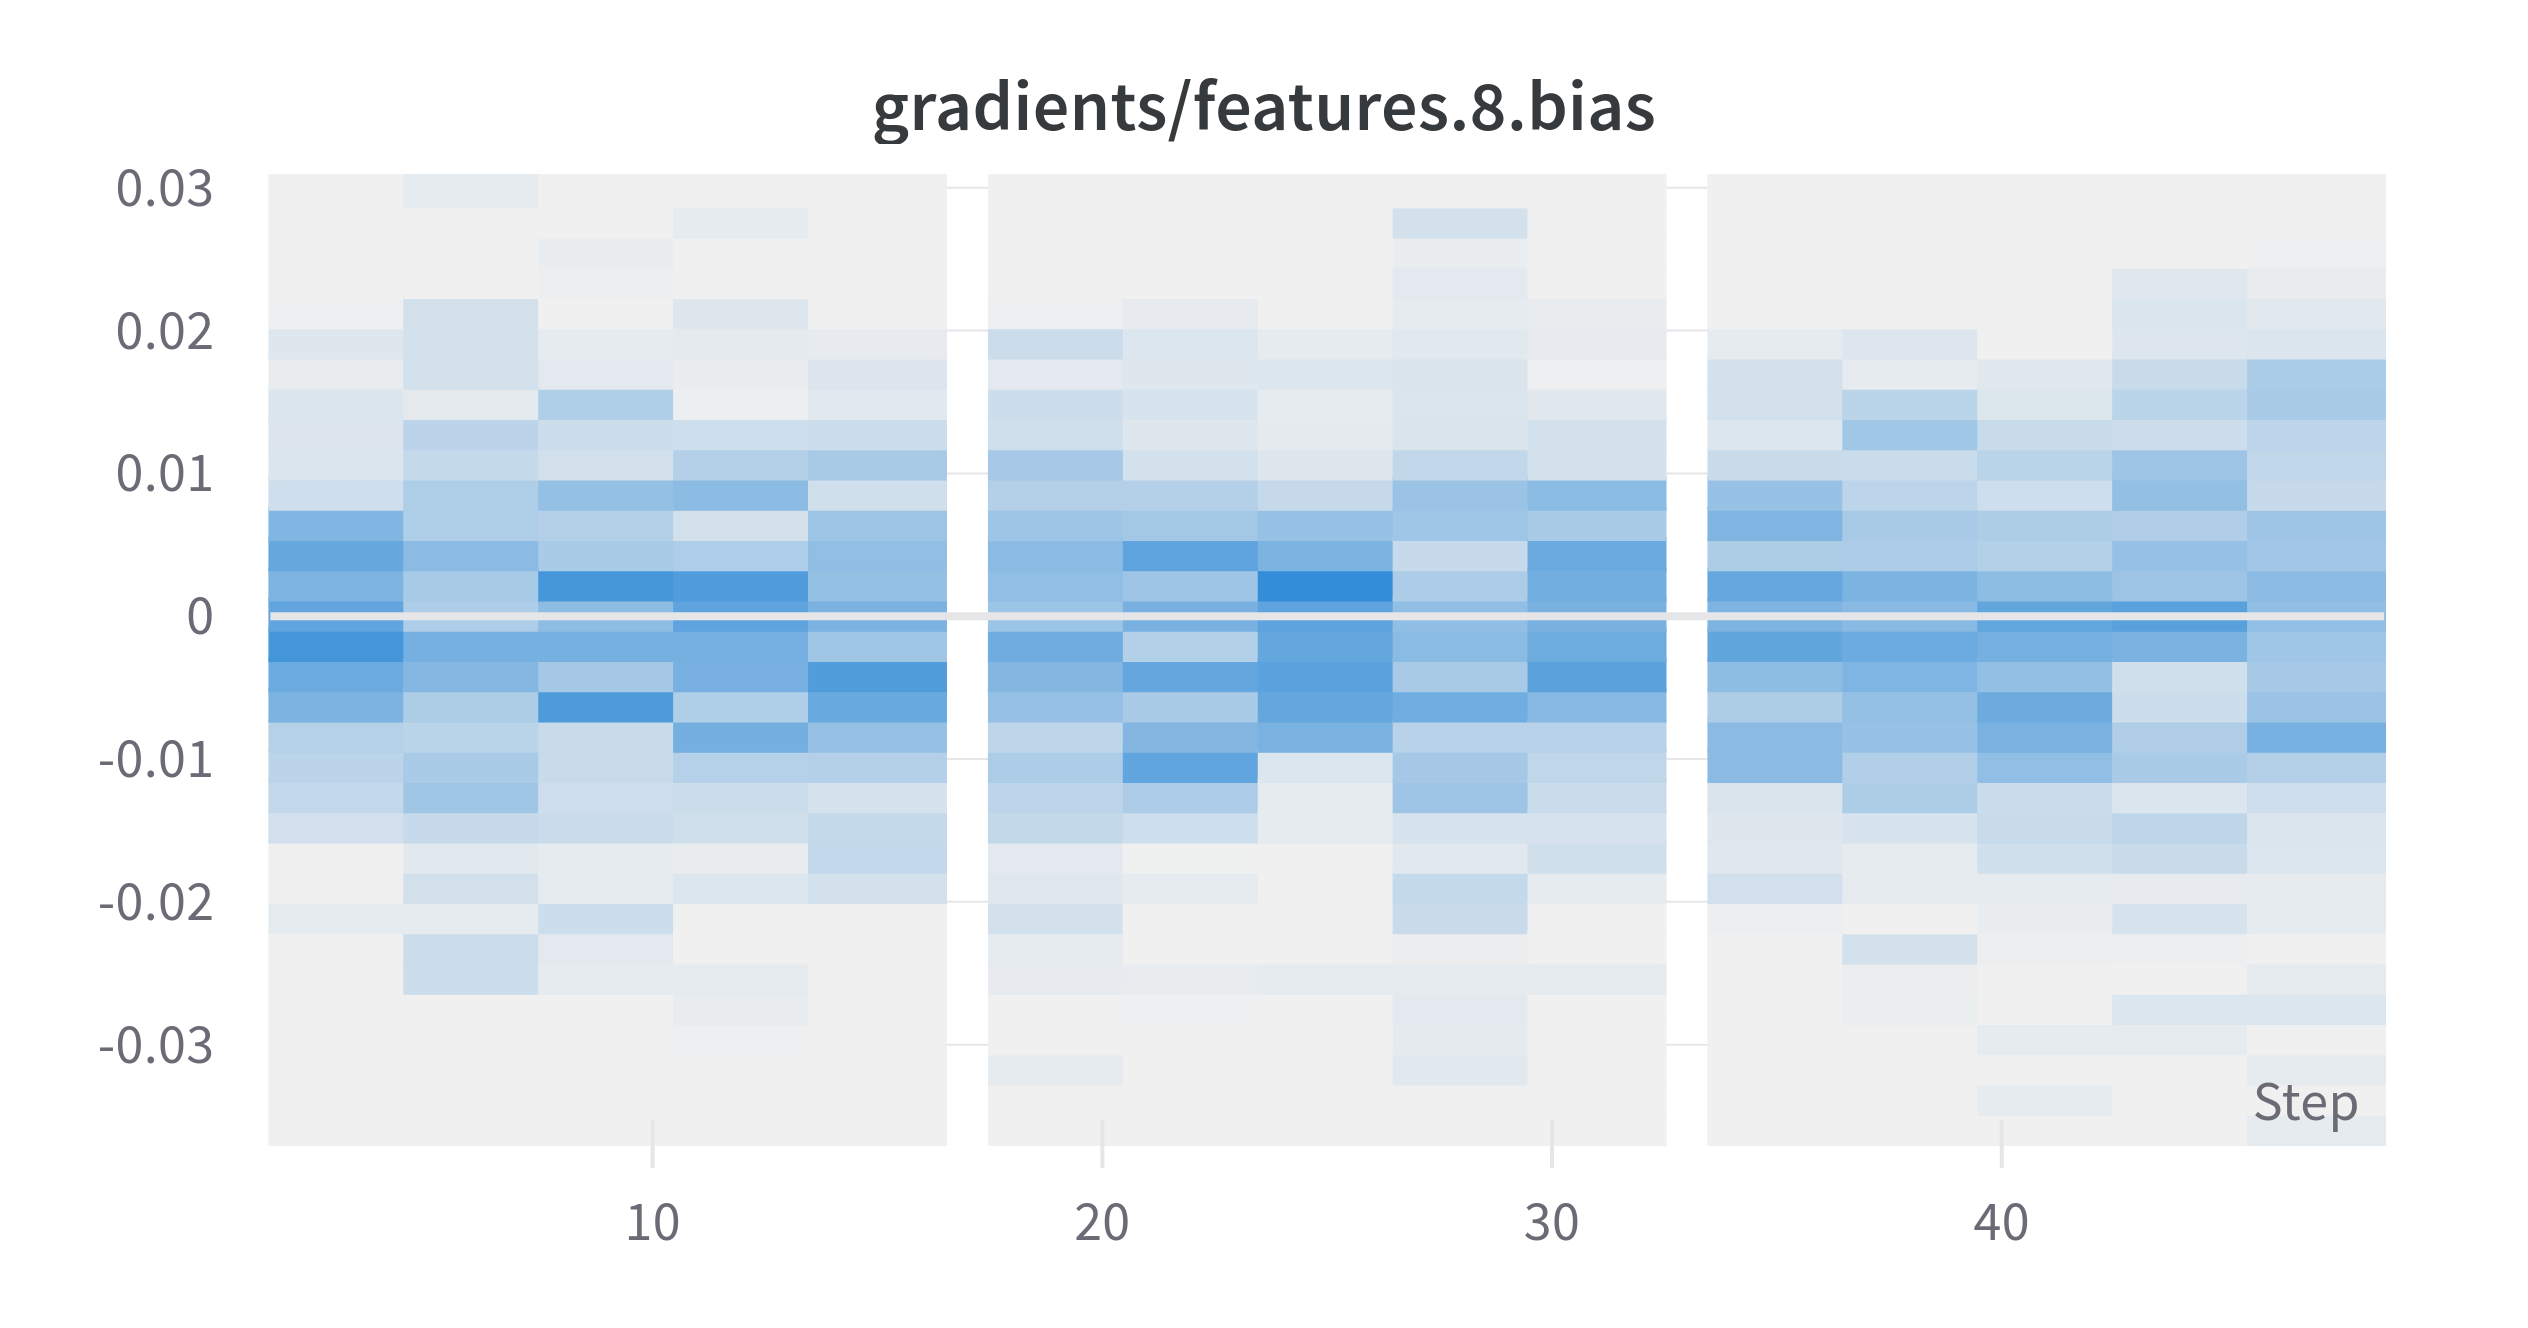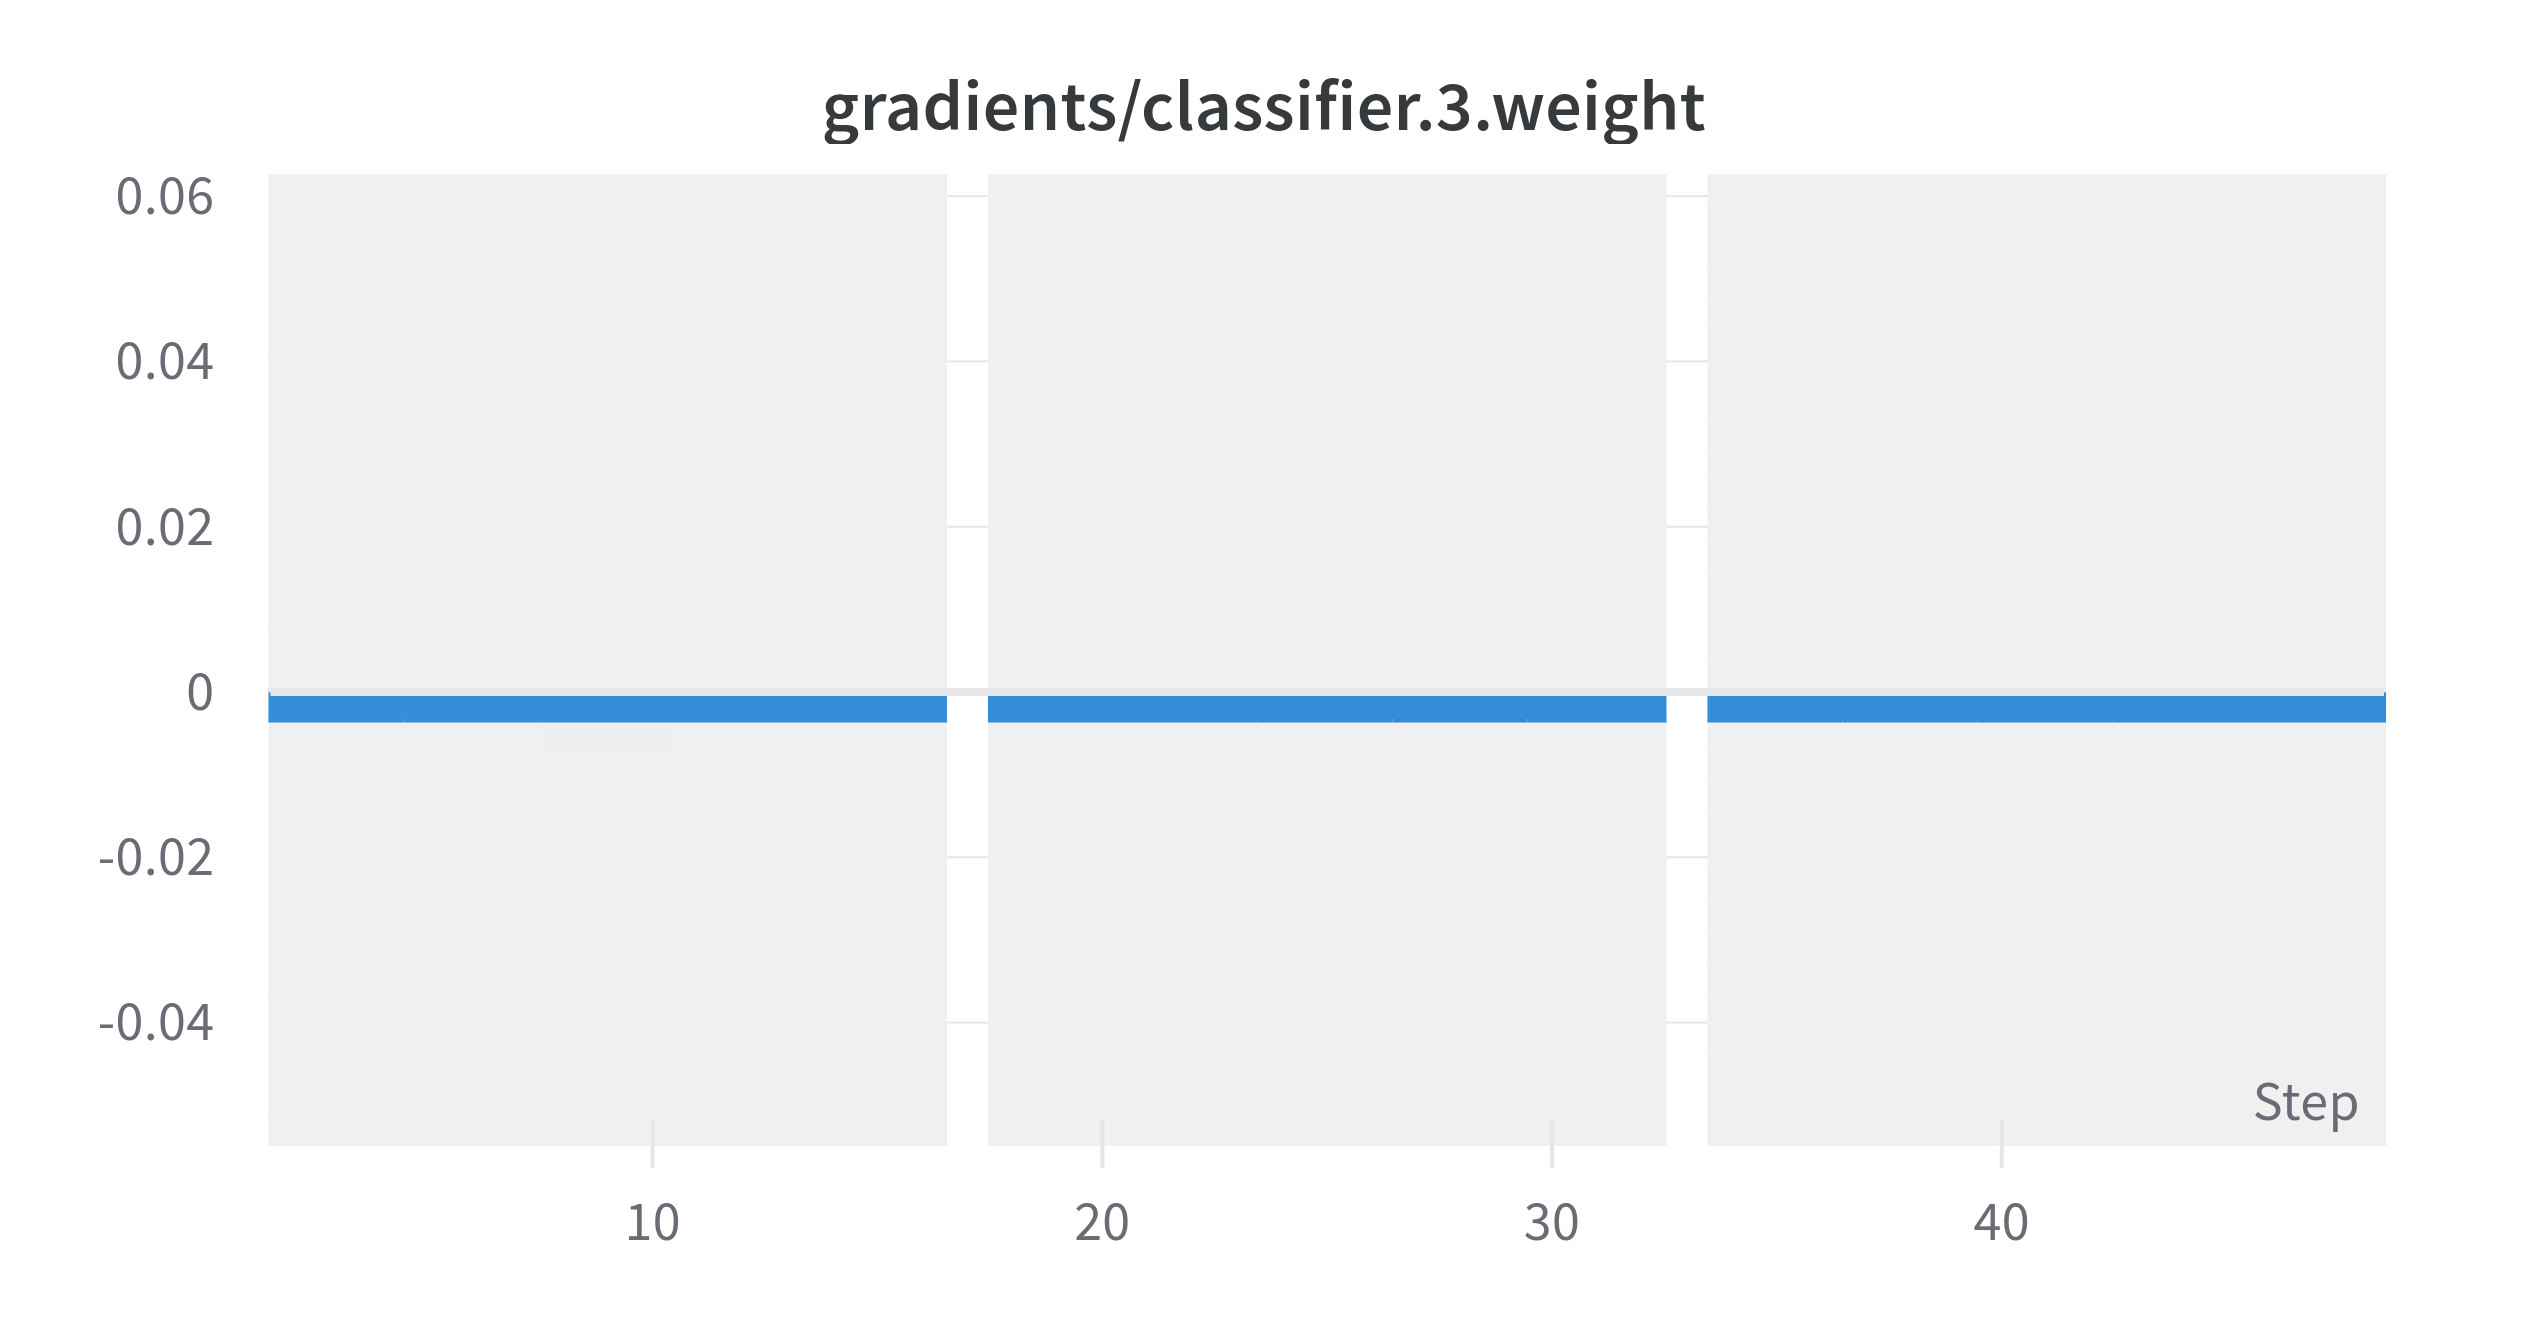

**ResNet**



The observed uniform distribution of gradients around zero in ResNet is a highly favorable characteristic that indicates the network's resilience against both vanishing and exploding gradient problems. The fact that the gradients are not sparse implies that all connections in the network are effectively updated during backpropagation, ensuring that information flows consistently through the layers. This uniformity is crucial for successful training, as it allows the model to learn meaningful representations across all depths.

The absence of vanishing gradients is a significant advantage in ResNet. When gradients remain consistently non-zero and do not approach extremely small values, the network can efficiently backpropagate errors through the layers. This property enables the model to learn from the data effectively and efficiently, even in very deep architectures.

Similarly, the lack of exploding gradients ensures that the optimization process remains stable. When gradients are not prone to extreme values, the risk of the optimization process becoming unstable and leading to drastic parameter updates is mitigated. A stable optimization process helps in achieving faster convergence and better generalization.

The uniform distribution of gradients around zero in ResNet, along with the absence of sparsity and exploding gradients, is a testament to the effectiveness of the residual connections in the architecture. These skip connections allow for the smooth propagation of gradients, fostering consistent learning throughout the network. As a result, ResNet can handle deeper architectures without suffering from accuracy degradation, making it a superior choice for various deep learning tasks.

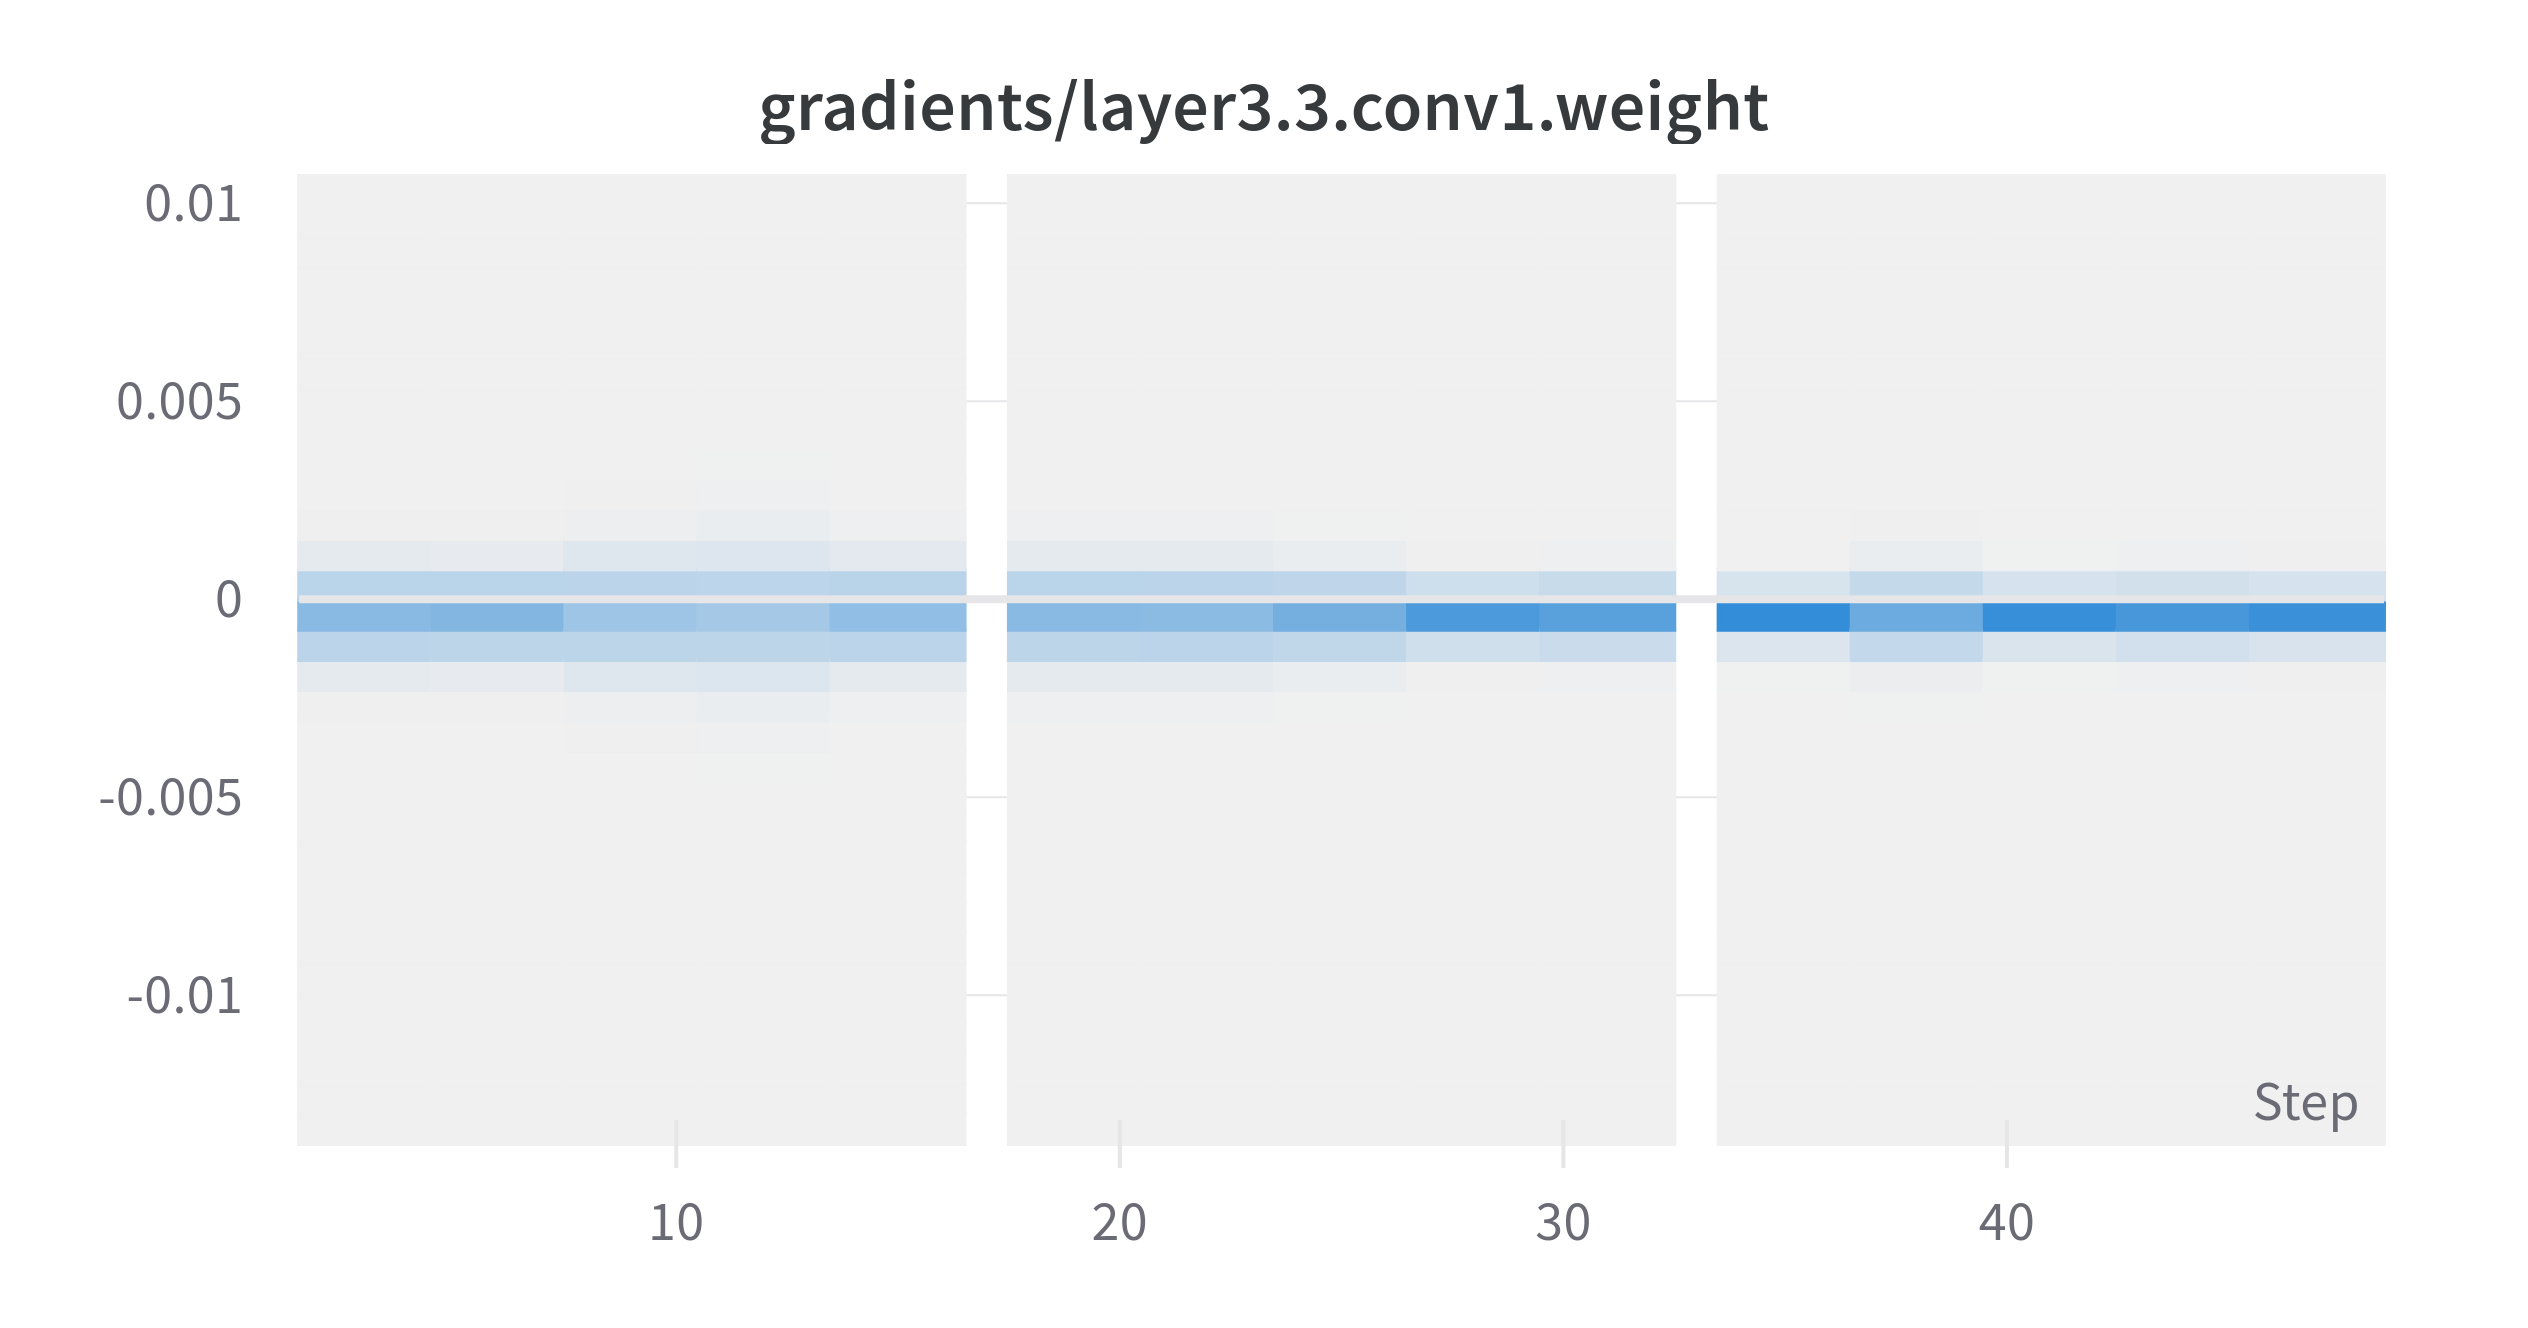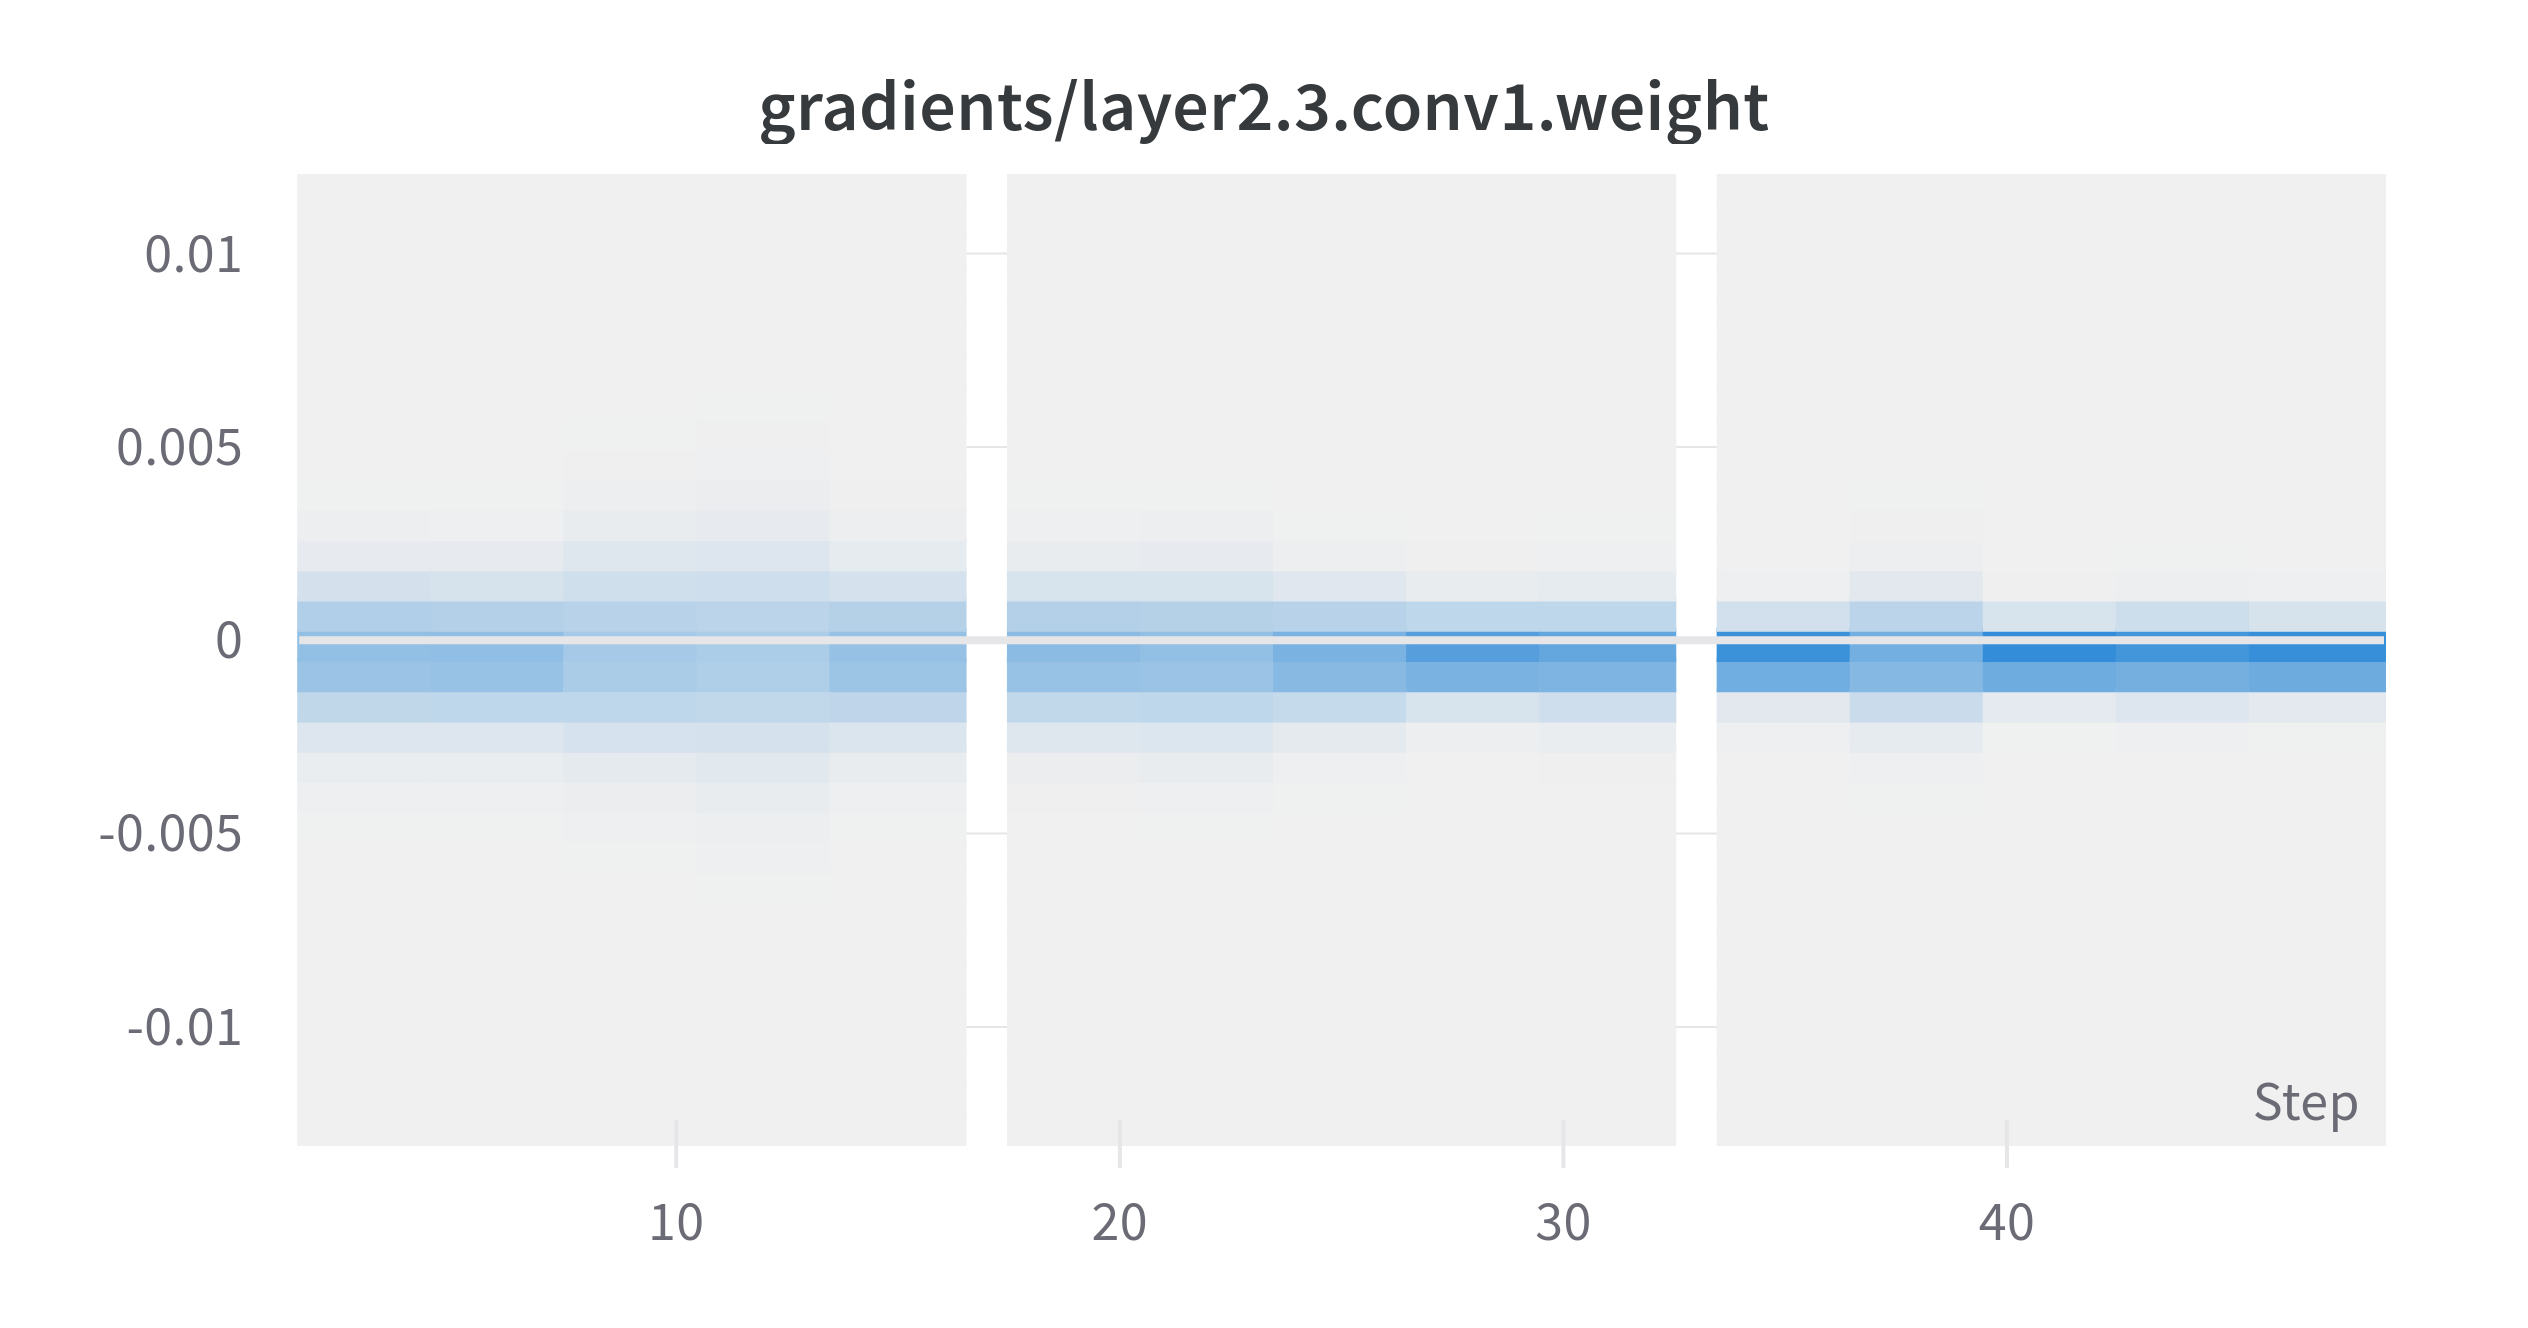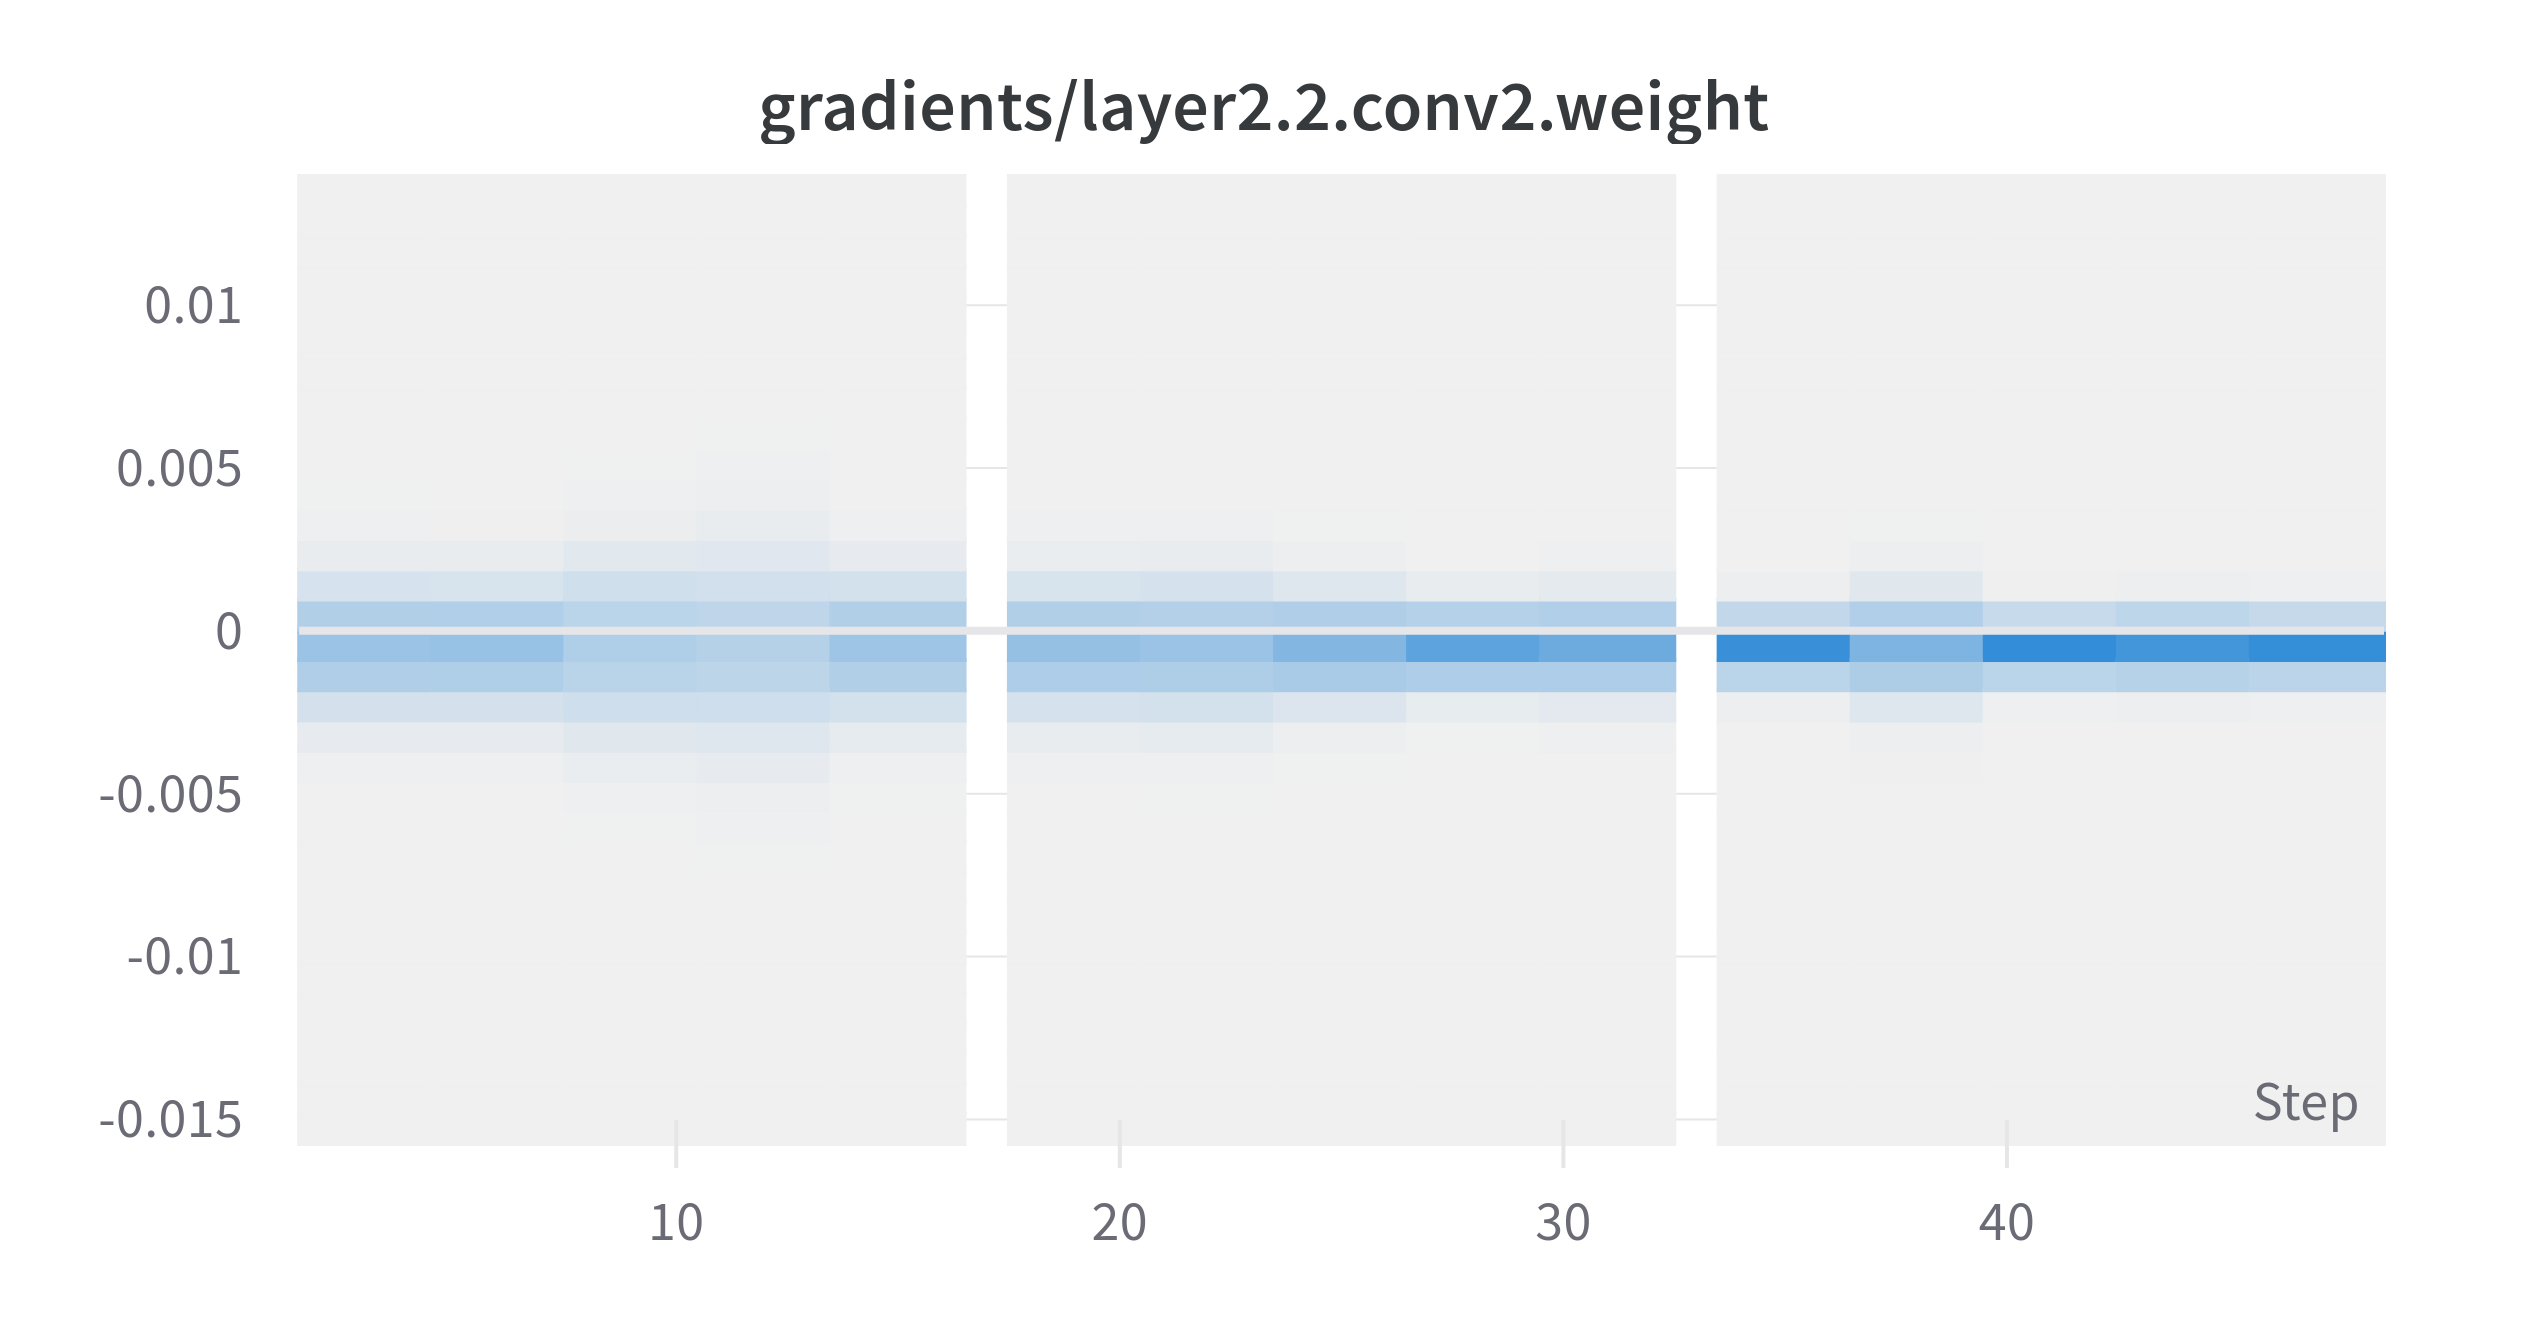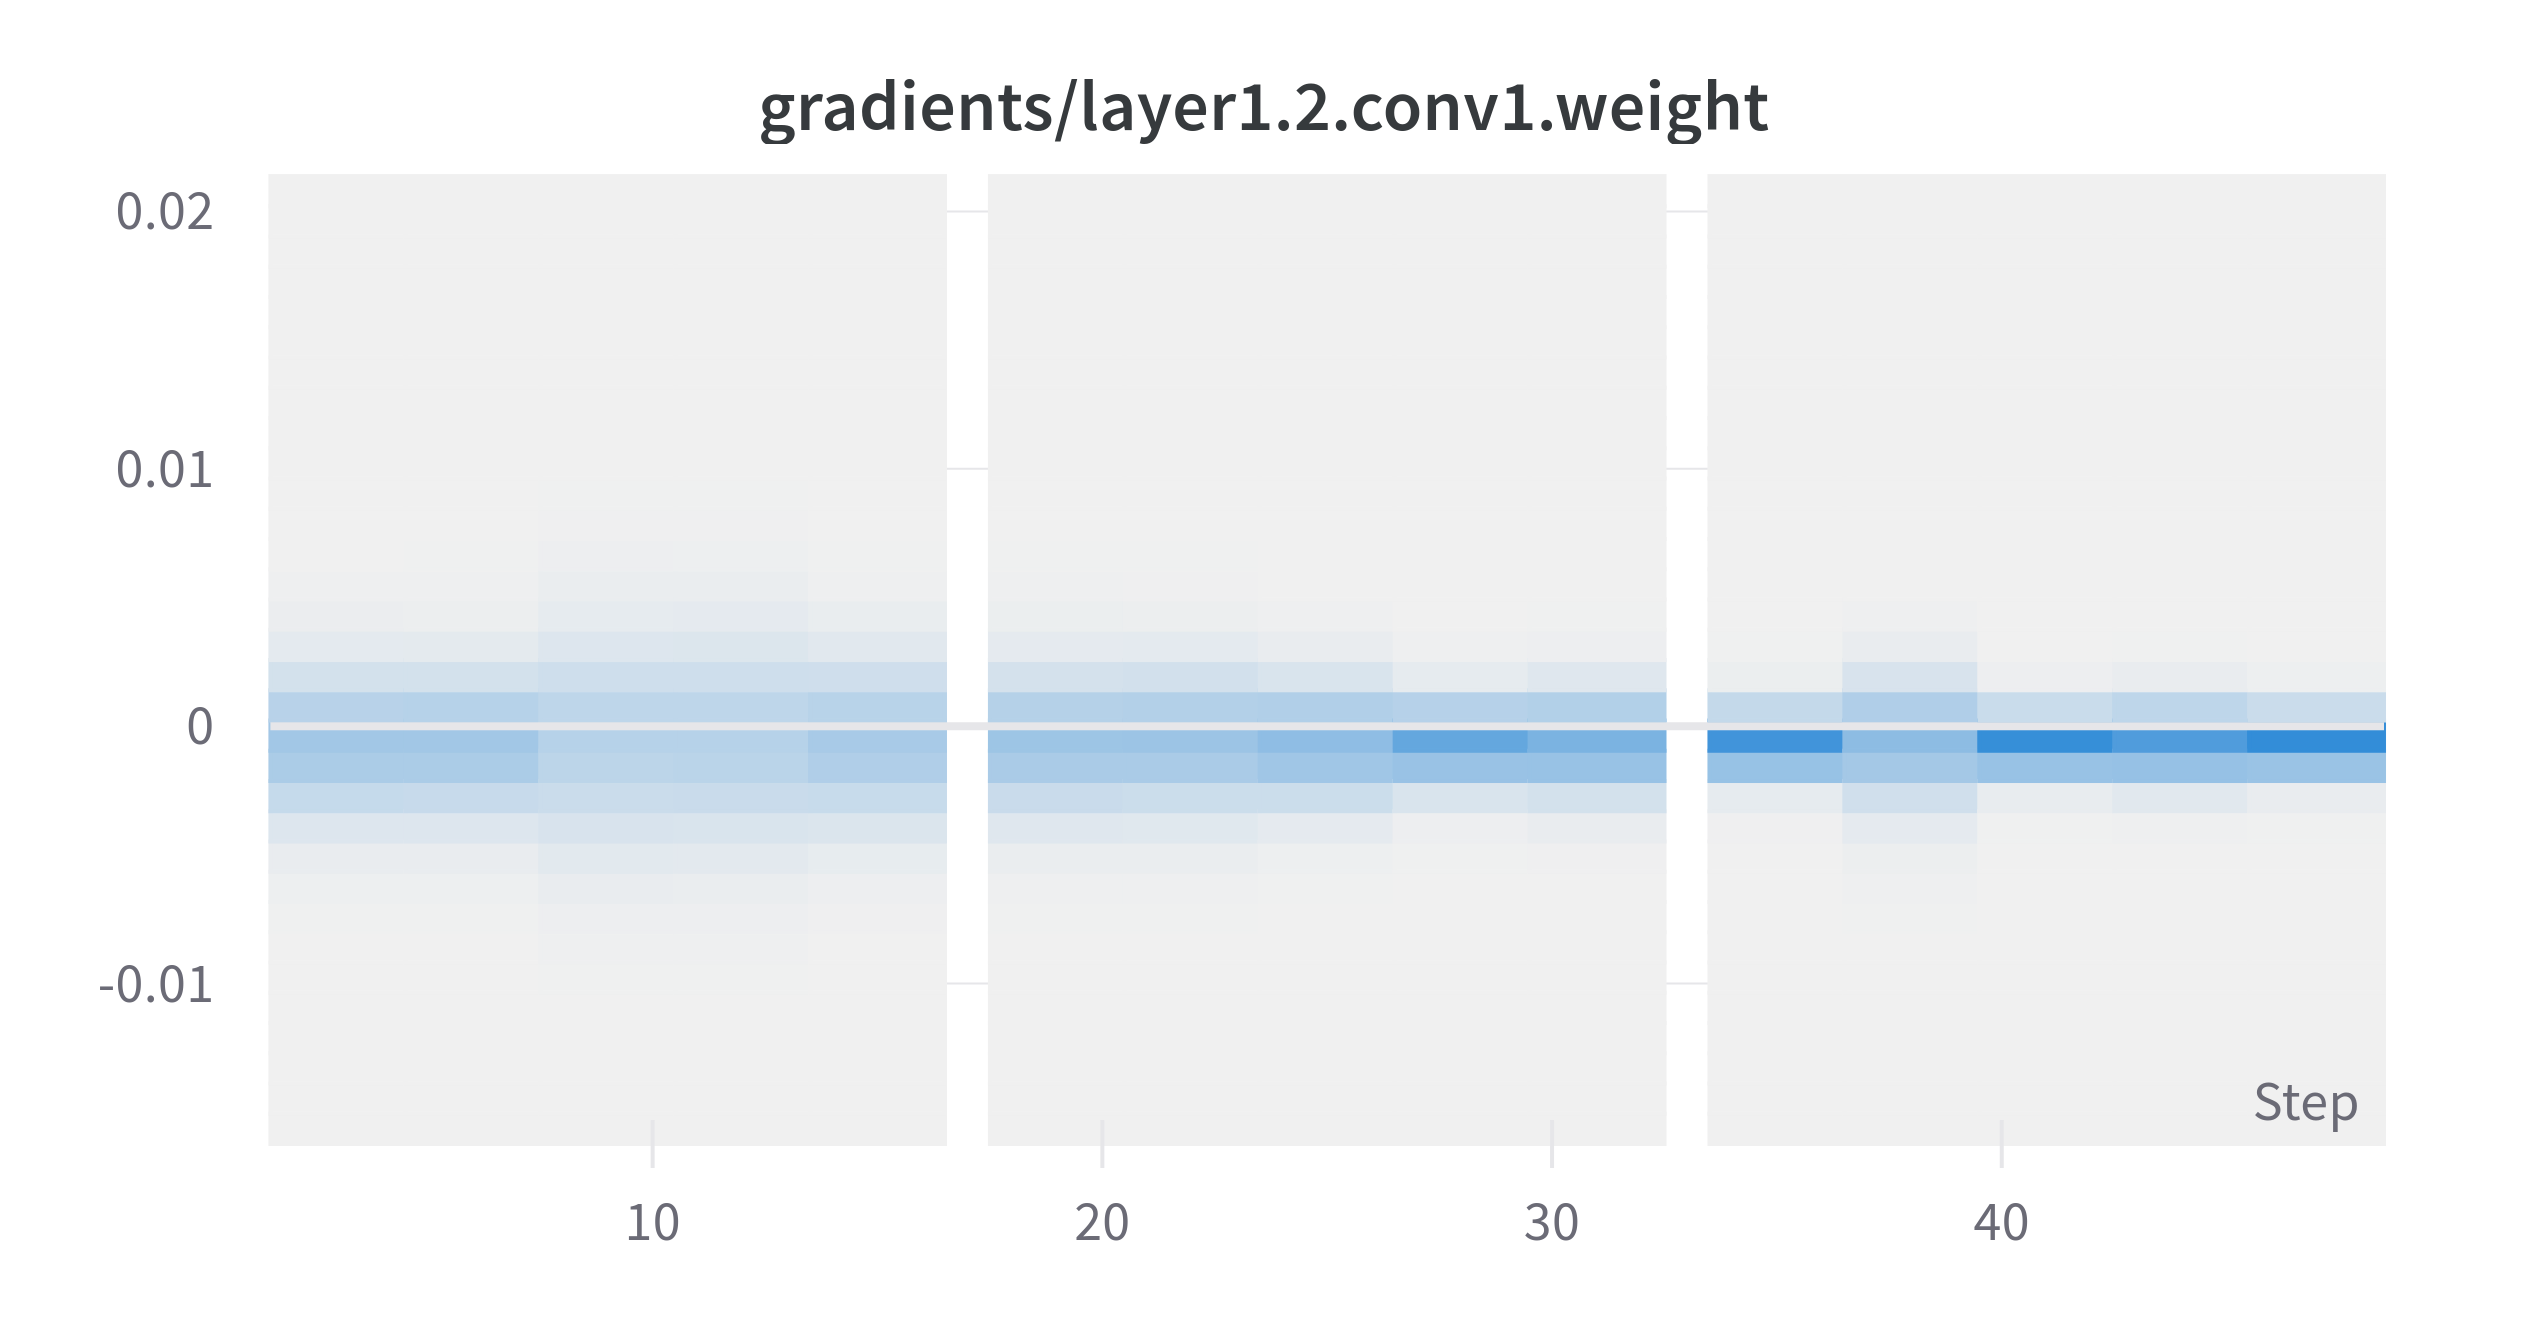

### 2.1.2: Parameter Analysis

**VGG**

The observed sparsity of parameters in VGG is an interesting finding. Sparse parameters suggest that certain connections in the network are not effectively contributing to the learning process, which might be limiting the model's capacity to capture complex patterns in the data. Sparse connections can lead to information loss and hinder the model's ability to represent fine-grained details in the input. Additionally, the noise present during convergence in VGG can be indicative of instability in the optimization process. This instability might lead to fluctuations in parameter values, making it difficult for the model to converge smoothly to an optimal solution.

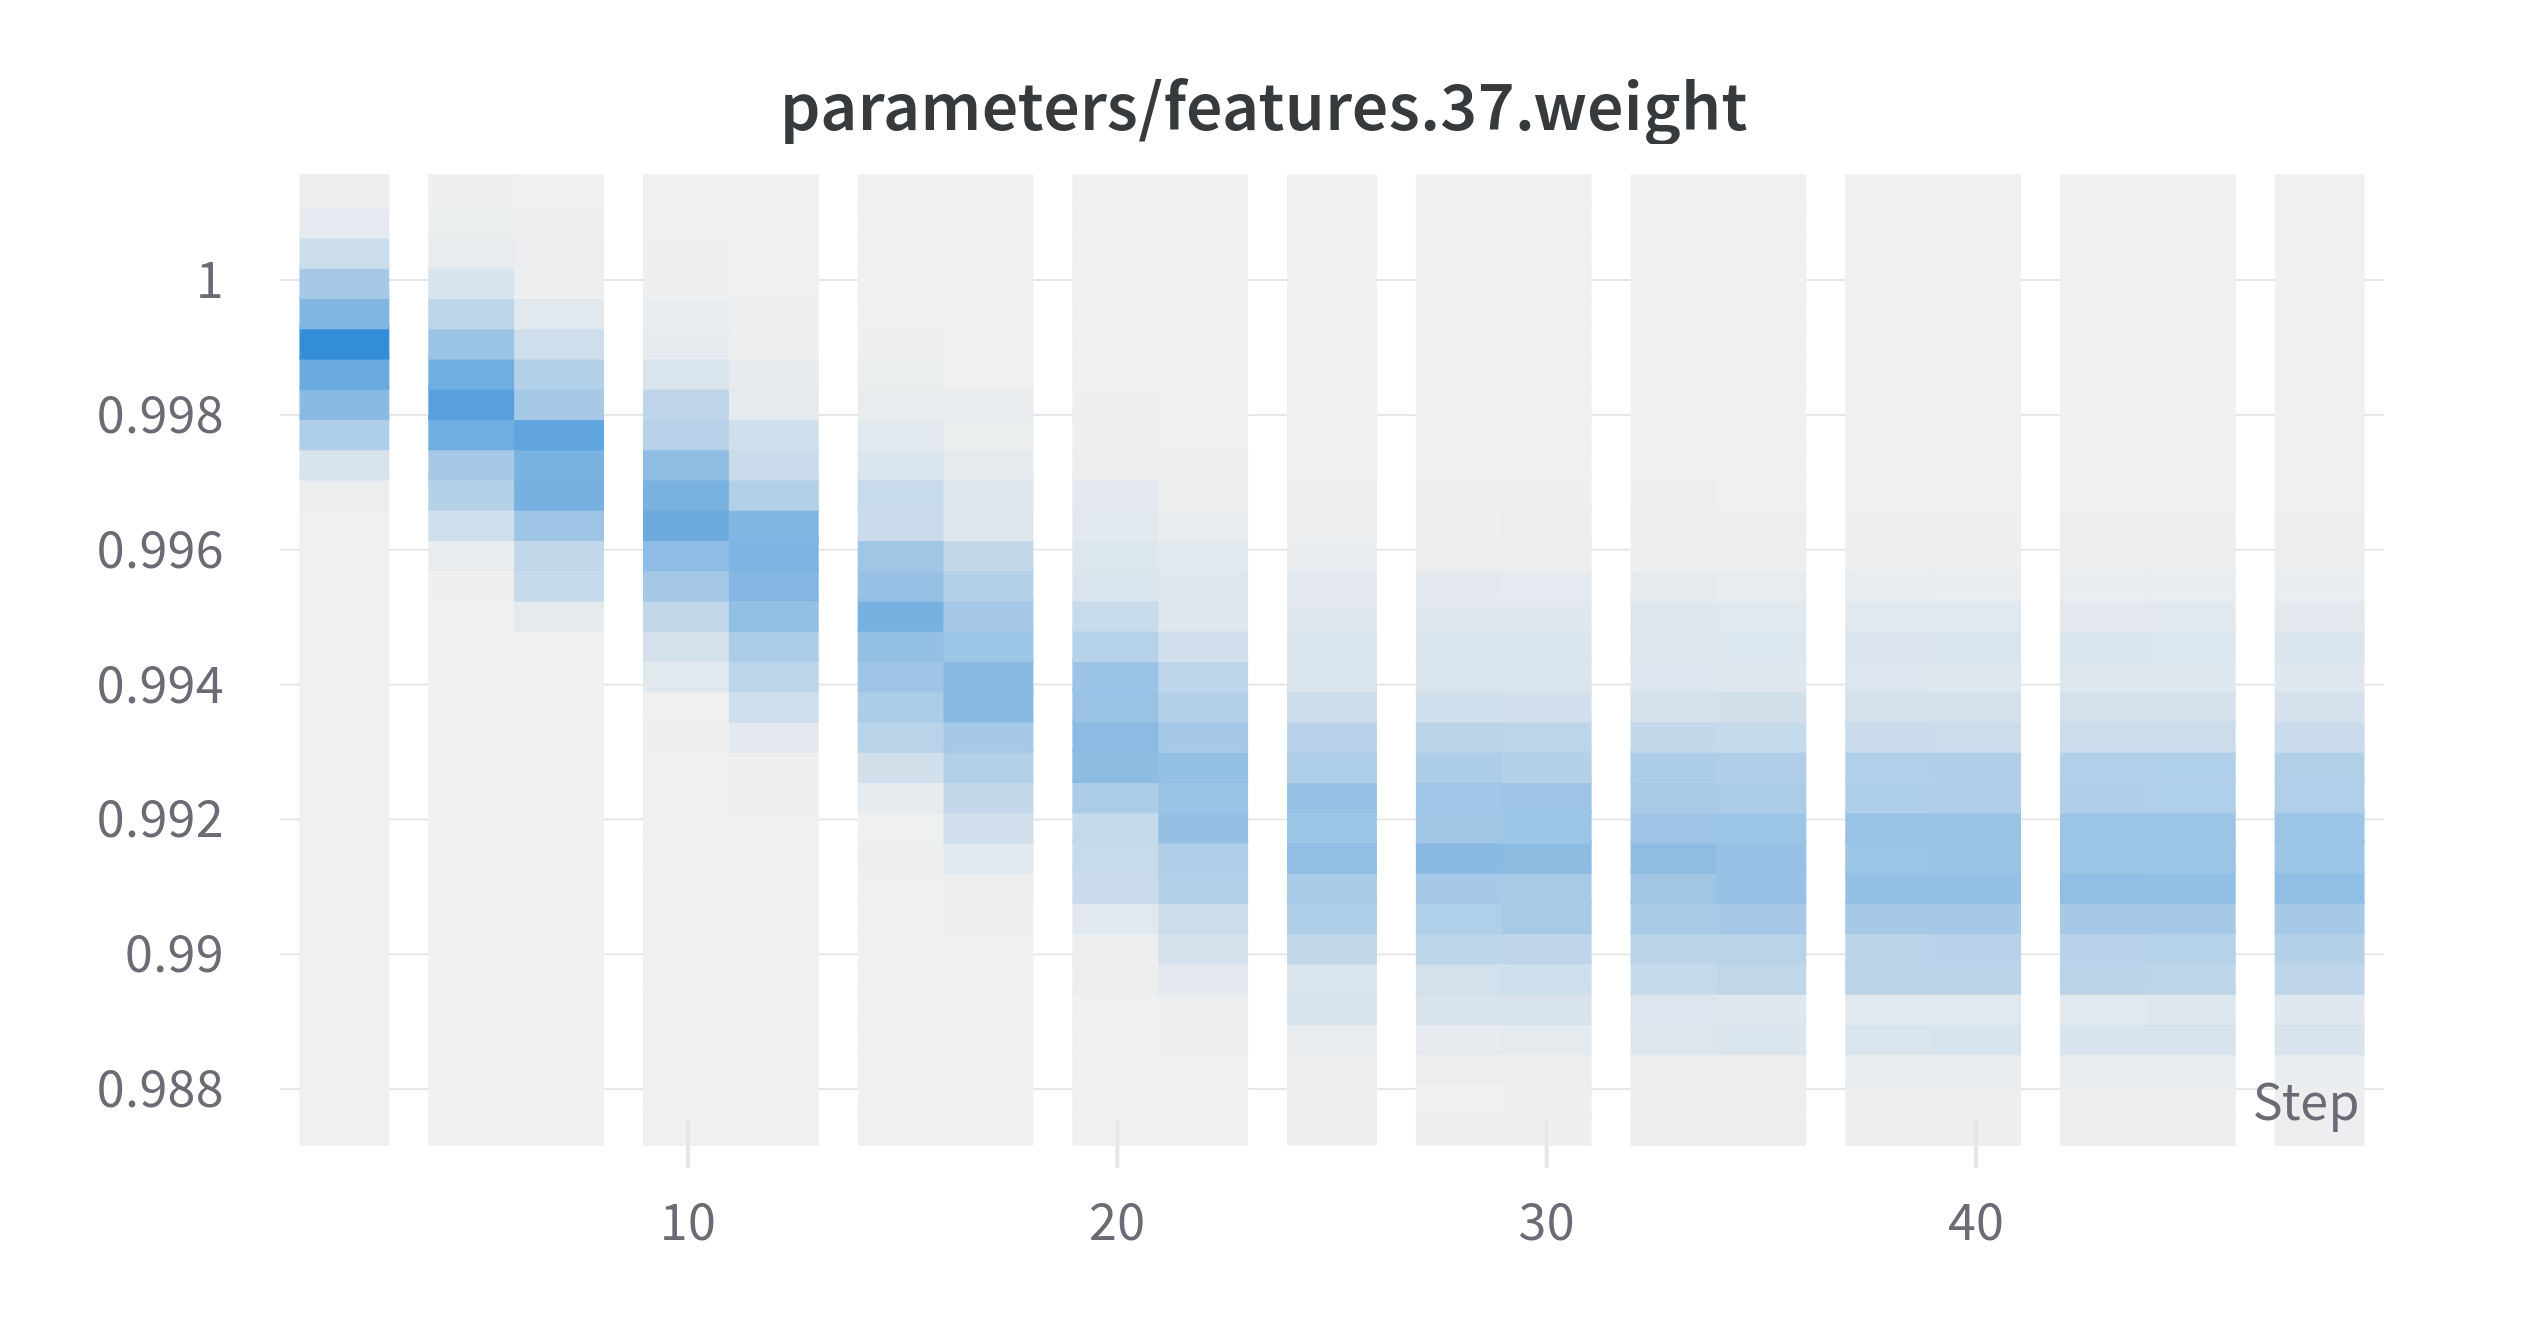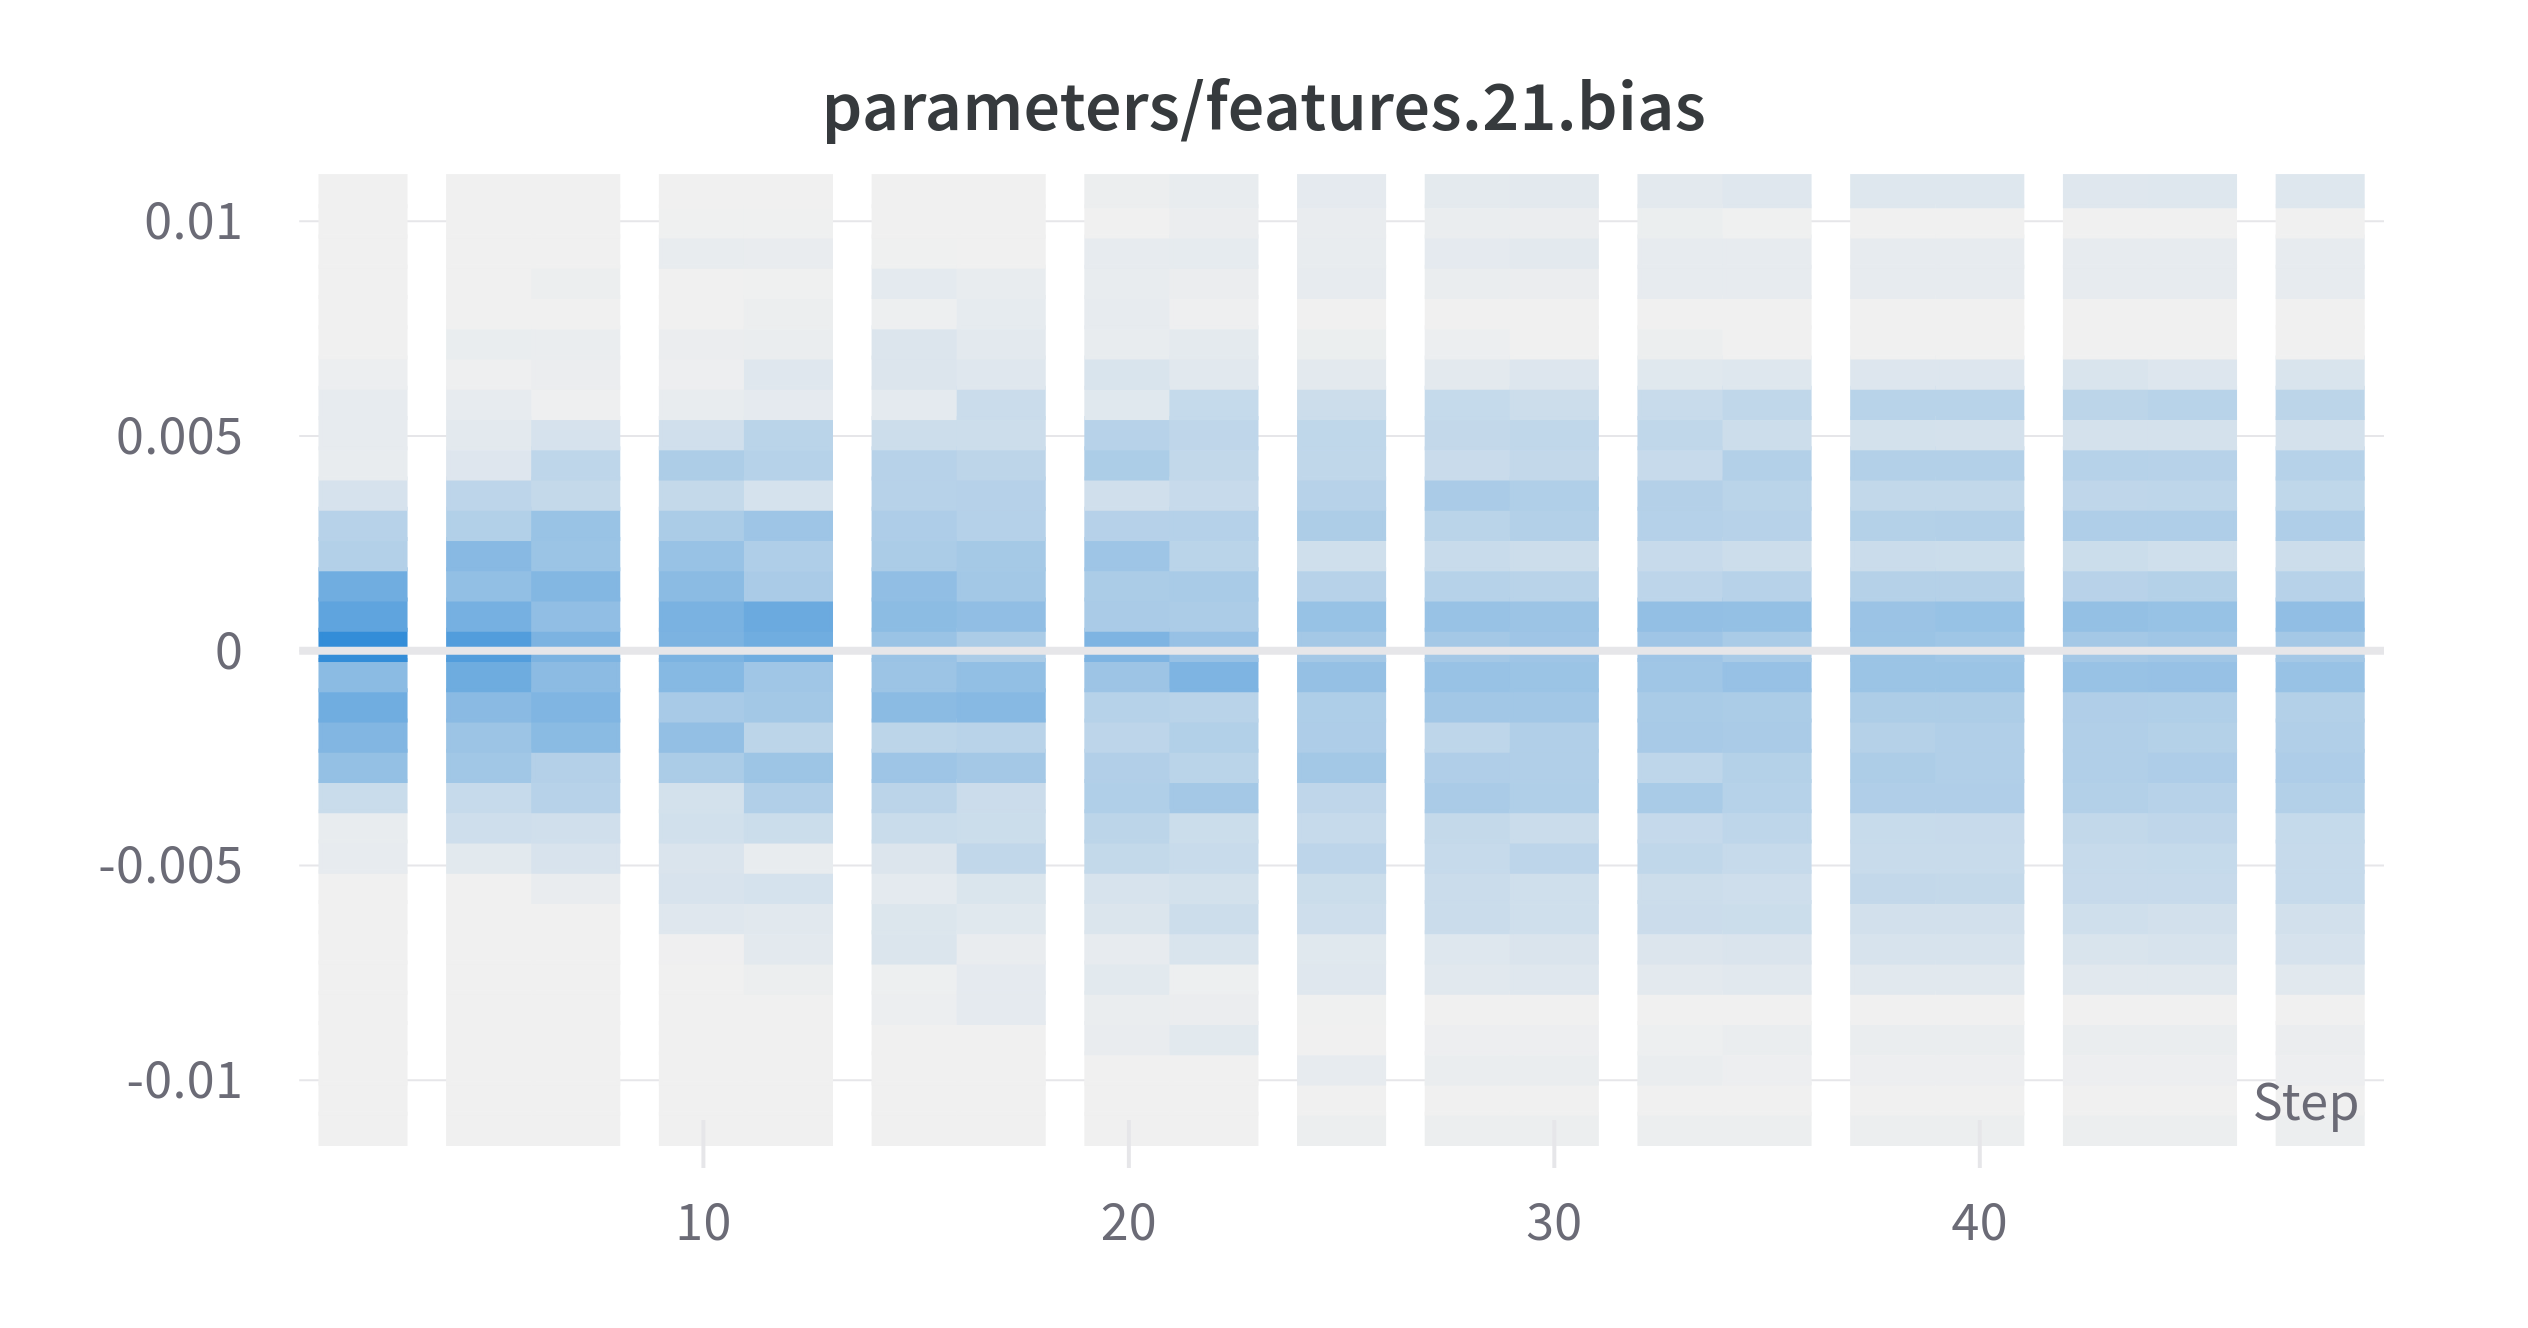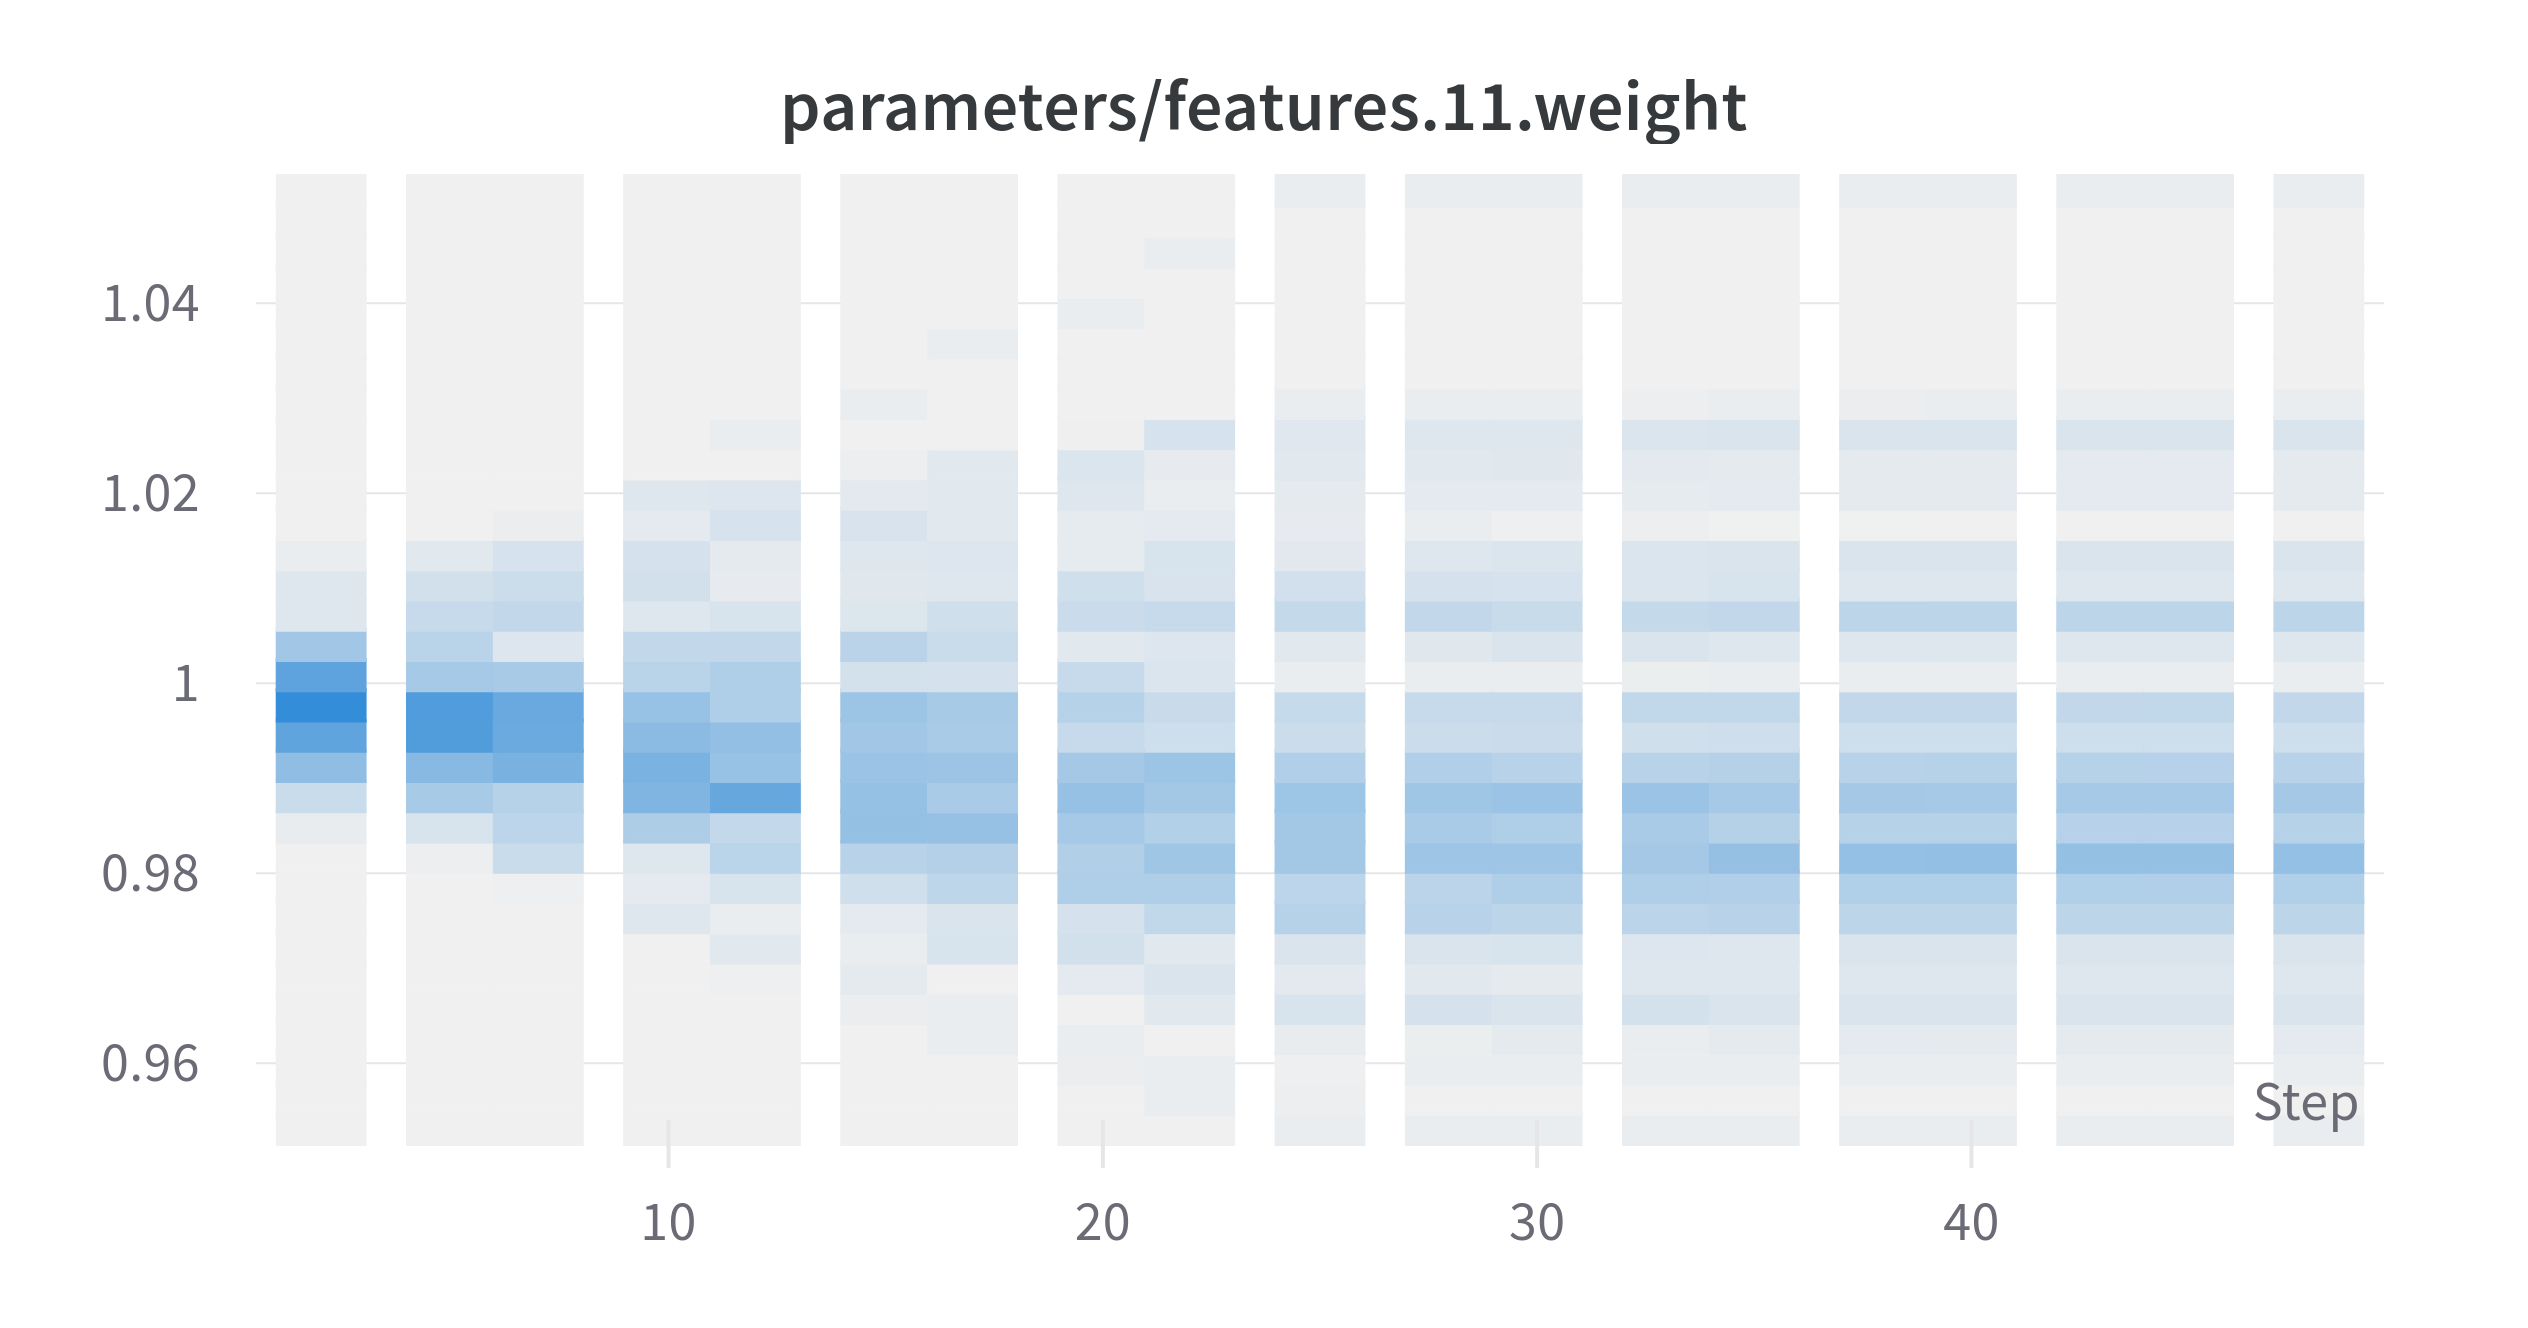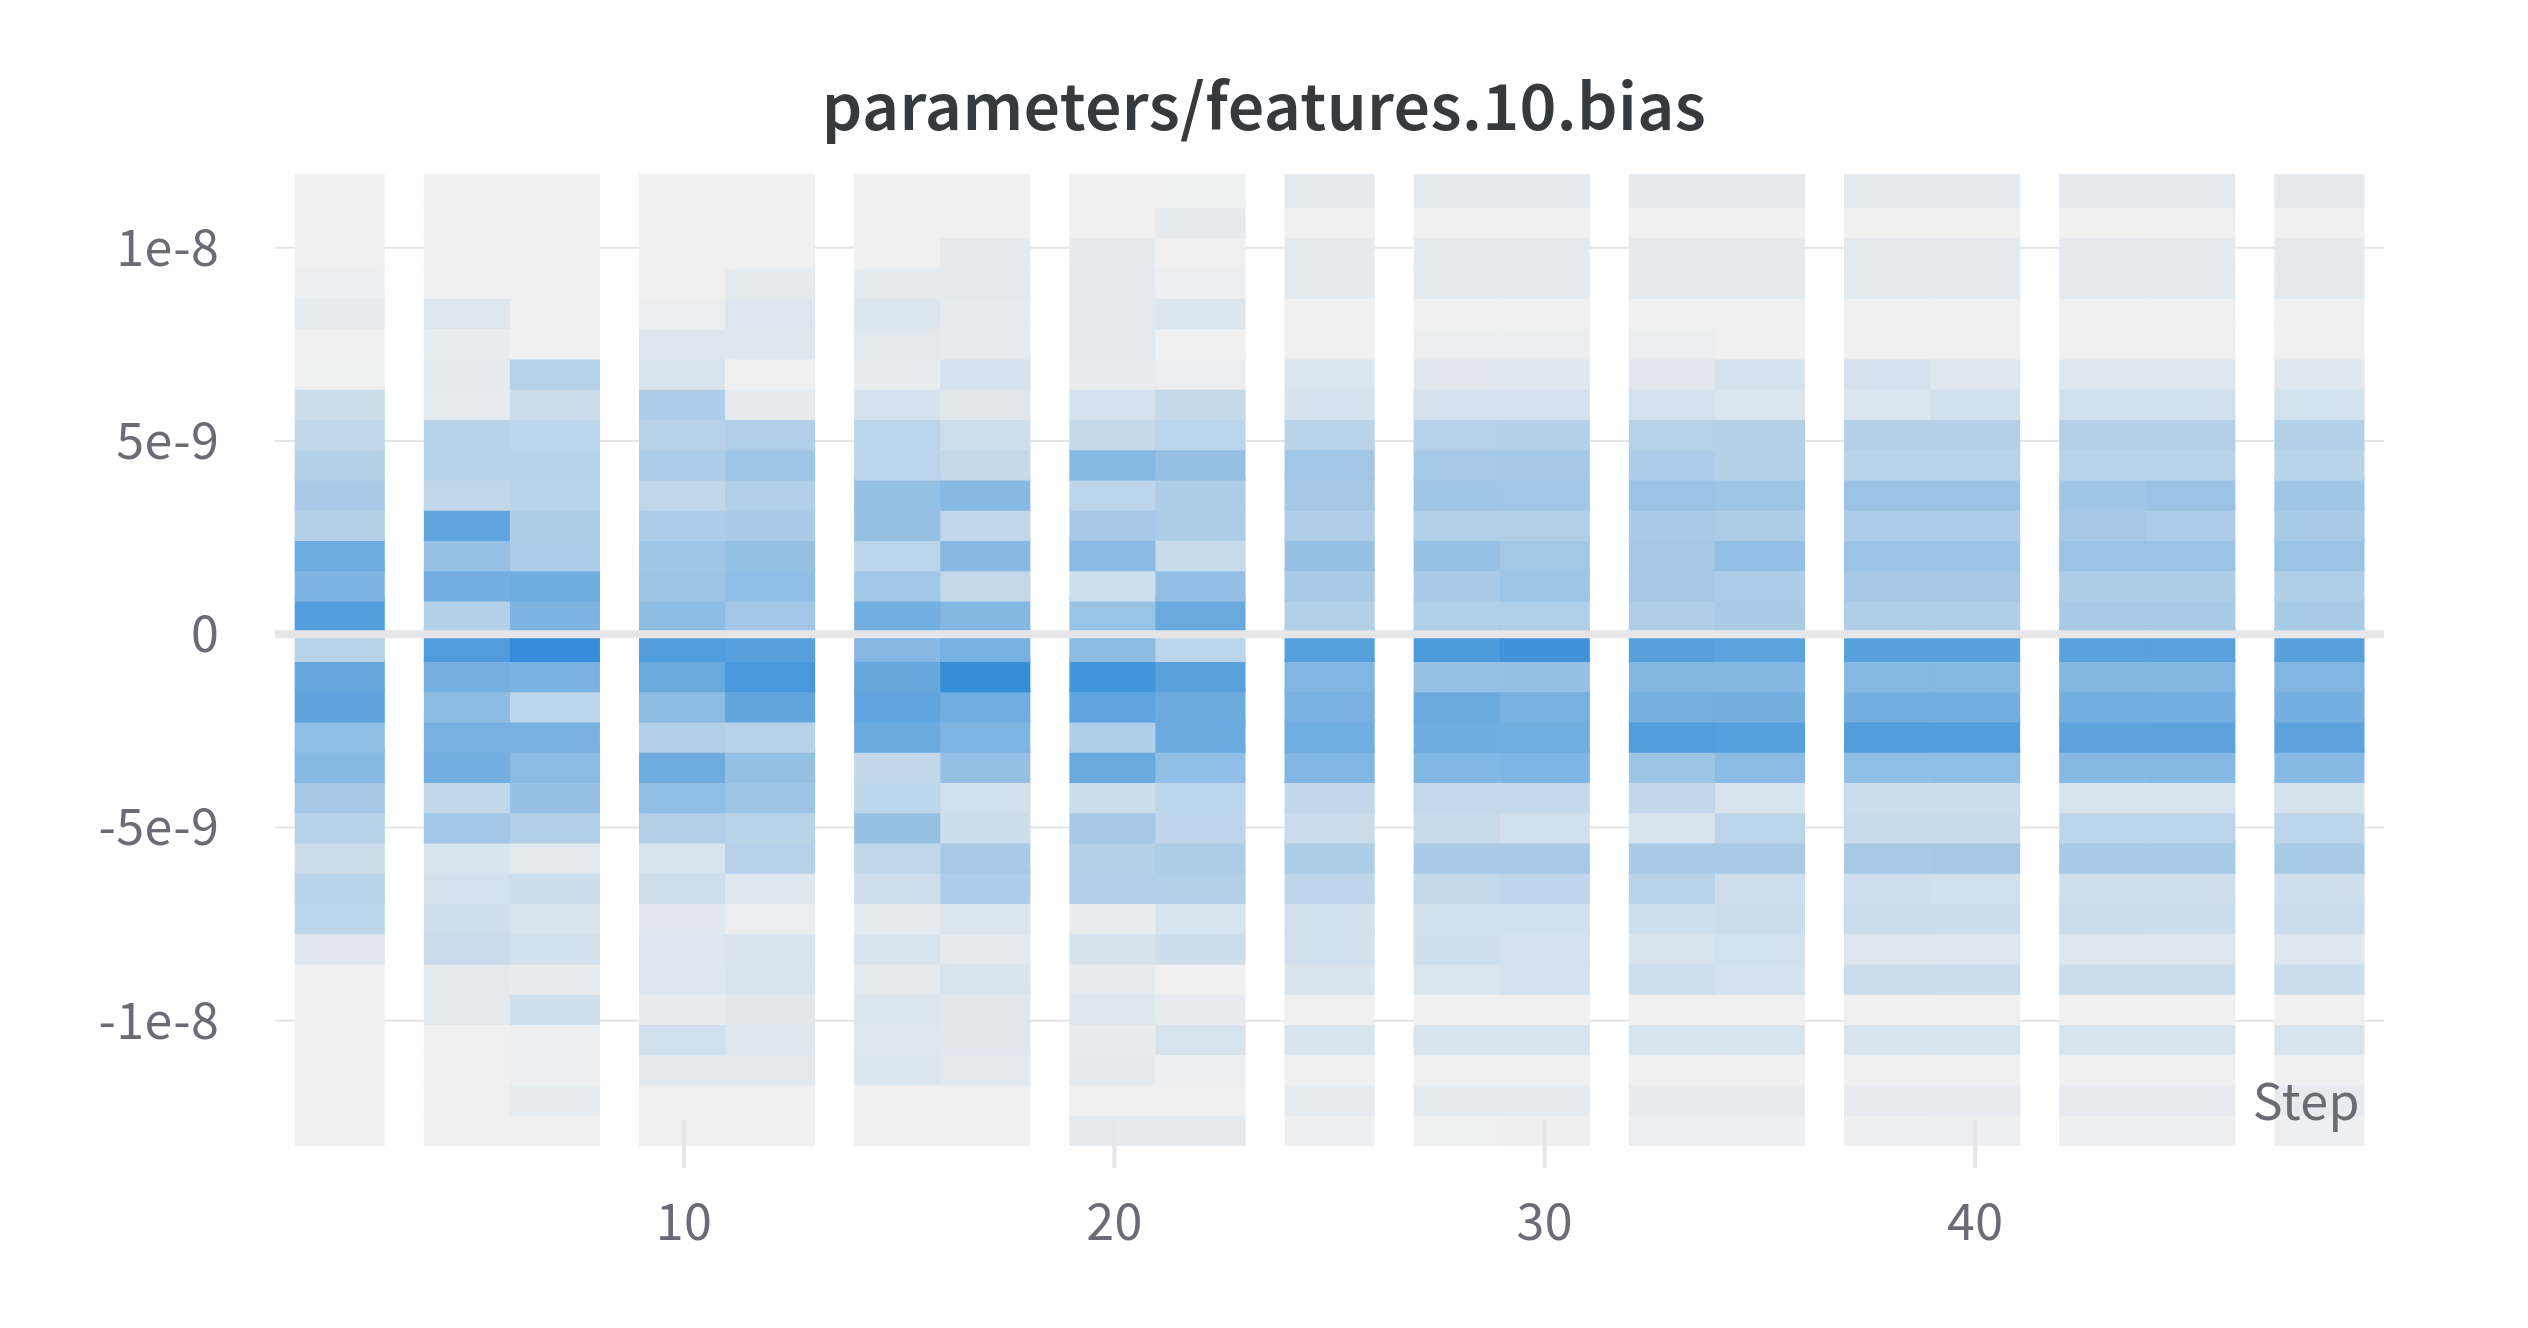

**ResNet**

In contrast, ResNet showcases remarkable stability in both its parameters and gradients, which is a positive sign for deep neural networks. The stability of parameters in ResNet indicates consistent learning from the data and convergence towards an optimal solution. The absence of significant fluctuations or sparsity in parameters signifies that ResNet is utilizing all connections effectively to represent complex patterns. The improved stability in ResNet can be attributed to its unique architecture with residual connections, which mitigate the vanishing gradient problem and encourage more straightforward optimization. The stability observed in ResNet is a significant advantage, as it contributes to its ability to perform well even with very deep networks, avoiding accuracy degradation and enhancing its generalization capabilities.

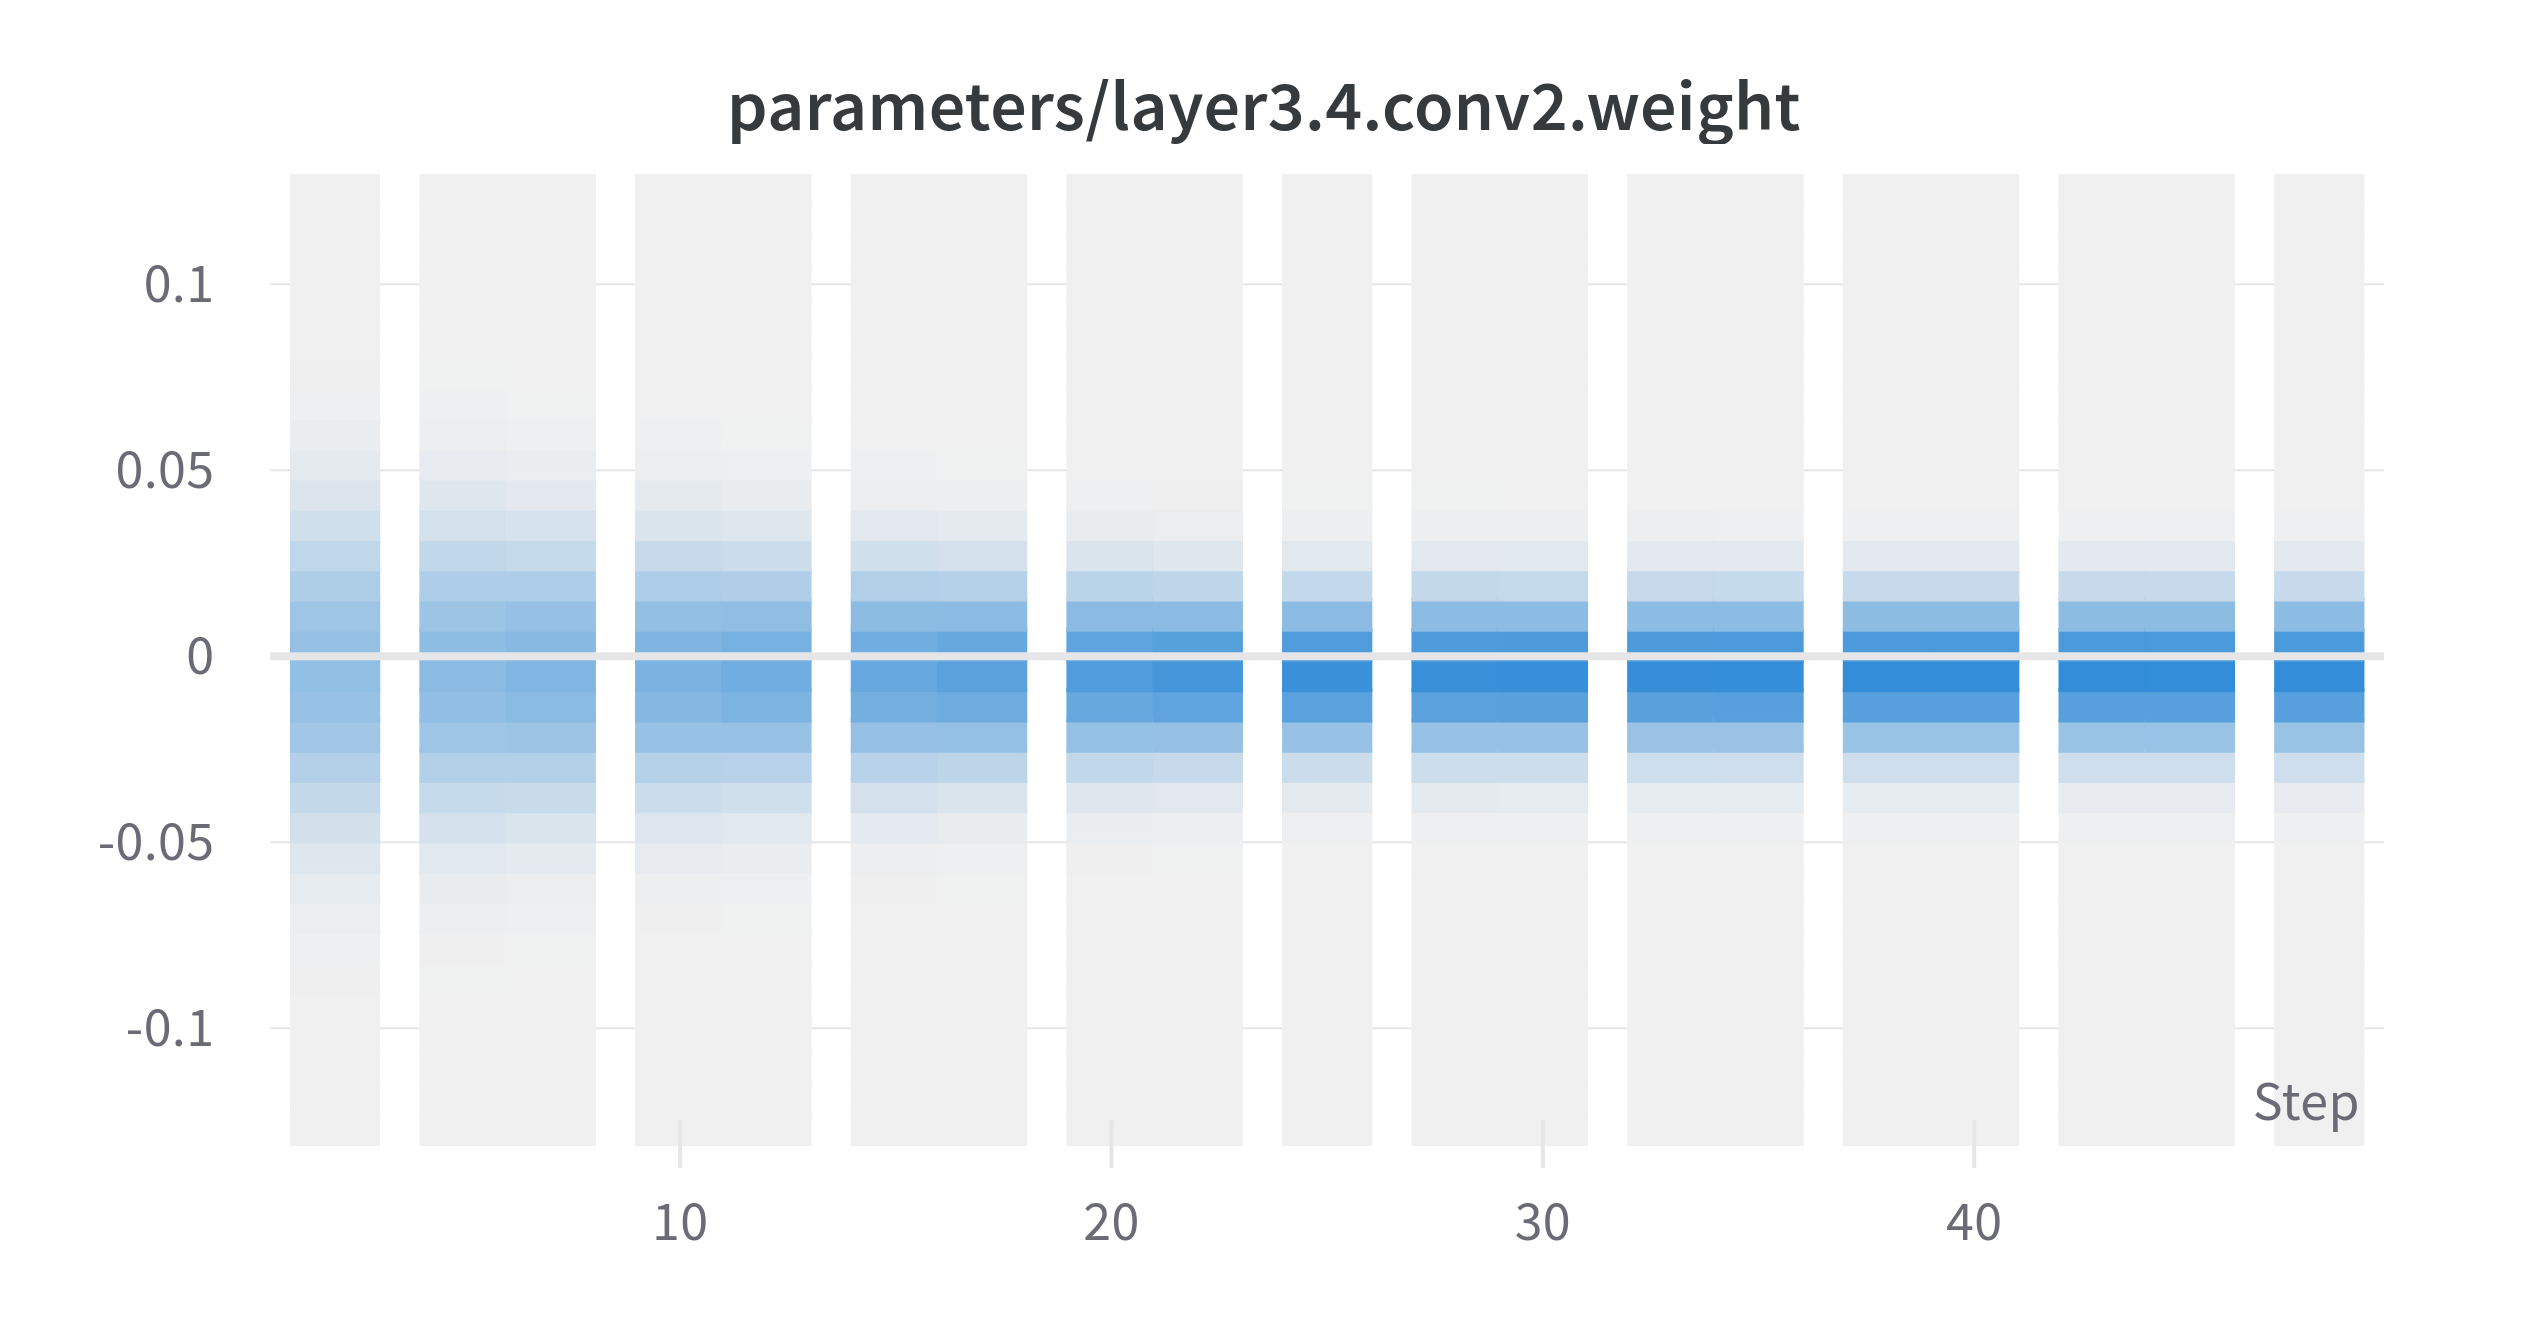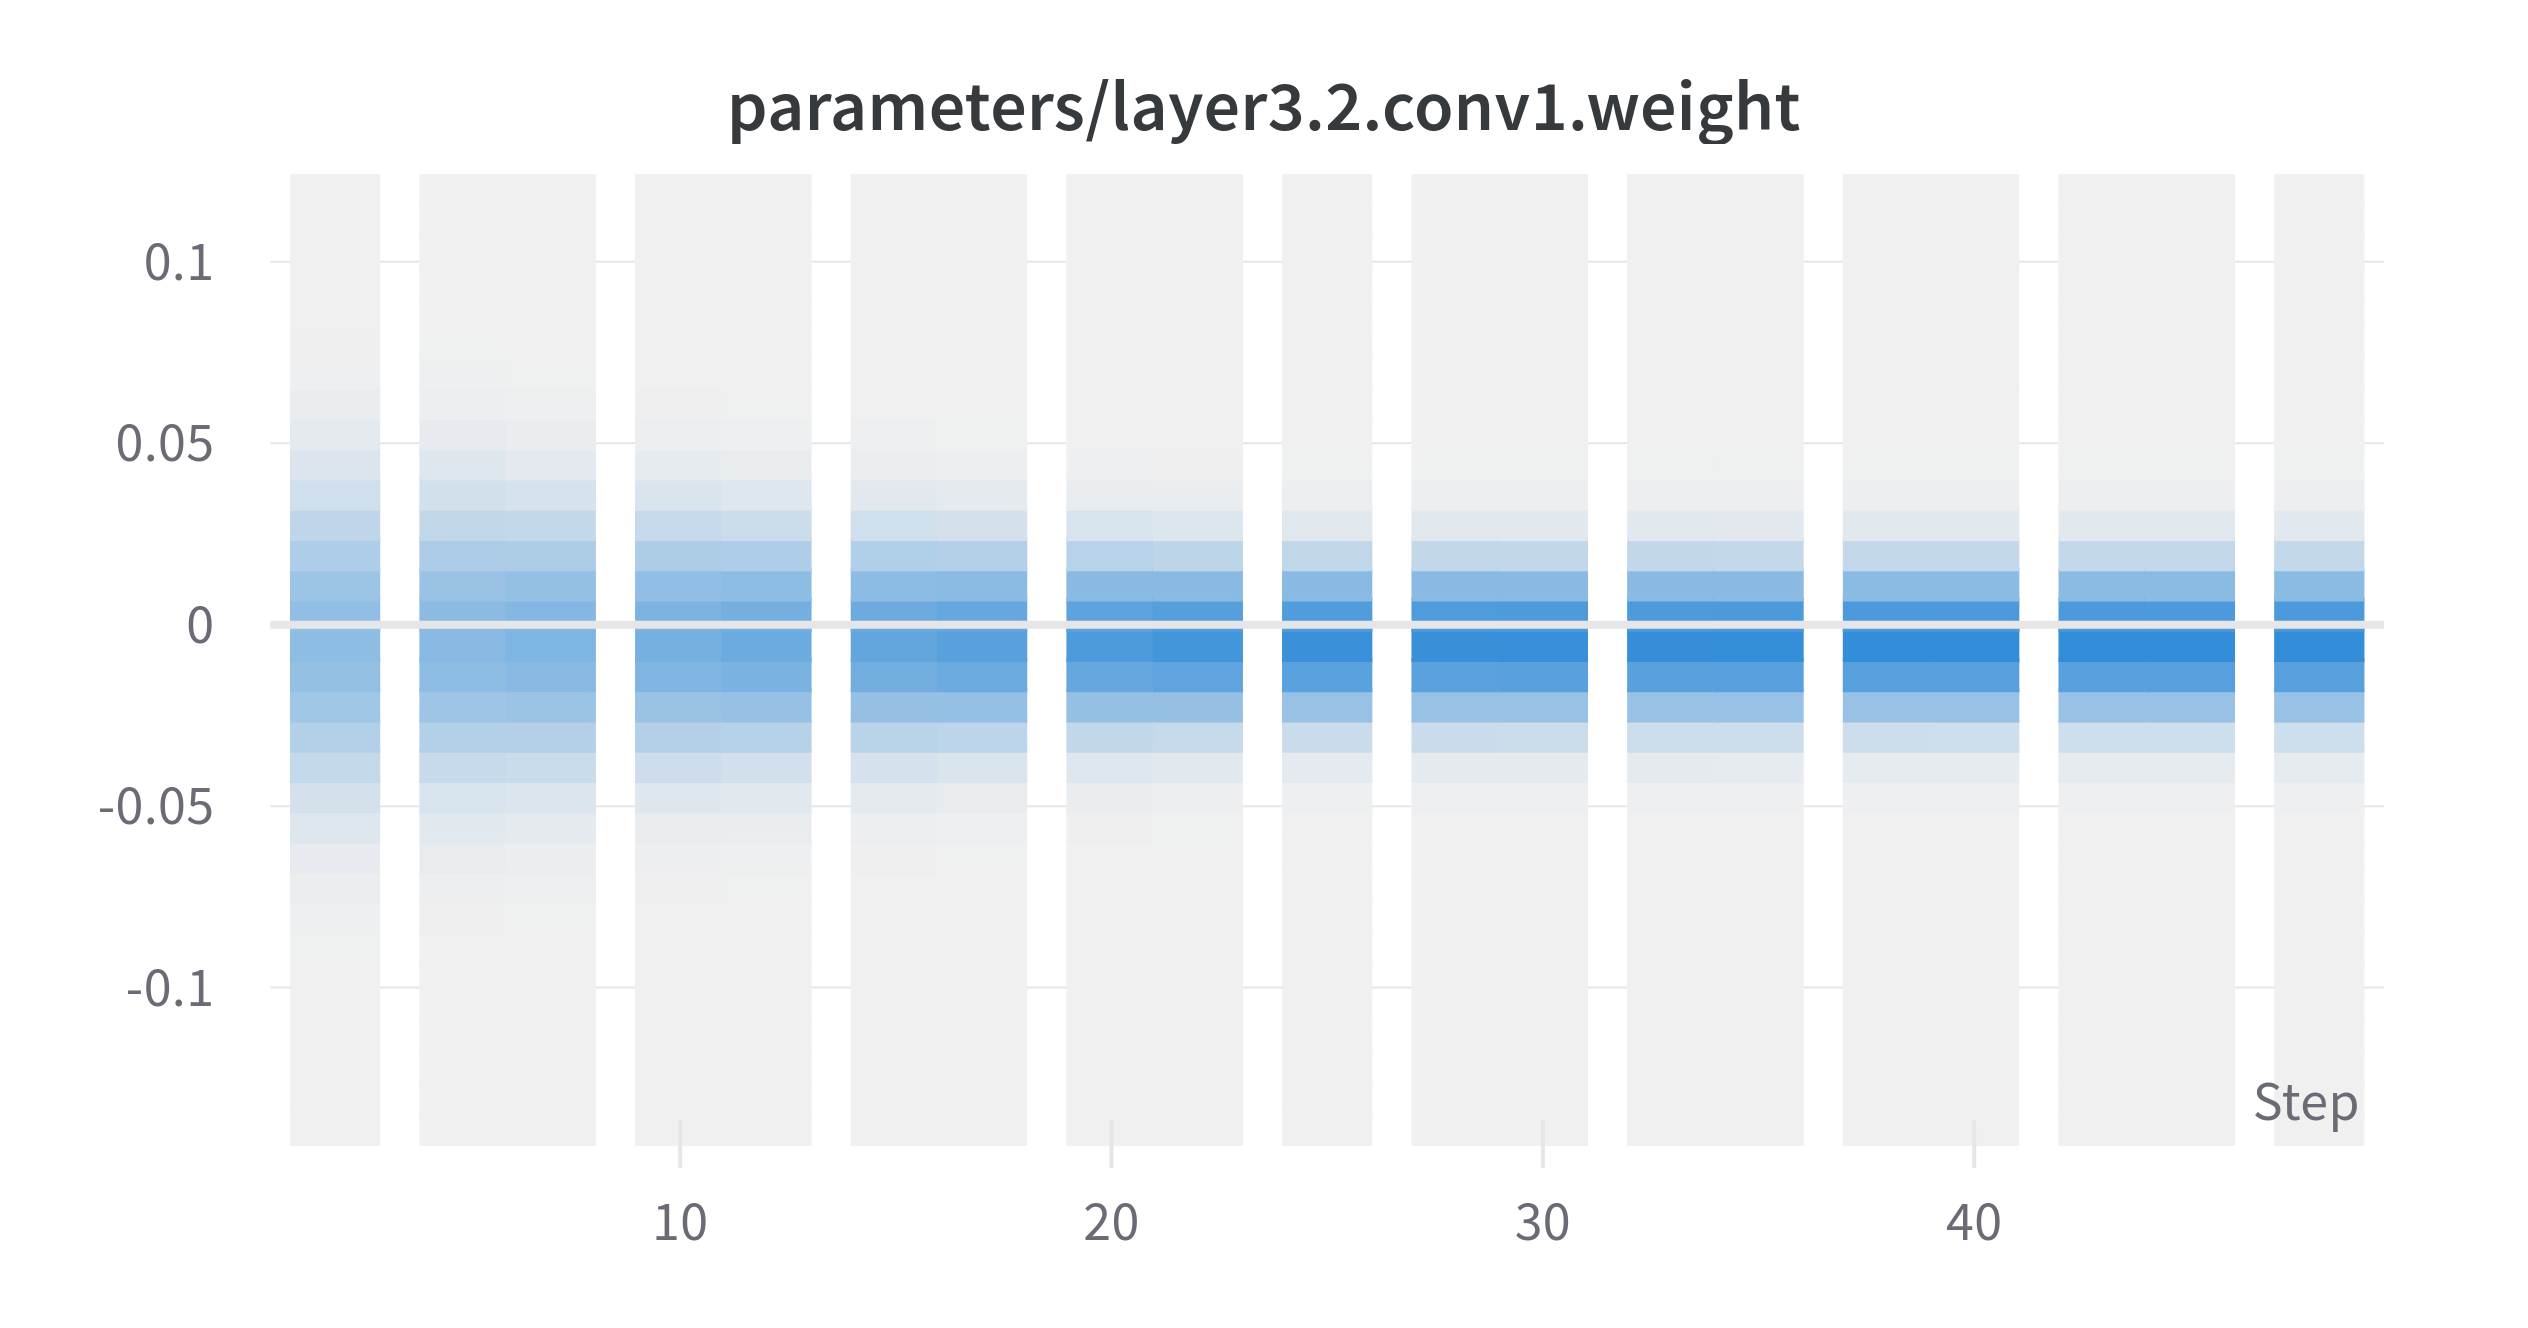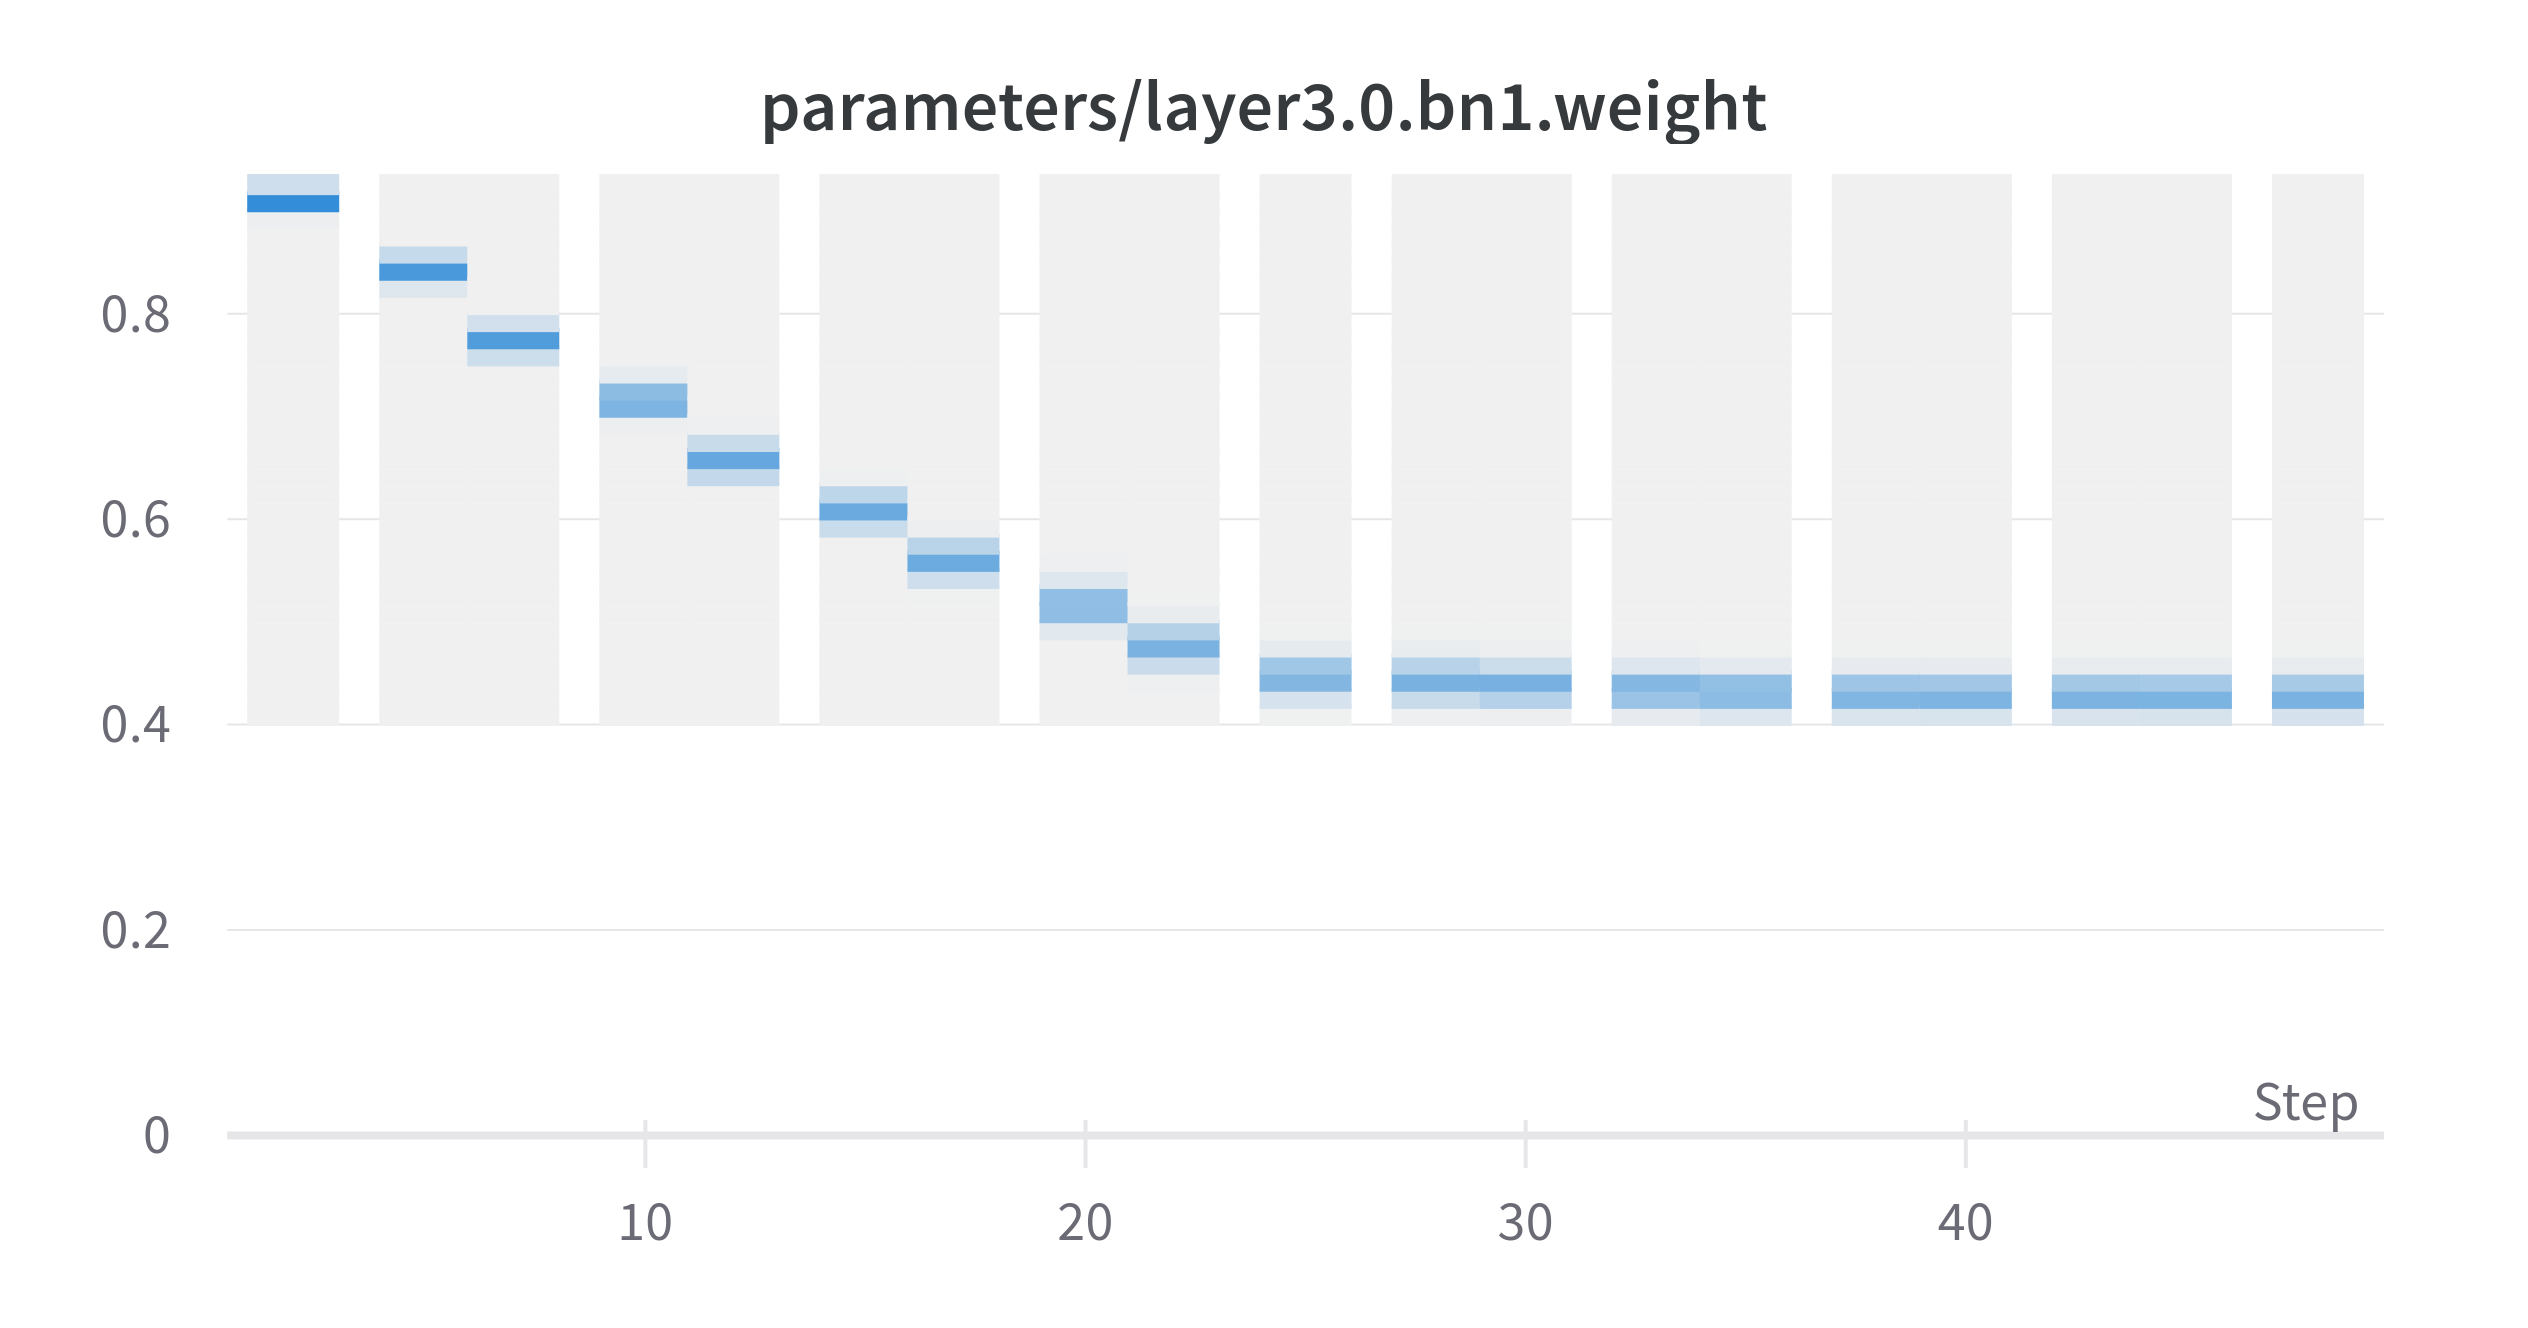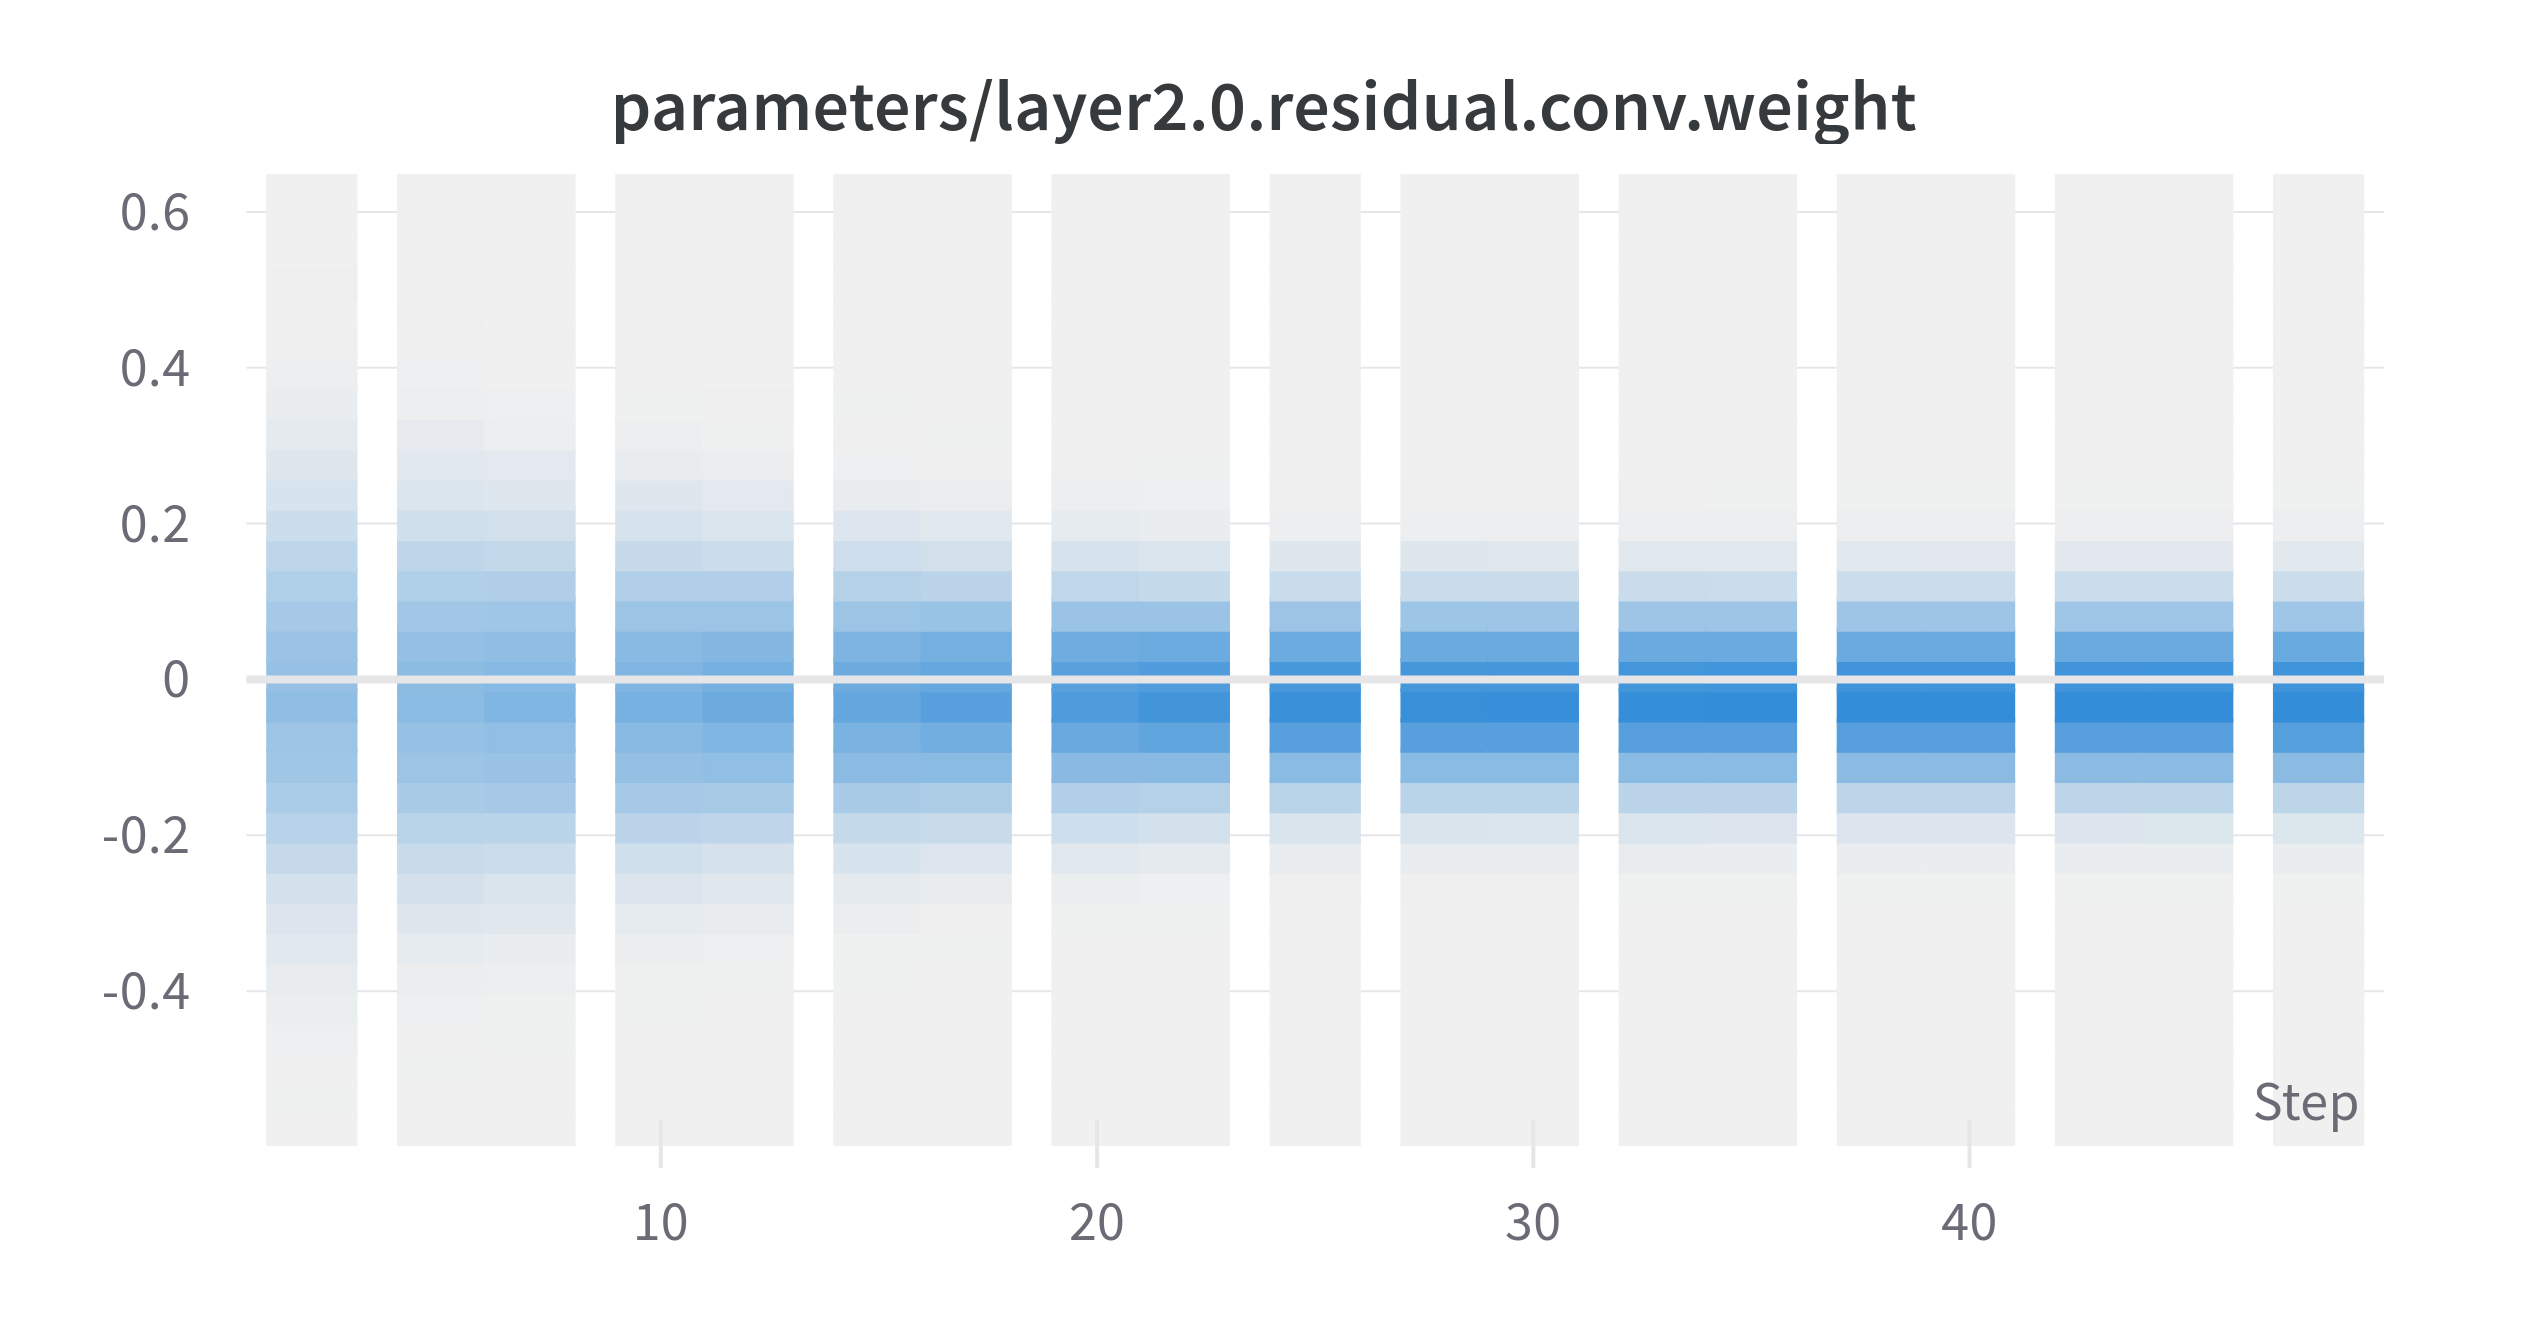